In [1]:
# import os

# os.environ["KERAS_BACKEND"] = "tensorflow"

# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import keras
from keras import layers

import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 128 # (64 + 64)
POS_ENCODE_DIMS = 16
EPOCHS = 100

2025-05-12 16:55:38.509508: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 16:55:38.558296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 16:55:39.203095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


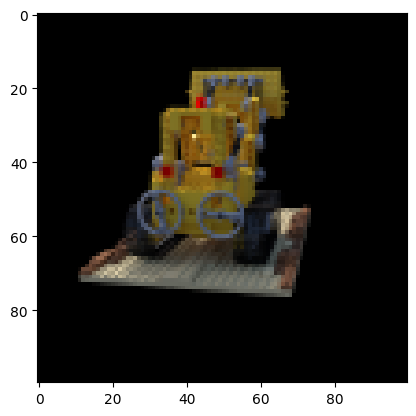

In [2]:
# Download the data if it does not already exist.
url = (
    "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
)
data = tf.keras.utils.get_file(origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [ ]:

def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0**i * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)


# def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
#     """Renders the rays and flattens it.

#     Args:
#         ray_origins: The origin points for rays.
#         ray_directions: The direction unit vectors for the rays.
#         near: The near bound of the volumetric scene.
#         far: The far bound of the volumetric scene.
#         num_samples: Number of sample points in a ray.
#         rand: Choice for randomising the sampling strategy.

#     Returns:
#        Tuple of flattened rays and sample points on each rays.
#     """
#     # Compute 3D query points.
#     # Equation: r(t) = o+td -> Building the "t" here.
#     t_vals = tf.linspace(near, far, num_samples)
#     if rand:
#         # Inject uniform noise into sample space to make the sampling
#         # continuous.
#         shape = list(ray_origins.shape[:-1]) + [num_samples]
#         noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
#         t_vals = t_vals + noise

#     # Equation: r(t) = o + td -> Building the "r" here.
#     rays = ray_origins[..., None, :] + (
#         ray_directions[..., None, :] * t_vals[..., None]
#     )
#     rays_flat = tf.reshape(rays, [-1, 3])
#     rays_flat = encode_position(rays_flat)
#     return (rays_flat, t_vals)
def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays. (Shape: H, W, 3)
        ray_directions: The direction unit vectors for the rays. (Shape: H, W, 3)
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    
    if rand:       
        shape_prefix = tf.shape(ray_origins)[:-1]
        bin_starts_flat = tf.linspace(near, far, num_samples + 1)[:-1]
        shape_prefix_dims_len = tf.rank(ray_origins) - 1 
        view_shape_for_linspace = tf.concat([tf.ones(shape_prefix_dims_len, dtype=tf.int32), [num_samples]], axis=0)

        bin_starts_b = tf.reshape(bin_starts_flat, view_shape_for_linspace)
        bin_width = (far - near) / num_samples

        rand_shape = tf.concat([shape_prefix, [num_samples]], axis=0)
        random_offsets = tf.random.uniform(shape=rand_shape) * bin_width
        t_vals = bin_starts_b + random_offsets
    else:
        t_vals = tf.linspace(near, far, num_samples)

    # Equation: r(t) = o + td -> Building the "r" here.
    # ray_origins shape: (H, W, 3) -> ray_origins[..., None, :] shape: (H, W, 1, 3)
    # ray_directions shape: (H, W, 3) -> ray_directions[..., None, :] shape: (H, W, 1, 3)
    #
    # If rand=True, t_vals shape: (H, W, num_samples) -> t_vals[..., None] shape: (H, W, num_samples, 1)
    #   Multiplication result: (H, W, num_samples, 3)
    # If rand=False, t_vals shape: (num_samples,) -> t_vals[..., None] shape: (num_samples, 1)
    #   Multiplication result: (H, W, num_samples, 3) via broadcasting rules.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)

def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)


# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

2025-05-12 16:55:46.311353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28622 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:2a:00.0, compute capability: 8.6
2025-05-12 16:55:46.311878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 977 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:3d:00.0, compute capability: 8.6
2025-05-12 16:55:46.312356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 32714 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:cf:00.0, compute capability: 8.6


In [4]:

def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The `keras` model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)


Epoch 1/100


2025-05-12 16:56:00.819767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-05-12 16:56:04.303504: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x77ff90cff7b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-12 16:56:04.303531: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-12 16:56:04.303535: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-12 16:56:04.303539: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-12 16:56:04.307672: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to ena

1/1 [==============================] - 1s 782ms/steposs: 0.1208 - psnr: 9.33


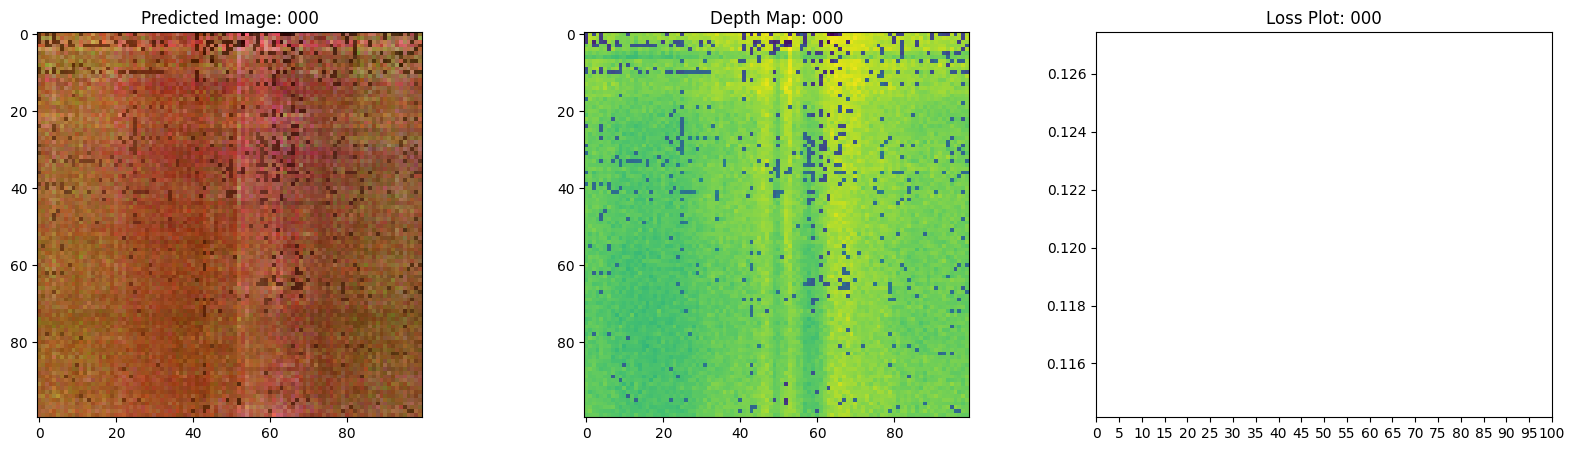

16/16 [==============================] - 29s 1s/step - loss: 0.1208 - psnr: 9.3383 - val_loss: 0.0710 - val_psnr: 11.6968
Epoch 2/100
1/1 [==============================] - 1s 678ms/steposs: 0.0650 - psnr: 12.39


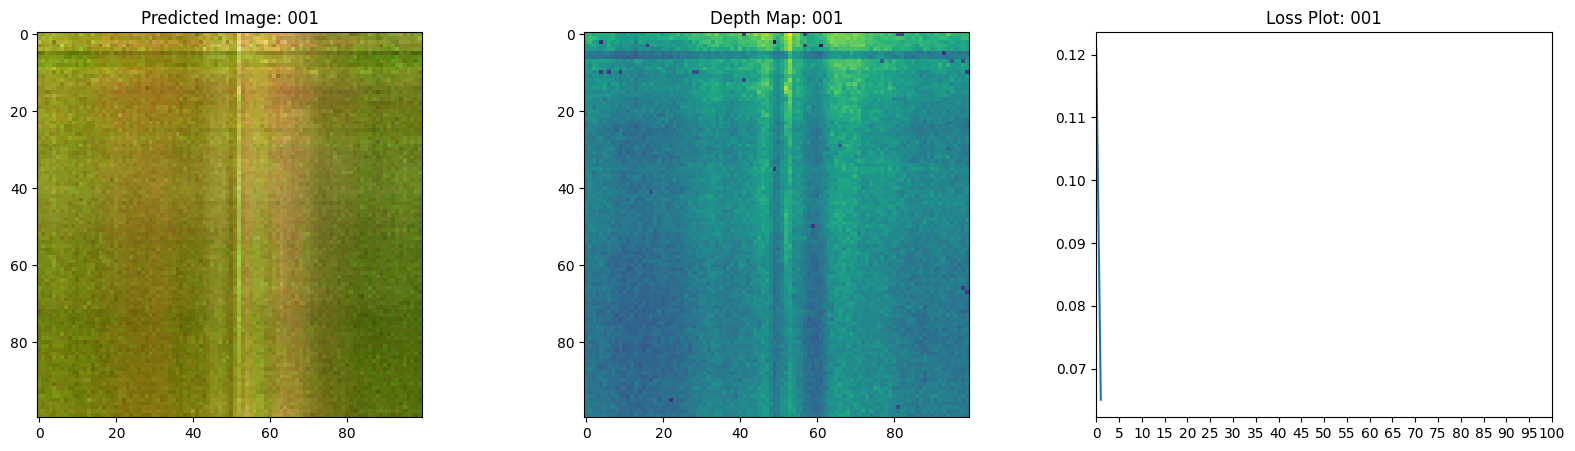

16/16 [==============================] - 25s 1s/step - loss: 0.0650 - psnr: 12.3972 - val_loss: 0.0682 - val_psnr: 12.1219
Epoch 3/100
1/1 [==============================] - 1s 764ms/steposs: 0.0611 - psnr: 12.50


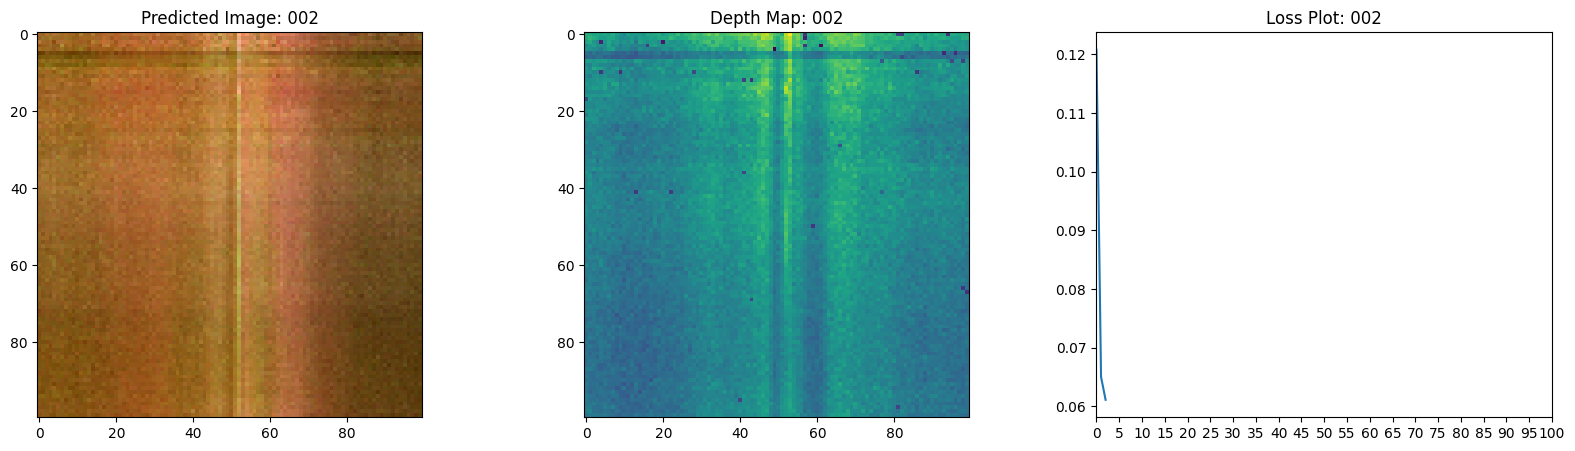

16/16 [==============================] - 24s 1s/step - loss: 0.0611 - psnr: 12.5081 - val_loss: 0.0675 - val_psnr: 11.9916
Epoch 4/100
1/1 [==============================] - 1s 761ms/steposs: 0.0594 - psnr: 12.71


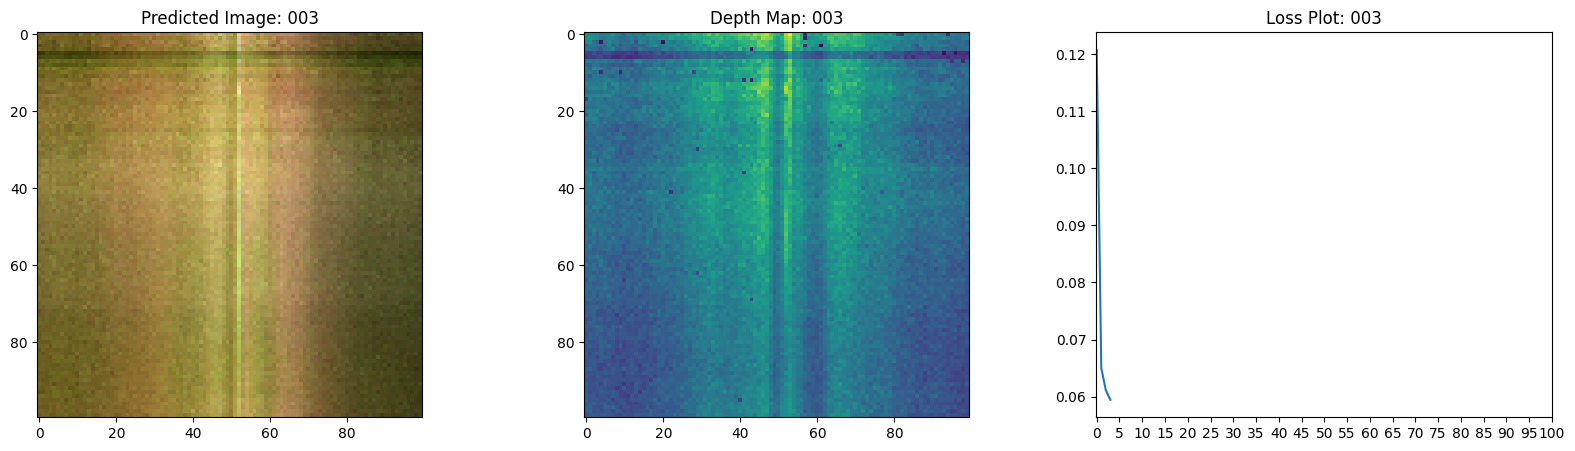

16/16 [==============================] - 23s 1s/step - loss: 0.0594 - psnr: 12.7114 - val_loss: 0.0643 - val_psnr: 12.2935
Epoch 5/100
1/1 [==============================] - 1s 745ms/steposs: 0.0580 - psnr: 12.78


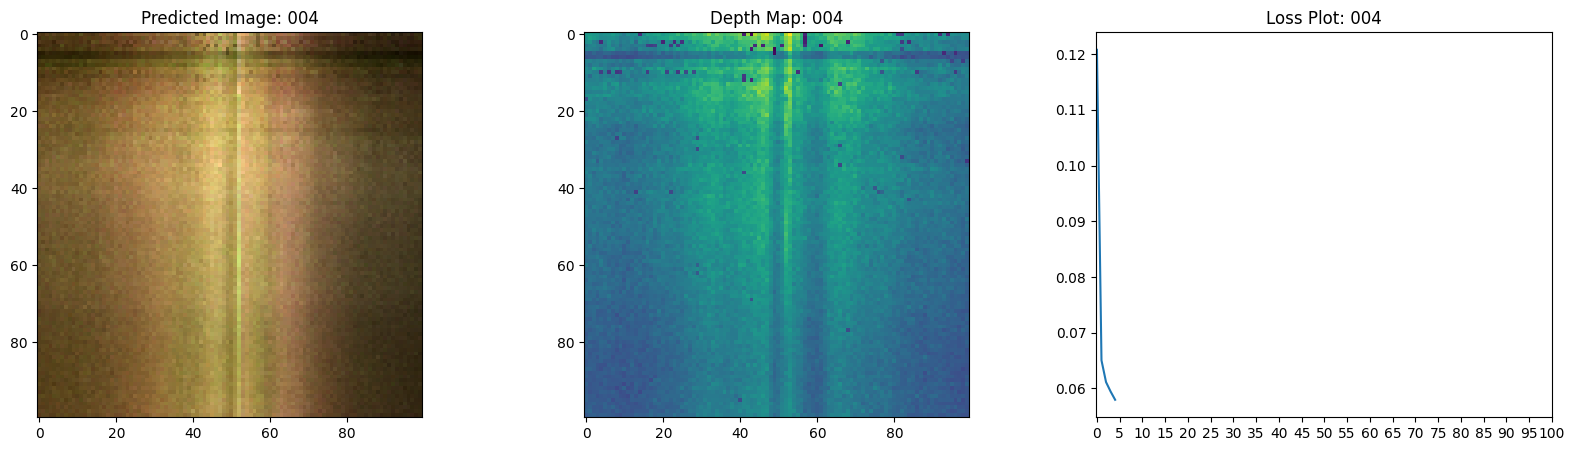

16/16 [==============================] - 24s 1s/step - loss: 0.0580 - psnr: 12.7828 - val_loss: 0.0605 - val_psnr: 12.5725
Epoch 6/100
1/1 [==============================] - 1s 751ms/steposs: 0.0537 - psnr: 13.13


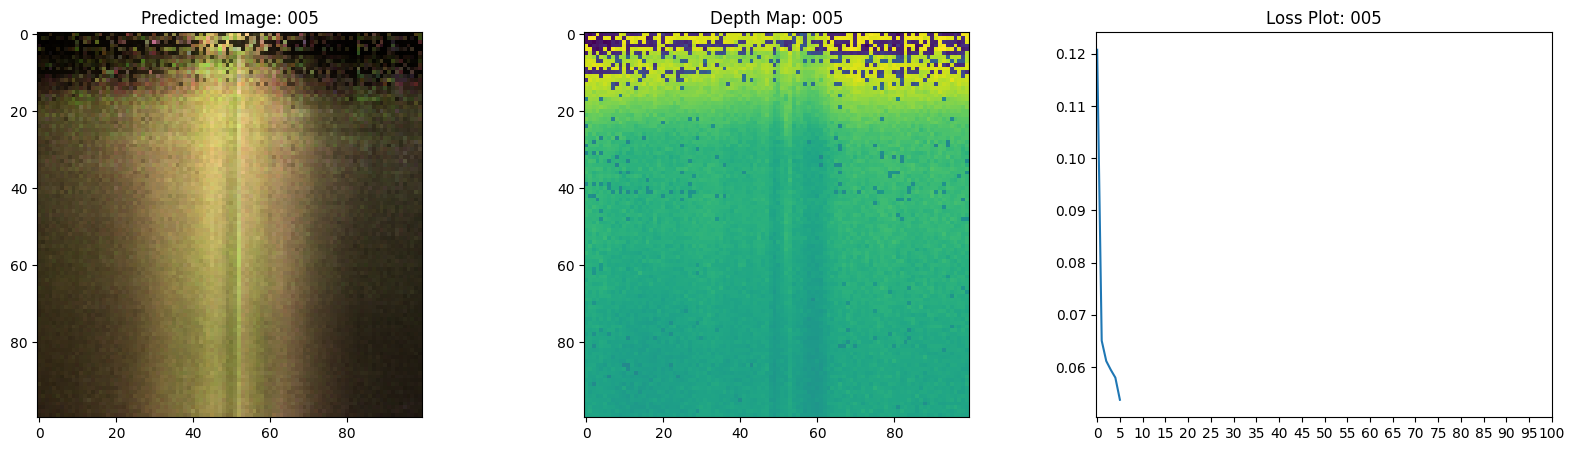

16/16 [==============================] - 23s 1s/step - loss: 0.0537 - psnr: 13.1379 - val_loss: 0.0532 - val_psnr: 13.0954
Epoch 7/100
1/1 [==============================] - 1s 738ms/steposs: 0.0461 - psnr: 13.78


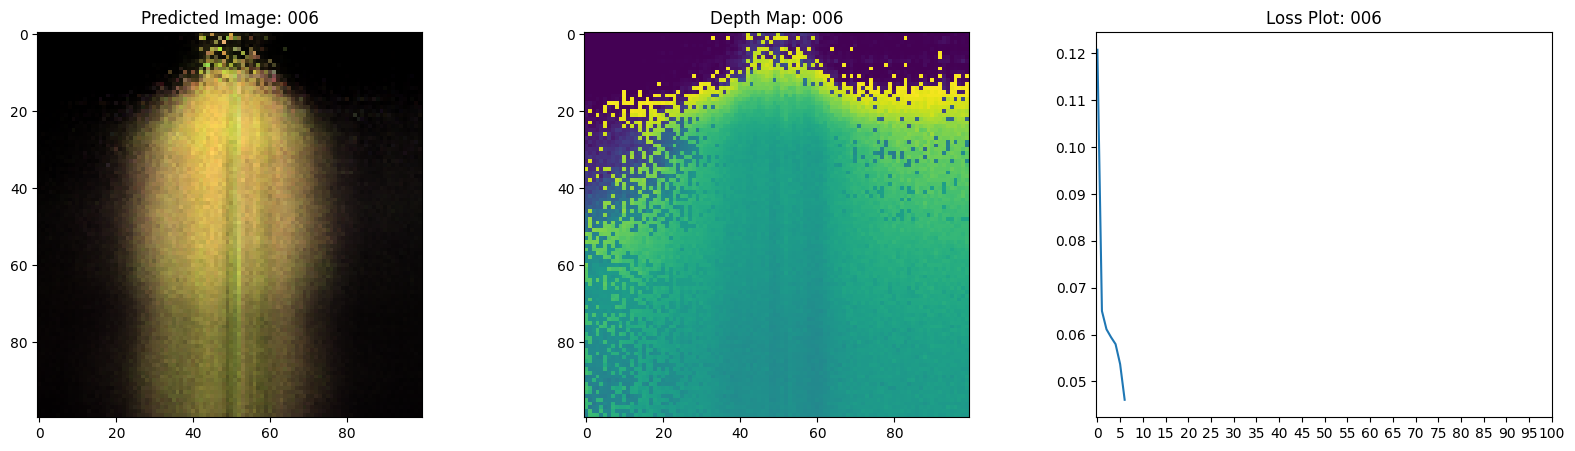

16/16 [==============================] - 24s 1s/step - loss: 0.0461 - psnr: 13.7891 - val_loss: 0.0426 - val_psnr: 13.9301
Epoch 8/100
1/1 [==============================] - 1s 1s/step- loss: 0.0345 - psnr: 14.97


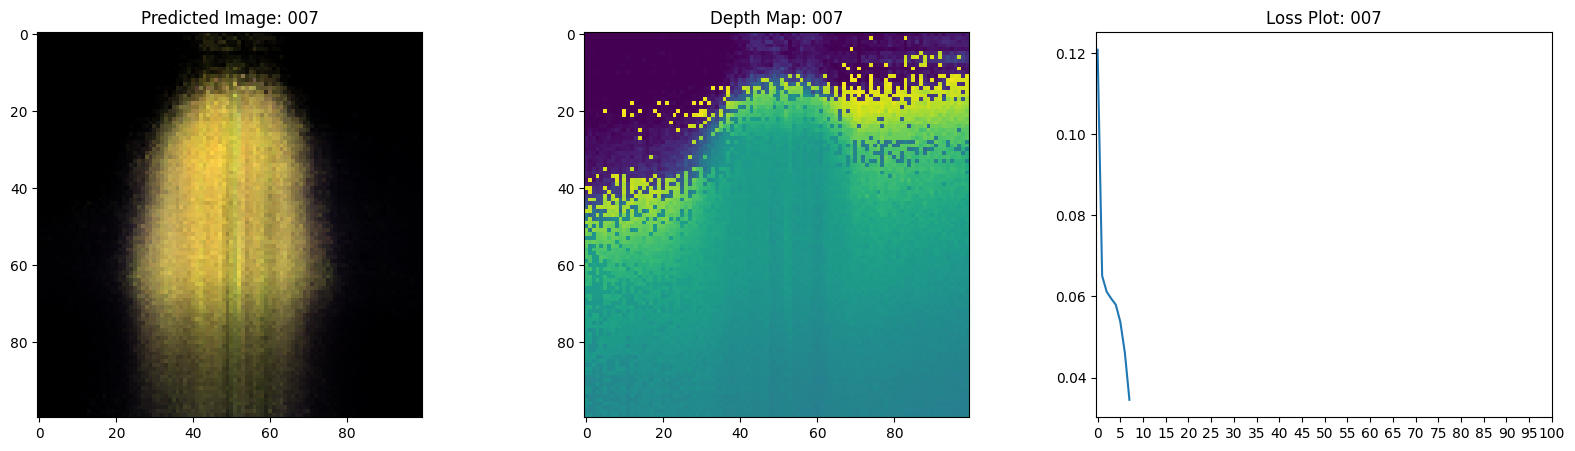

16/16 [==============================] - 25s 1s/step - loss: 0.0345 - psnr: 14.9794 - val_loss: 0.0323 - val_psnr: 15.1445
Epoch 9/100
1/1 [==============================] - 1s 748ms/steposs: 0.0286 - psnr: 15.72


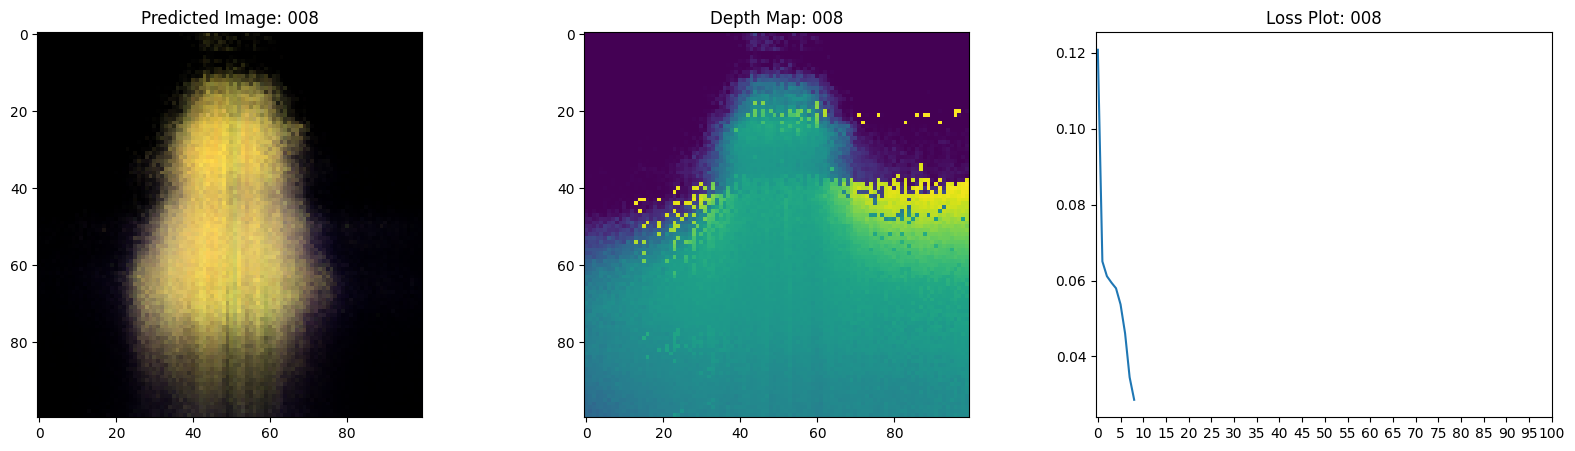

16/16 [==============================] - 23s 1s/step - loss: 0.0286 - psnr: 15.7233 - val_loss: 0.0273 - val_psnr: 15.7945
Epoch 10/100
1/1 [==============================] - 1s 750ms/steposs: 0.0256 - psnr: 16.14


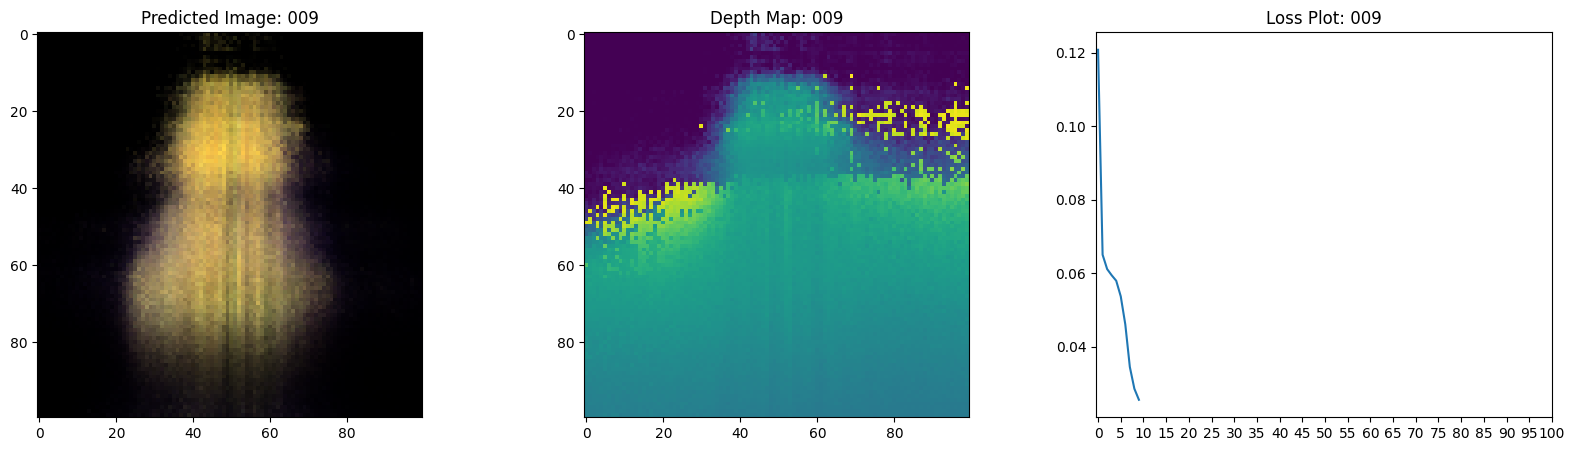

16/16 [==============================] - 23s 1s/step - loss: 0.0256 - psnr: 16.1494 - val_loss: 0.0241 - val_psnr: 16.3143
Epoch 11/100
1/1 [==============================] - 1s 739ms/steposs: 0.0223 - psnr: 16.70


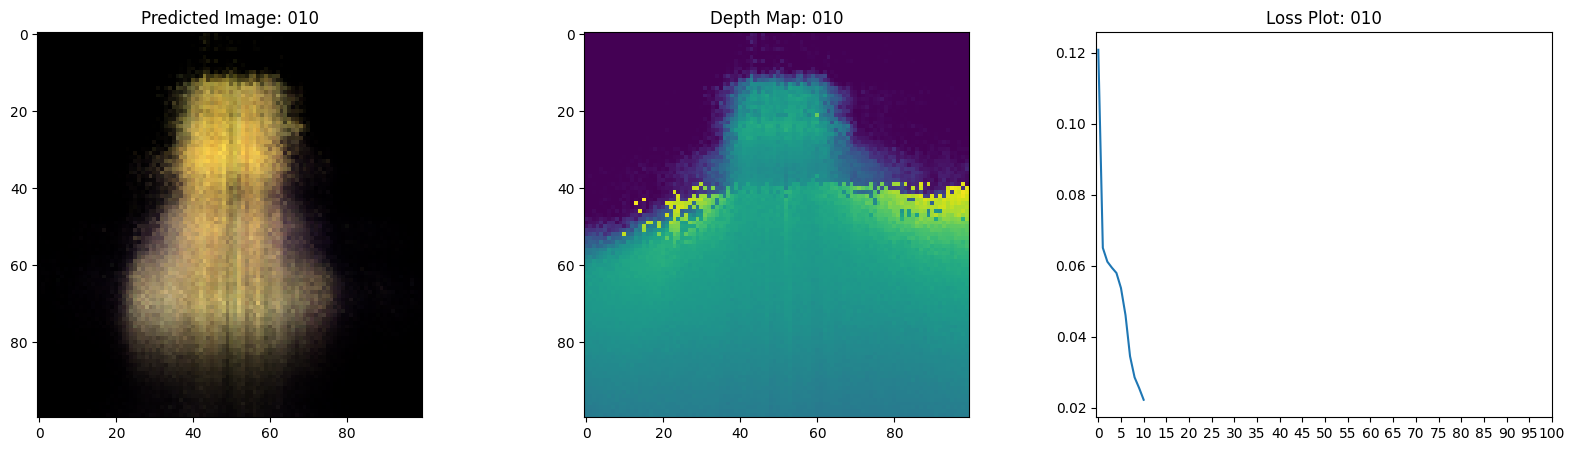

16/16 [==============================] - 23s 1s/step - loss: 0.0223 - psnr: 16.7083 - val_loss: 0.0210 - val_psnr: 16.8628
Epoch 12/100
1/1 [==============================] - 1s 1s/step- loss: 0.0199 - psnr: 17.16


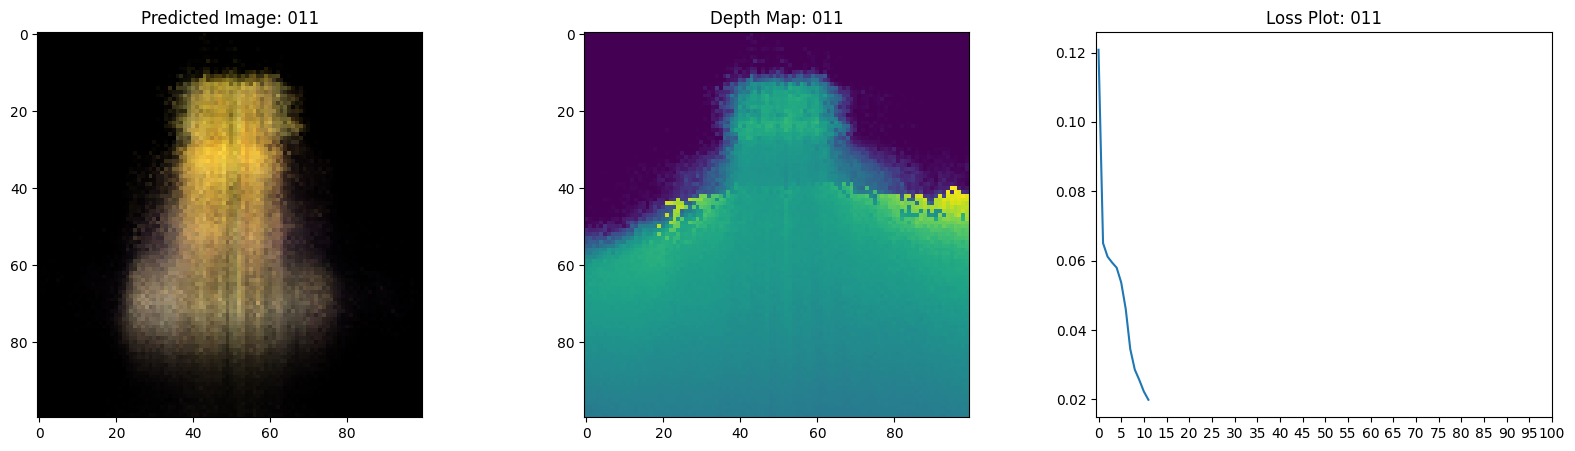

16/16 [==============================] - 26s 1s/step - loss: 0.0199 - psnr: 17.1653 - val_loss: 0.0187 - val_psnr: 17.3428
Epoch 13/100
1/1 [==============================] - 1s 737ms/steposs: 0.0186 - psnr: 17.47


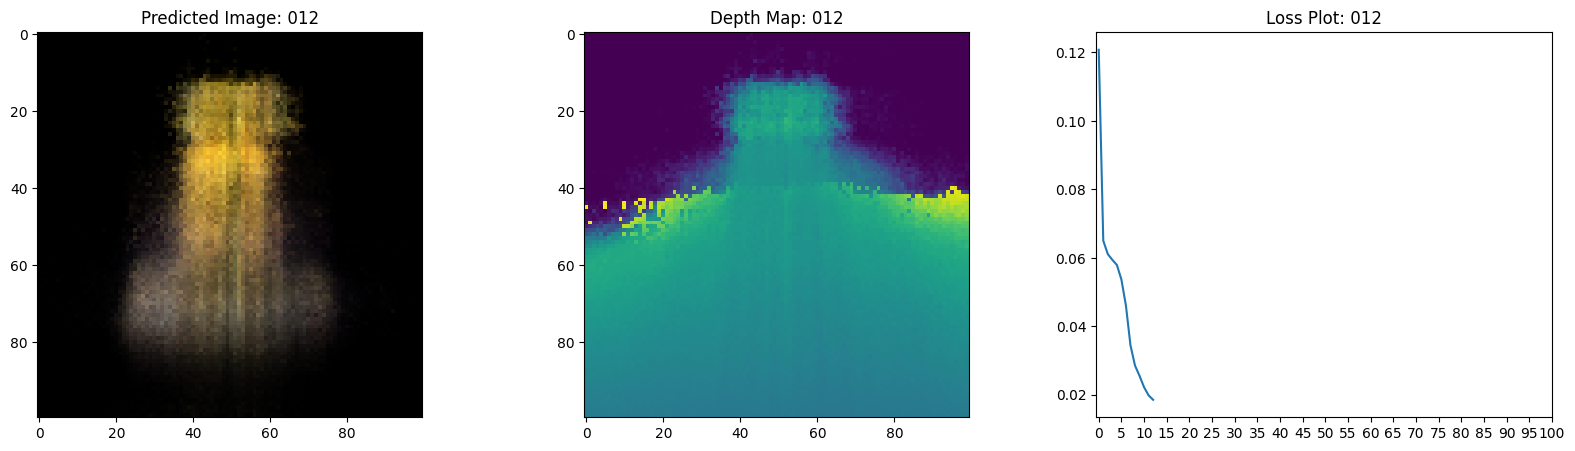

16/16 [==============================] - 23s 1s/step - loss: 0.0186 - psnr: 17.4774 - val_loss: 0.0167 - val_psnr: 17.8494
Epoch 14/100
1/1 [==============================] - 1s 753ms/steposs: 0.0165 - psnr: 17.96


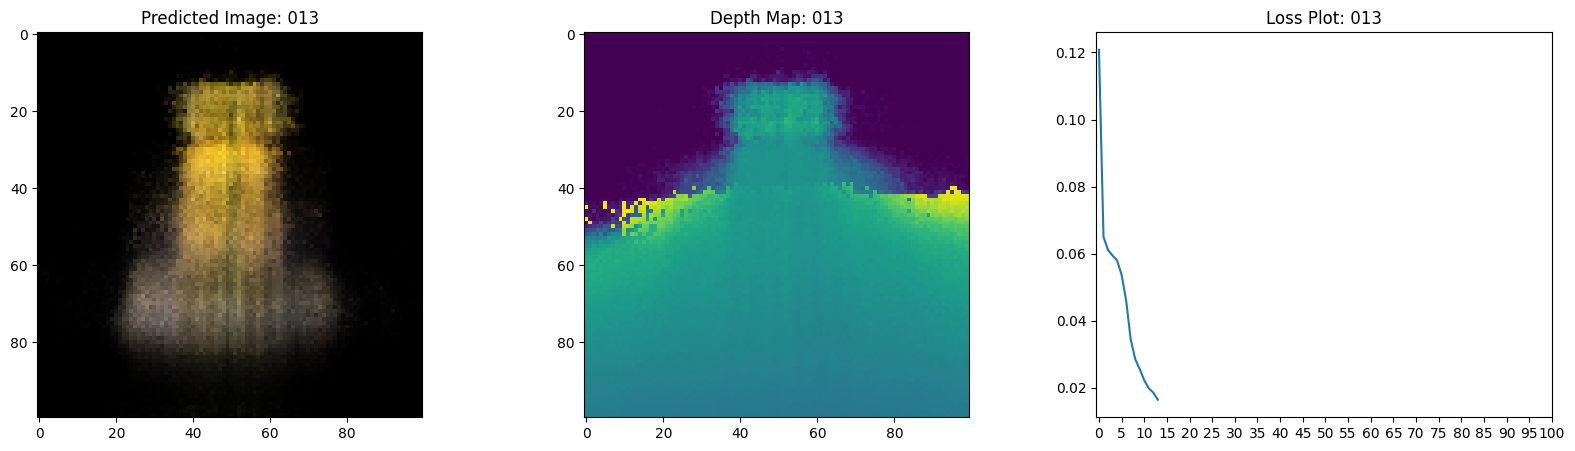

16/16 [==============================] - 23s 1s/step - loss: 0.0165 - psnr: 17.9679 - val_loss: 0.0153 - val_psnr: 18.2125
Epoch 15/100
1/1 [==============================] - 1s 752ms/steposs: 0.0155 - psnr: 18.23


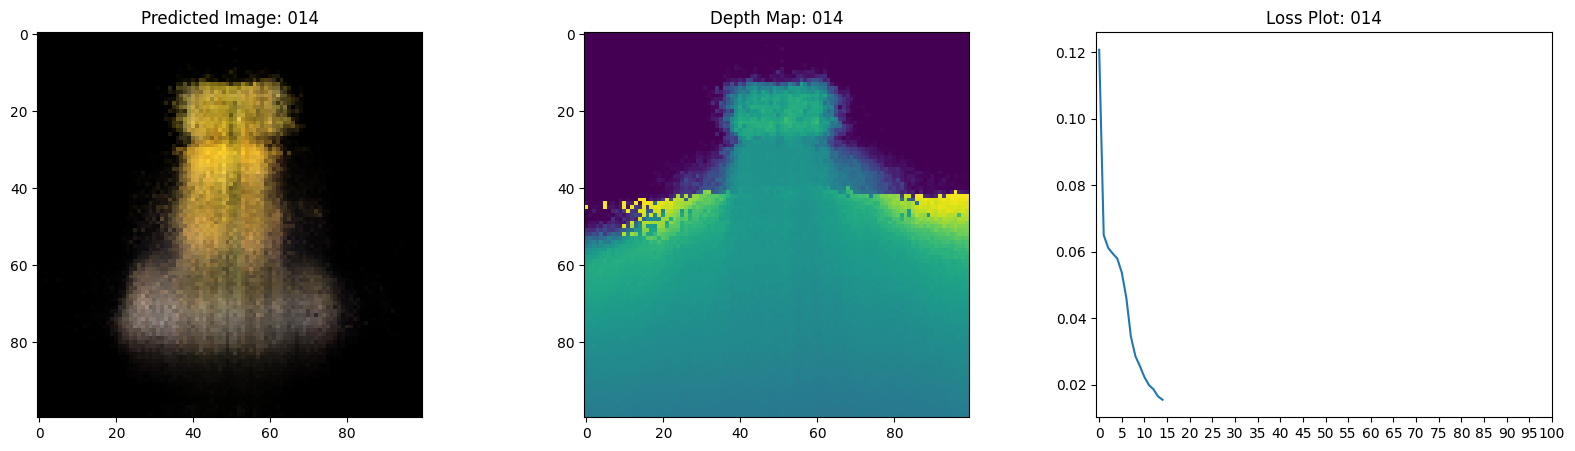

16/16 [==============================] - 23s 1s/step - loss: 0.0155 - psnr: 18.2302 - val_loss: 0.0146 - val_psnr: 18.4195
Epoch 16/100
1/1 [==============================] - 1s 744ms/steposs: 0.0149 - psnr: 18.37


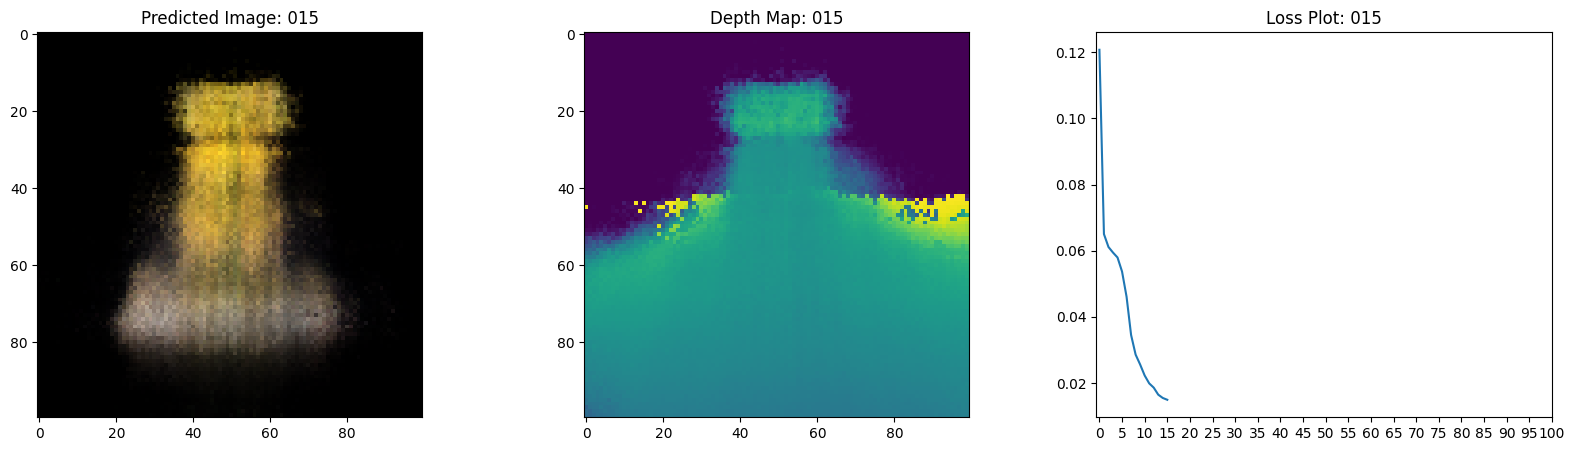

16/16 [==============================] - 23s 1s/step - loss: 0.0149 - psnr: 18.3757 - val_loss: 0.0142 - val_psnr: 18.5354
Epoch 17/100
1/1 [==============================] - 1s 747ms/steposs: 0.0138 - psnr: 18.70


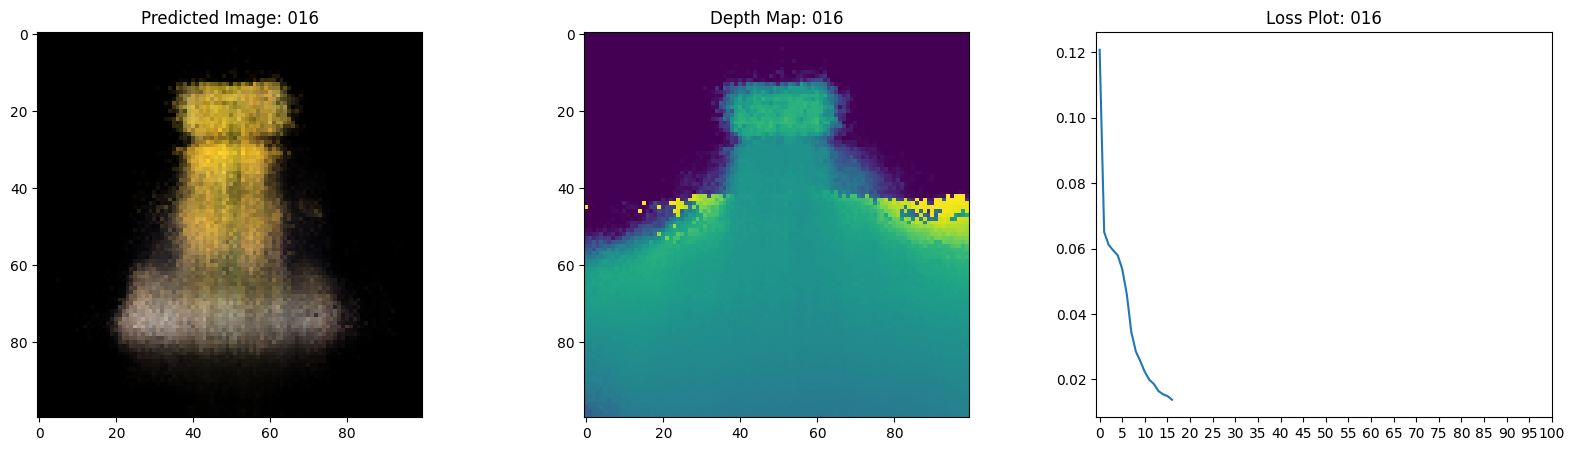

16/16 [==============================] - 23s 1s/step - loss: 0.0138 - psnr: 18.7080 - val_loss: 0.0133 - val_psnr: 18.8147
Epoch 18/100
1/1 [==============================] - 1s 762ms/steposs: 0.0132 - psnr: 18.91


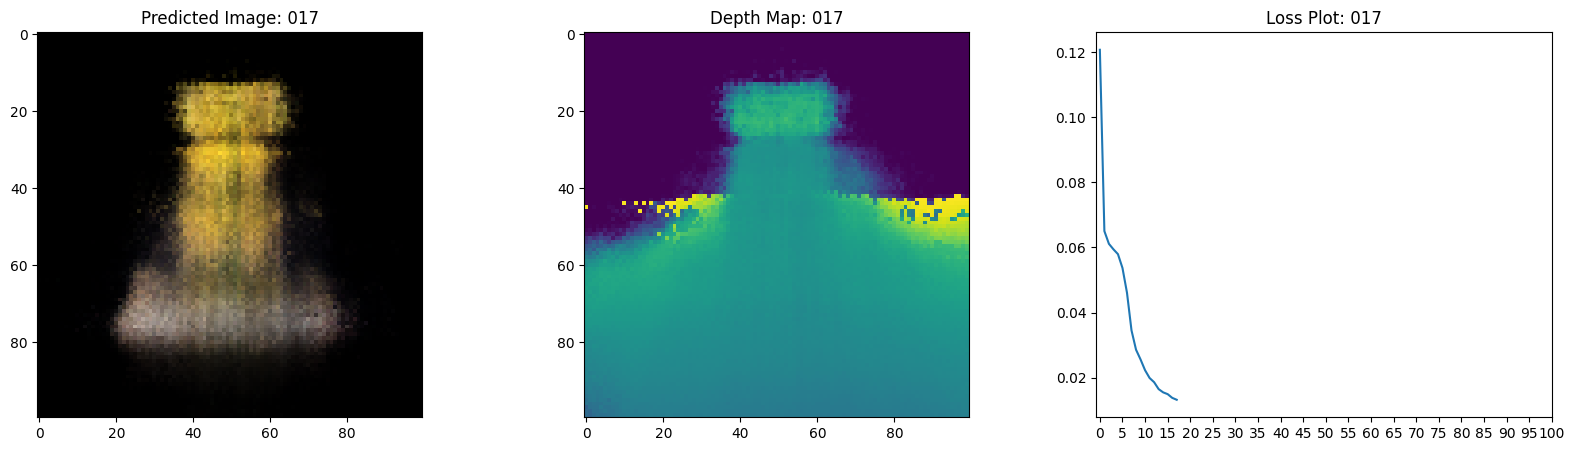

16/16 [==============================] - 23s 1s/step - loss: 0.0132 - psnr: 18.9101 - val_loss: 0.0130 - val_psnr: 18.9081
Epoch 19/100
1/1 [==============================] - 1s 752ms/steposs: 0.0124 - psnr: 19.17


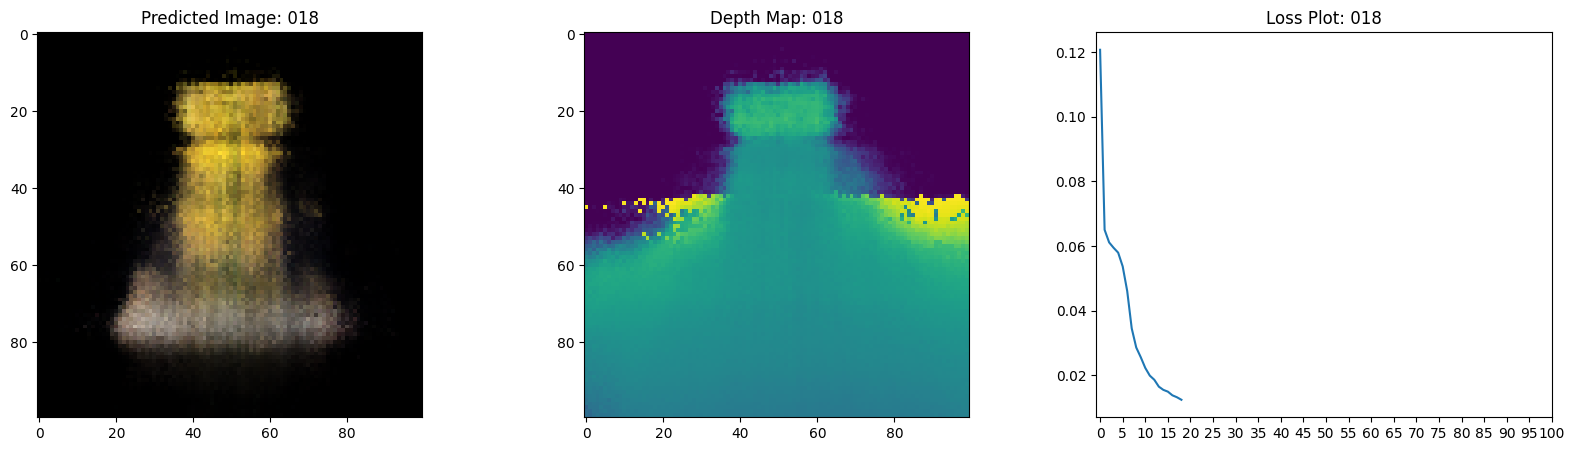

16/16 [==============================] - 23s 1s/step - loss: 0.0124 - psnr: 19.1788 - val_loss: 0.0121 - val_psnr: 19.2289
Epoch 20/100
1/1 [==============================] - 1s 751ms/steposs: 0.0122 - psnr: 19.23


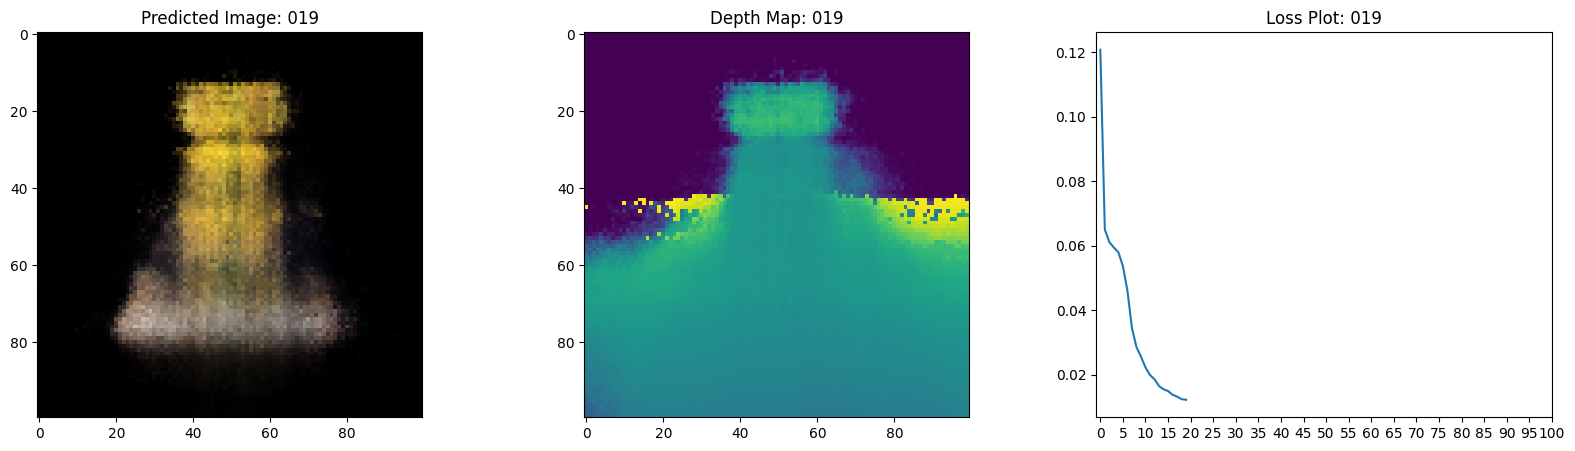

16/16 [==============================] - 23s 1s/step - loss: 0.0122 - psnr: 19.2386 - val_loss: 0.0117 - val_psnr: 19.3943
Epoch 21/100
1/1 [==============================] - 1s 728ms/steposs: 0.0115 - psnr: 19.51


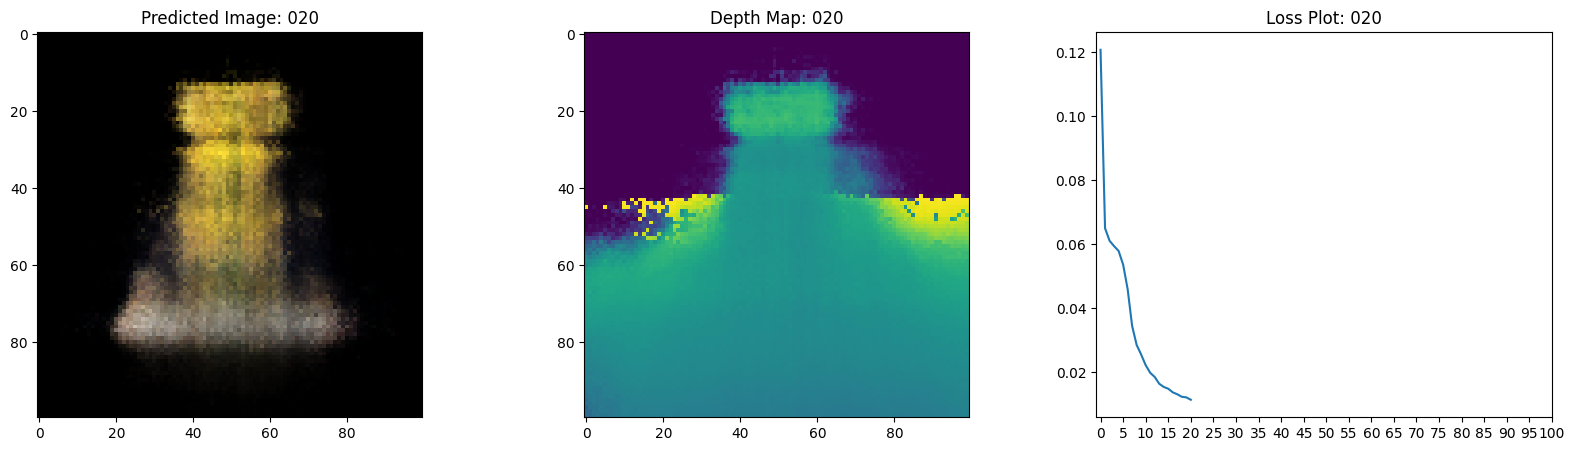

16/16 [==============================] - 23s 1s/step - loss: 0.0115 - psnr: 19.5164 - val_loss: 0.0114 - val_psnr: 19.4978
Epoch 22/100
1/1 [==============================] - 1s 747ms/steposs: 0.0113 - psnr: 19.55


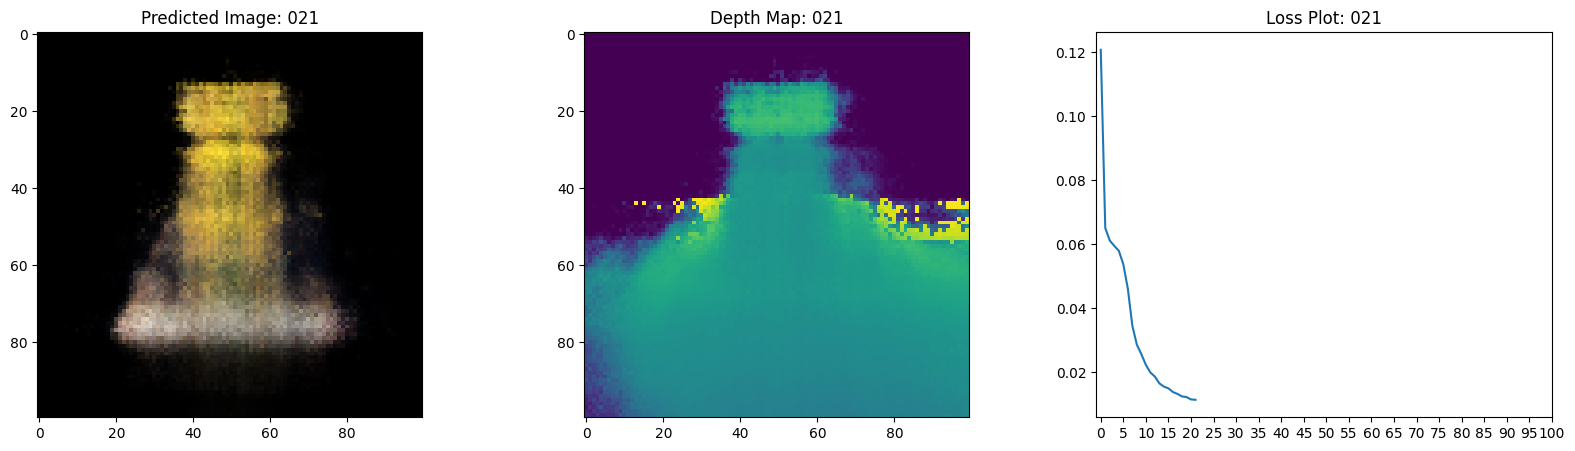

16/16 [==============================] - 23s 1s/step - loss: 0.0113 - psnr: 19.5503 - val_loss: 0.0114 - val_psnr: 19.4773
Epoch 23/100
1/1 [==============================] - 1s 743ms/steposs: 0.0109 - psnr: 19.73


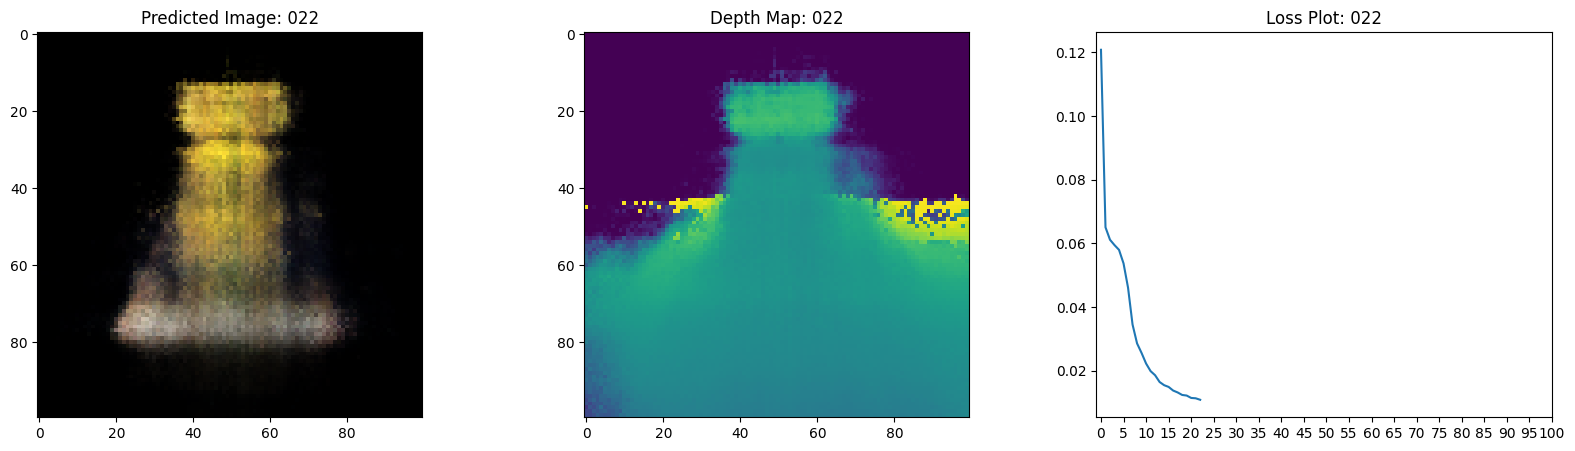

16/16 [==============================] - 23s 1s/step - loss: 0.0109 - psnr: 19.7375 - val_loss: 0.0105 - val_psnr: 19.8142
Epoch 24/100
1/1 [==============================] - 1s 751ms/steposs: 0.0103 - psnr: 19.98


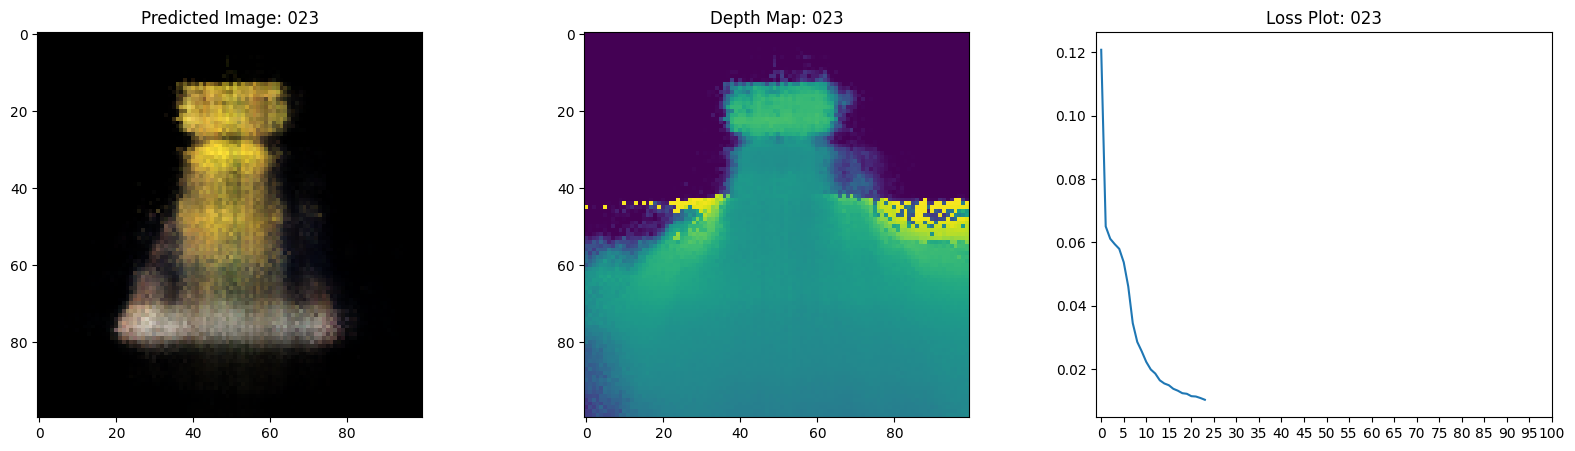

16/16 [==============================] - 23s 1s/step - loss: 0.0103 - psnr: 19.9812 - val_loss: 0.0103 - val_psnr: 19.9994
Epoch 25/100
1/1 [==============================] - 1s 749ms/steposs: 0.0099 - psnr: 20.13


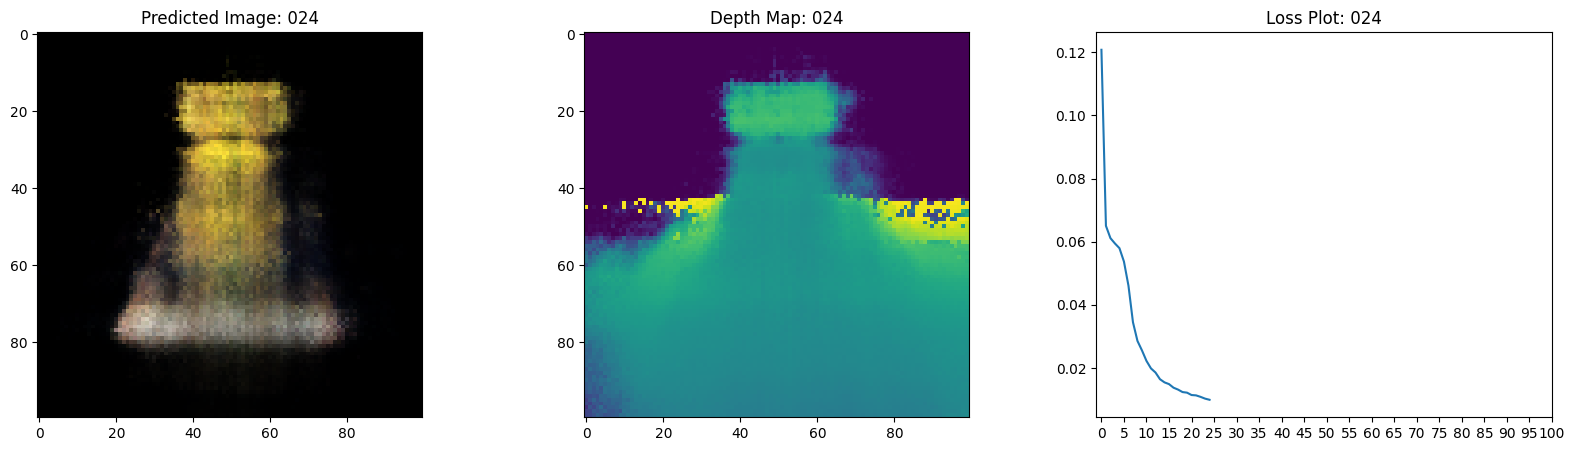

16/16 [==============================] - 23s 1s/step - loss: 0.0099 - psnr: 20.1351 - val_loss: 0.0099 - val_psnr: 20.1291
Epoch 26/100
1/1 [==============================] - 1s 744ms/steposs: 0.0098 - psnr: 20.21


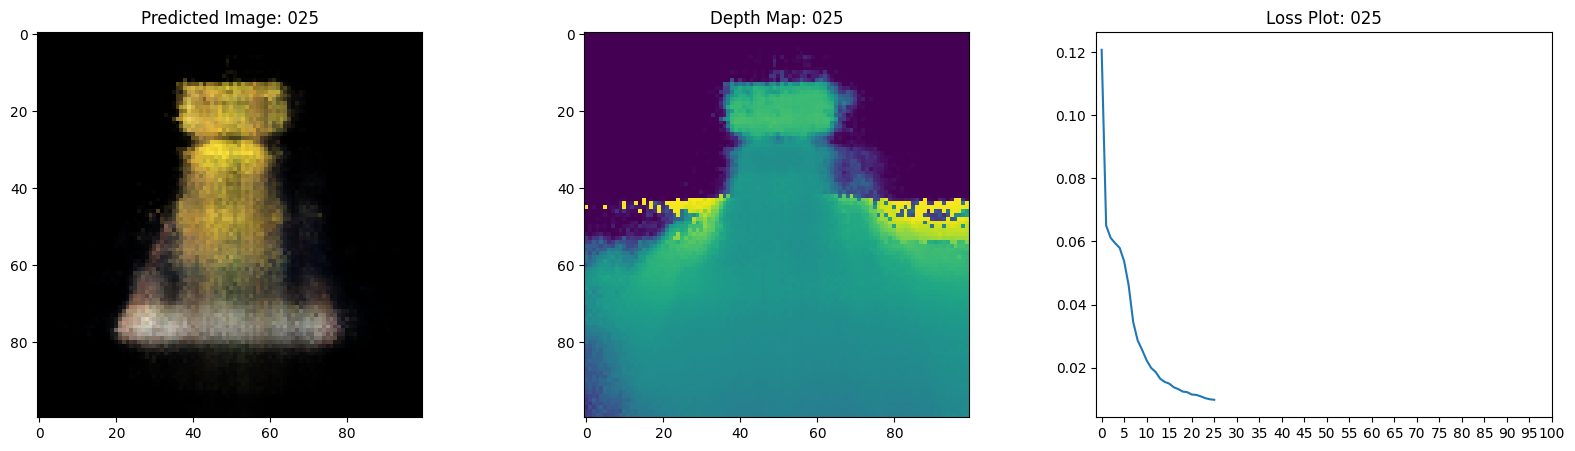

16/16 [==============================] - 23s 1s/step - loss: 0.0098 - psnr: 20.2173 - val_loss: 0.0099 - val_psnr: 20.1128
Epoch 27/100
1/1 [==============================] - 1s 742ms/steposs: 0.0095 - psnr: 20.35


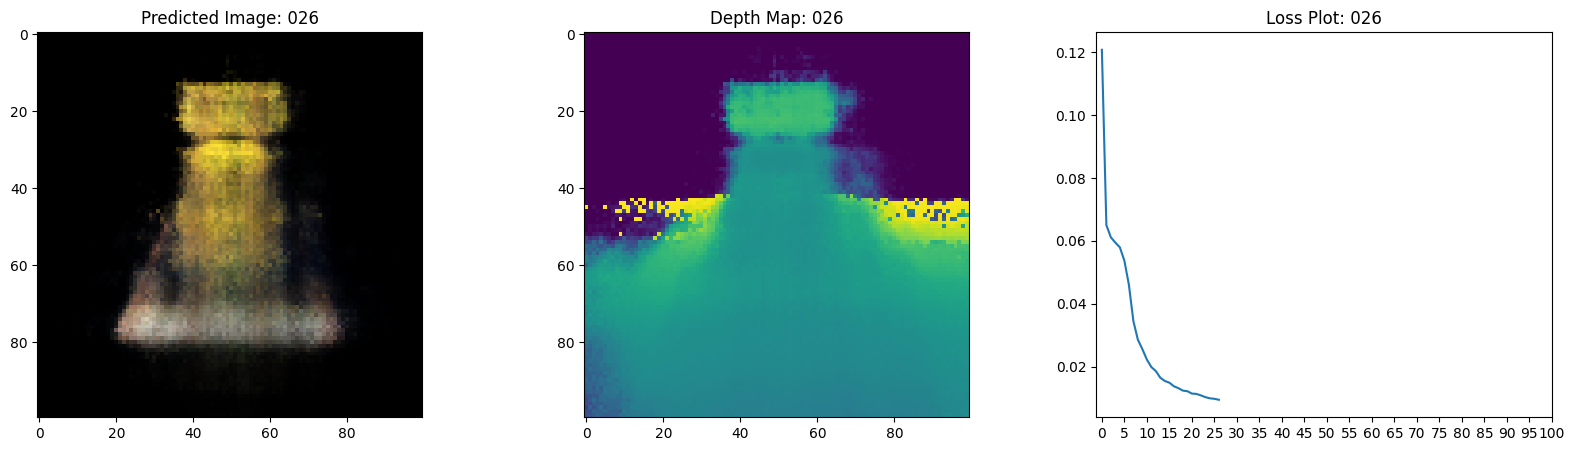

16/16 [==============================] - 23s 1s/step - loss: 0.0095 - psnr: 20.3533 - val_loss: 0.0096 - val_psnr: 20.2541
Epoch 28/100
1/1 [==============================] - 1s 750ms/steposs: 0.0091 - psnr: 20.52


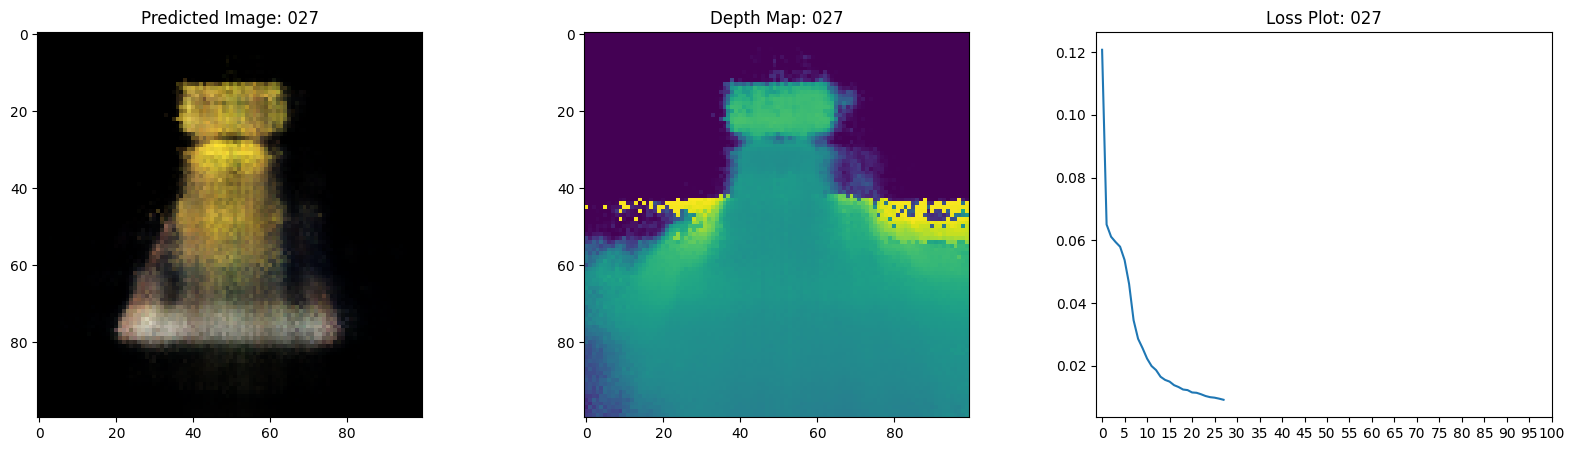

16/16 [==============================] - 23s 1s/step - loss: 0.0091 - psnr: 20.5221 - val_loss: 0.0094 - val_psnr: 20.3419
Epoch 29/100
1/1 [==============================] - 1s 738ms/steposs: 0.0089 - psnr: 20.61


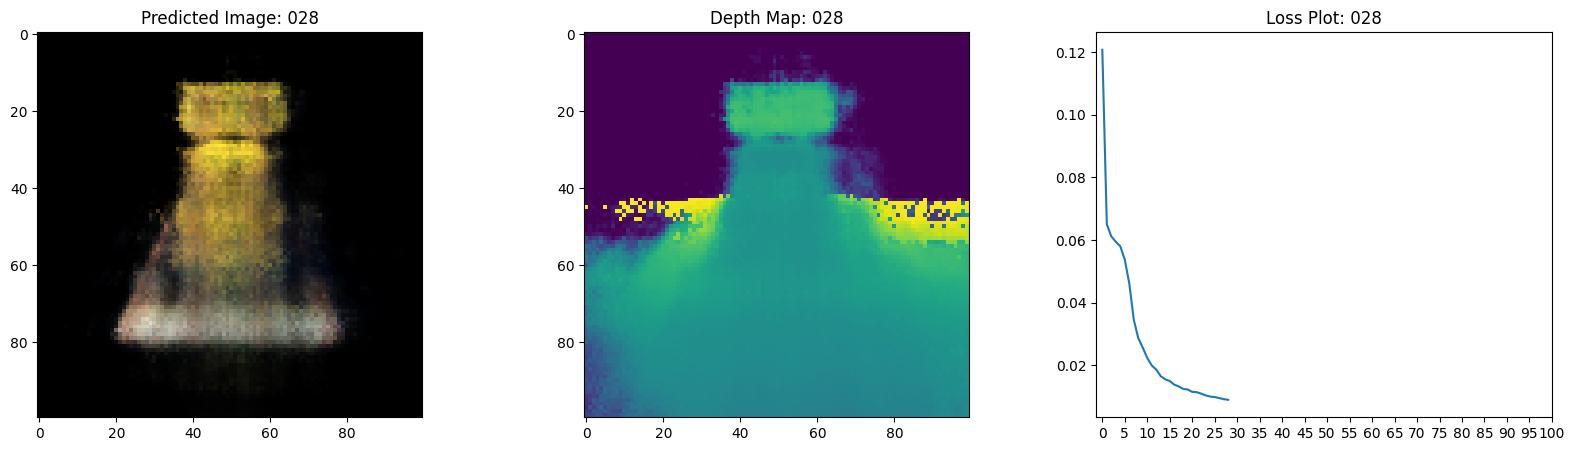

16/16 [==============================] - 23s 1s/step - loss: 0.0089 - psnr: 20.6176 - val_loss: 0.0093 - val_psnr: 20.3971
Epoch 30/100
1/1 [==============================] - 1s 750ms/steposs: 0.0088 - psnr: 20.65


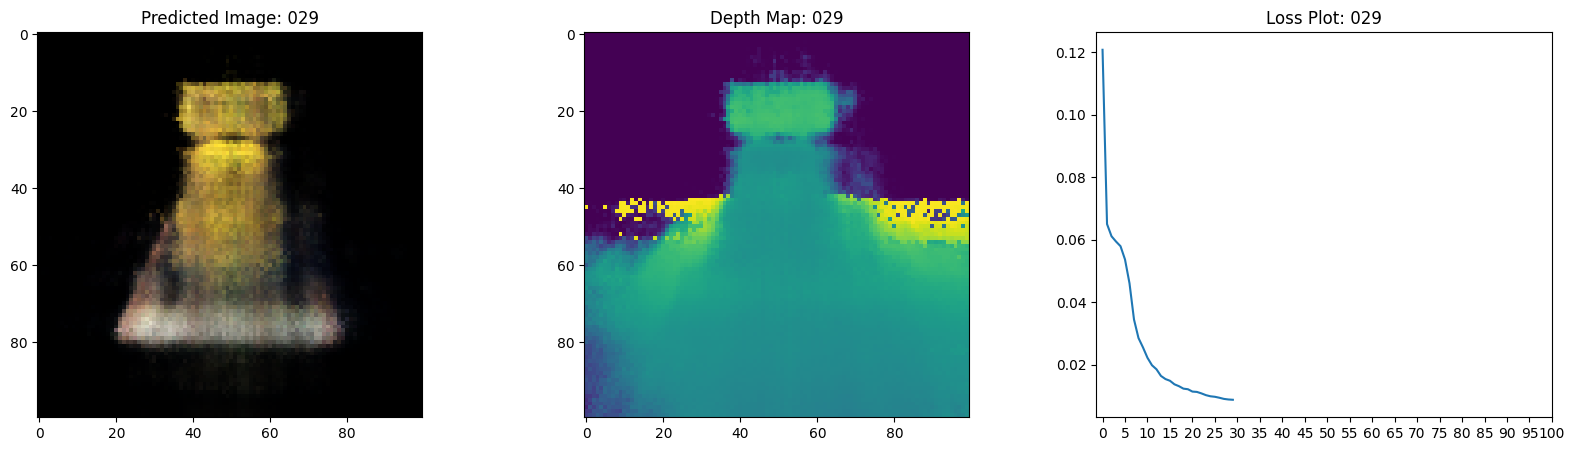

16/16 [==============================] - 23s 1s/step - loss: 0.0088 - psnr: 20.6596 - val_loss: 0.0088 - val_psnr: 20.6698
Epoch 31/100
1/1 [==============================] - 1s 743ms/steposs: 0.0086 - psnr: 20.79


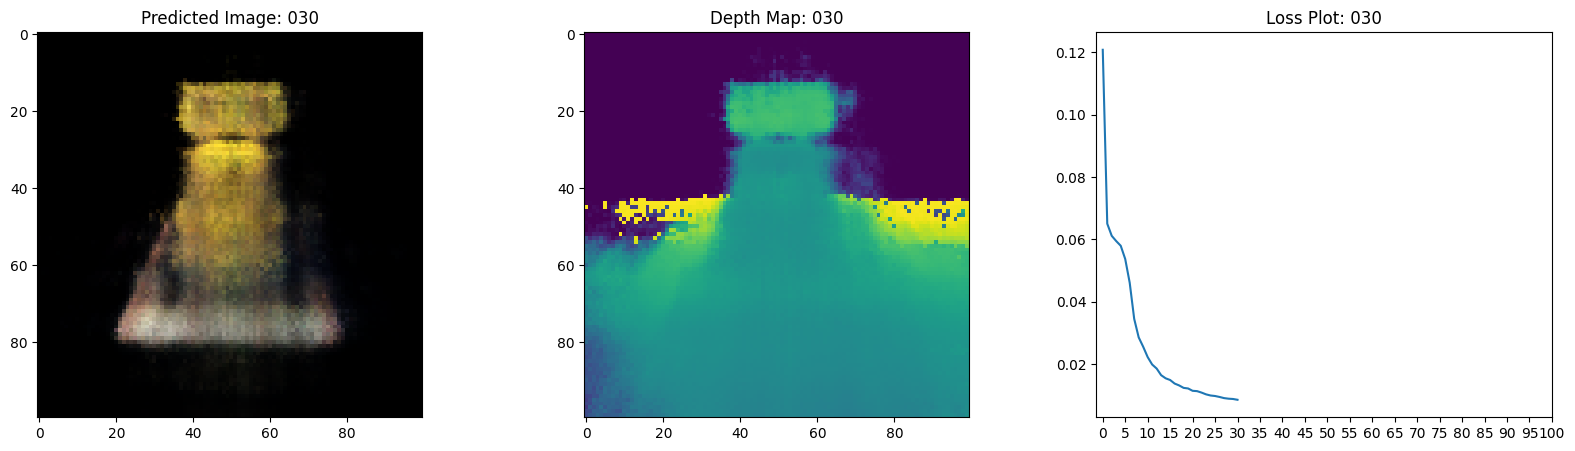

16/16 [==============================] - 23s 1s/step - loss: 0.0086 - psnr: 20.7920 - val_loss: 0.0086 - val_psnr: 20.7512
Epoch 32/100
1/1 [==============================] - 1s 746ms/steposs: 0.0082 - psnr: 20.97


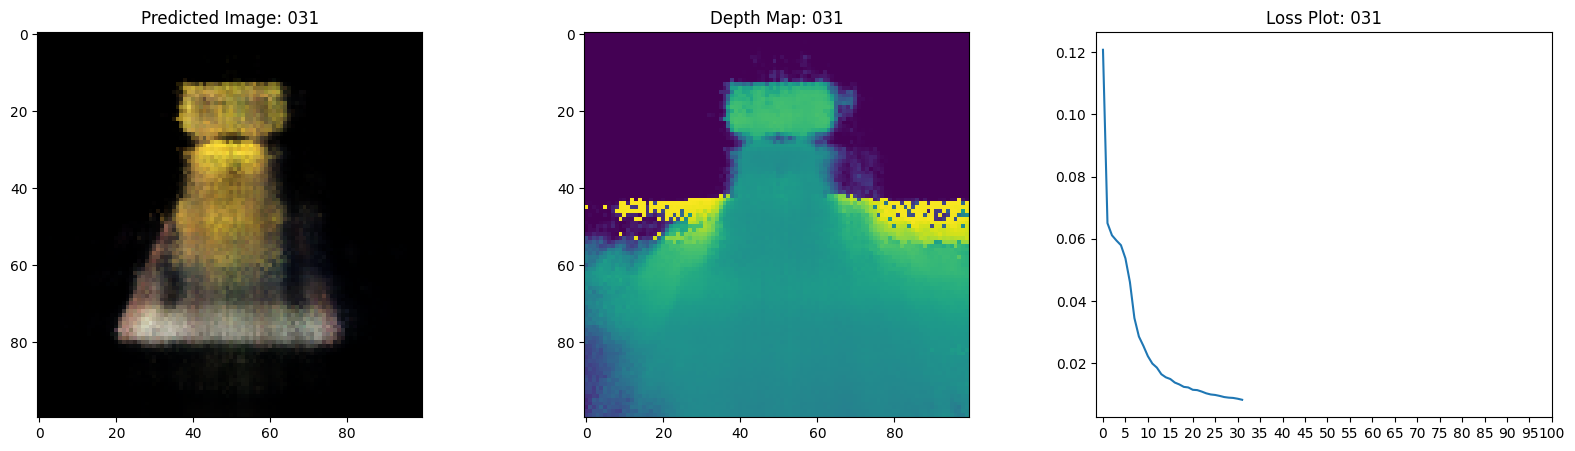

16/16 [==============================] - 23s 1s/step - loss: 0.0082 - psnr: 20.9742 - val_loss: 0.0086 - val_psnr: 20.7457
Epoch 33/100
1/1 [==============================] - 1s 746ms/steposs: 0.0082 - psnr: 21.00


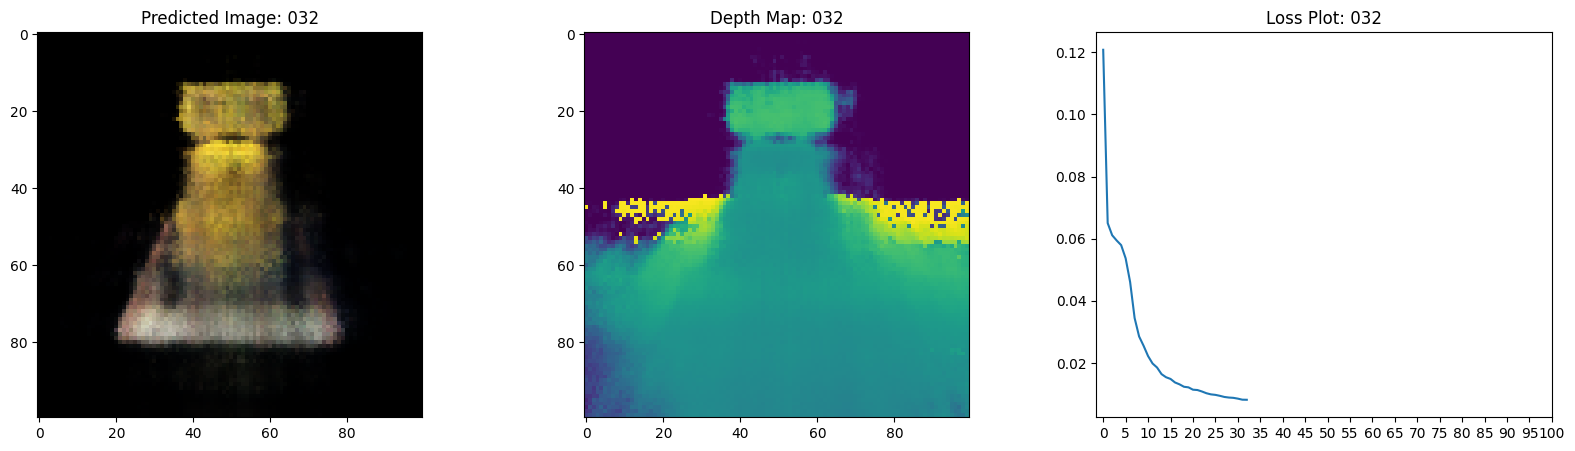

16/16 [==============================] - 23s 1s/step - loss: 0.0082 - psnr: 21.0023 - val_loss: 0.0083 - val_psnr: 20.9088
Epoch 34/100
1/1 [==============================] - 1s 745ms/steposs: 0.0081 - psnr: 21.03


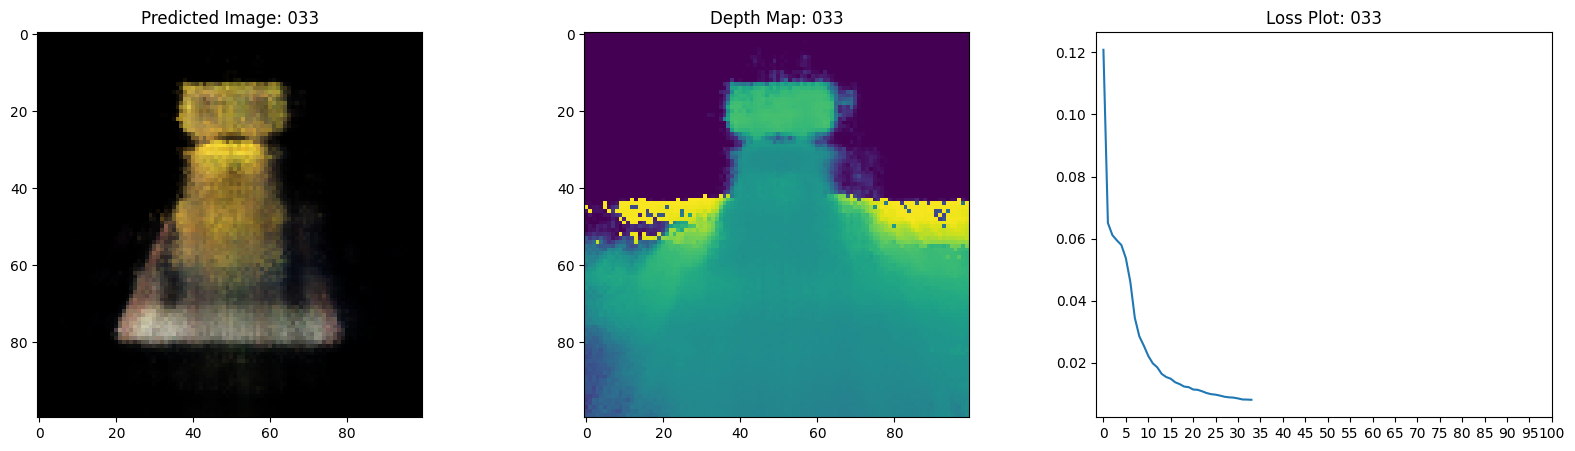

16/16 [==============================] - 24s 1s/step - loss: 0.0081 - psnr: 21.0301 - val_loss: 0.0081 - val_psnr: 21.0484
Epoch 35/100
1/1 [==============================] - 1s 732ms/steposs: 0.0079 - psnr: 21.15


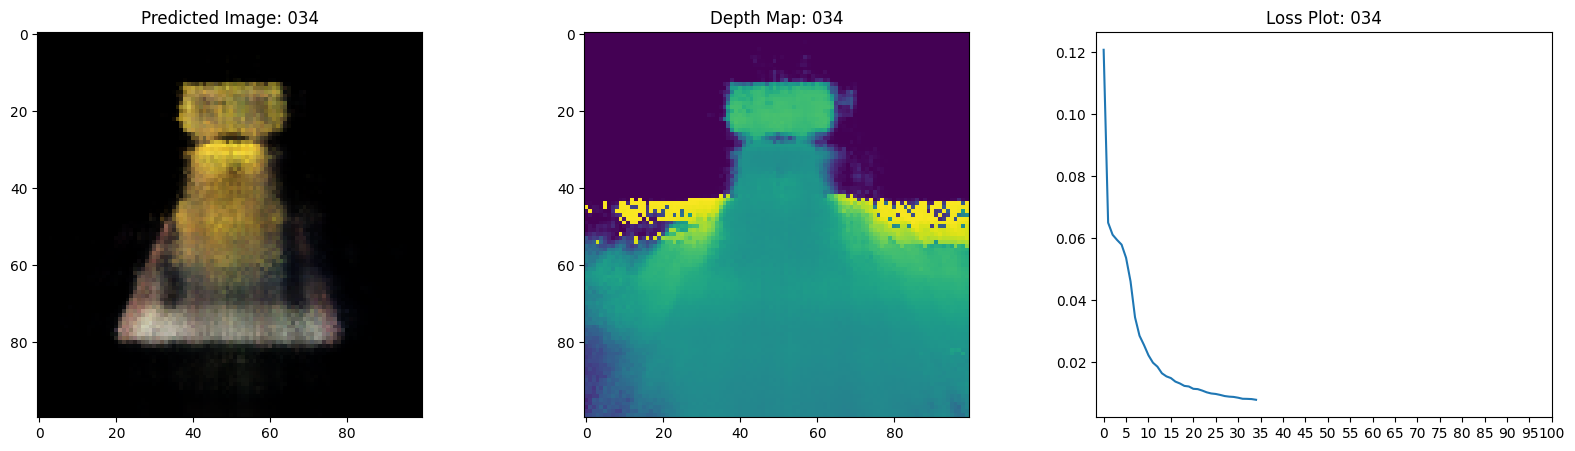

16/16 [==============================] - 24s 1s/step - loss: 0.0079 - psnr: 21.1564 - val_loss: 0.0080 - val_psnr: 21.0242
Epoch 36/100
1/1 [==============================] - 1s 740ms/steposs: 0.0078 - psnr: 21.20


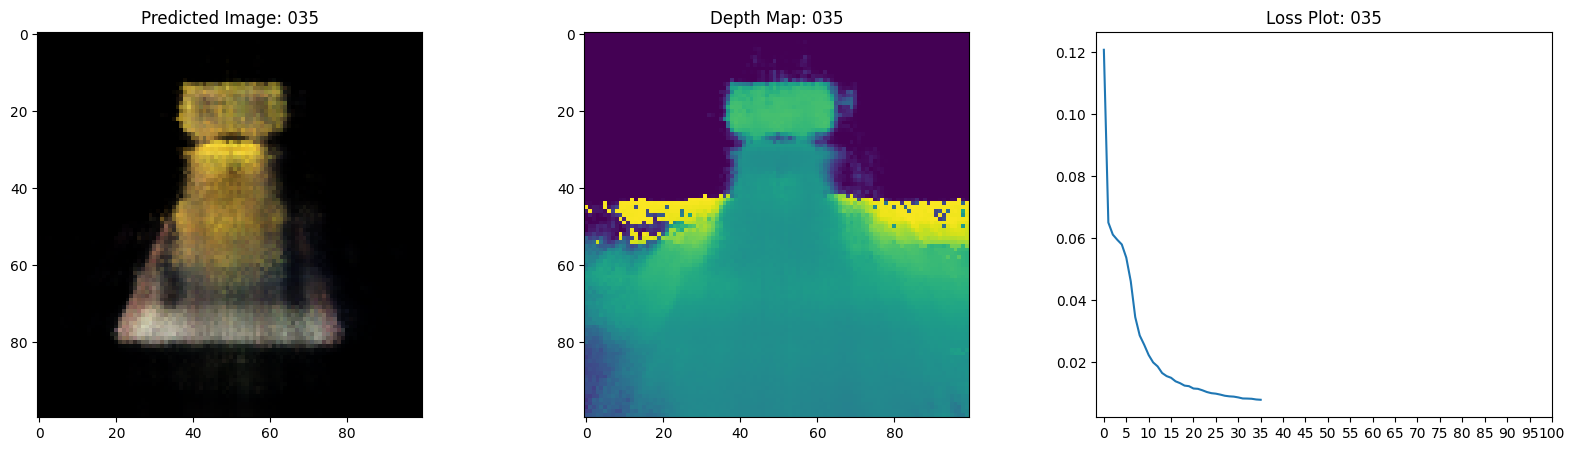

16/16 [==============================] - 23s 1s/step - loss: 0.0078 - psnr: 21.2085 - val_loss: 0.0079 - val_psnr: 21.1615
Epoch 37/100
1/1 [==============================] - 1s 741ms/steposs: 0.0075 - psnr: 21.36


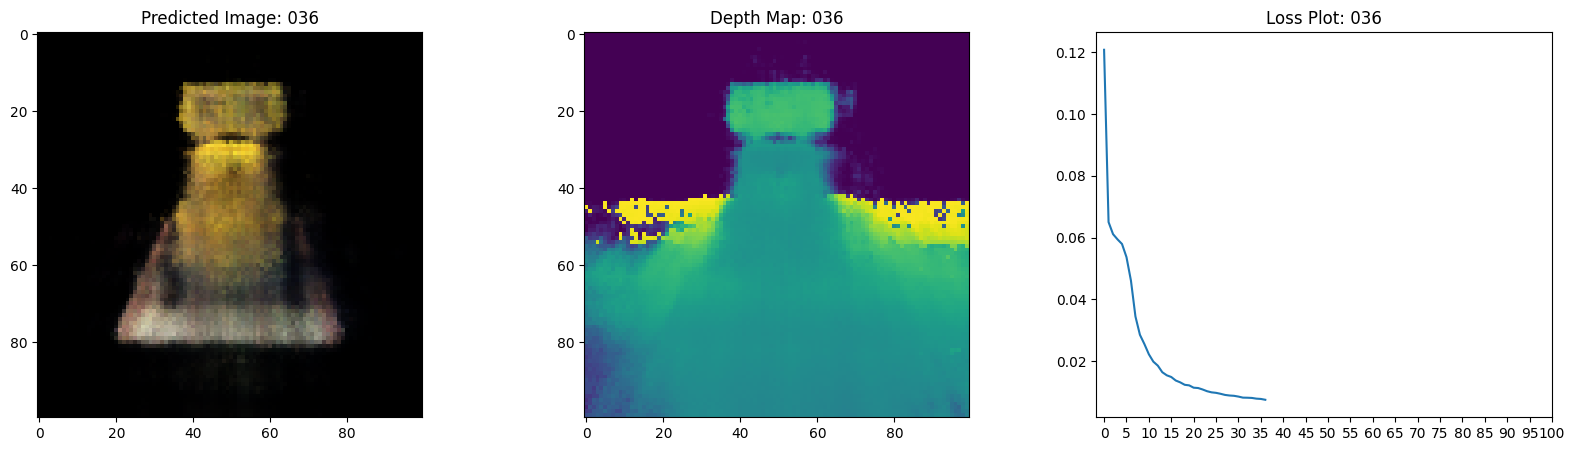

16/16 [==============================] - 23s 1s/step - loss: 0.0075 - psnr: 21.3696 - val_loss: 0.0076 - val_psnr: 21.3256
Epoch 38/100
1/1 [==============================] - 1s 751ms/steposs: 0.0075 - psnr: 21.41


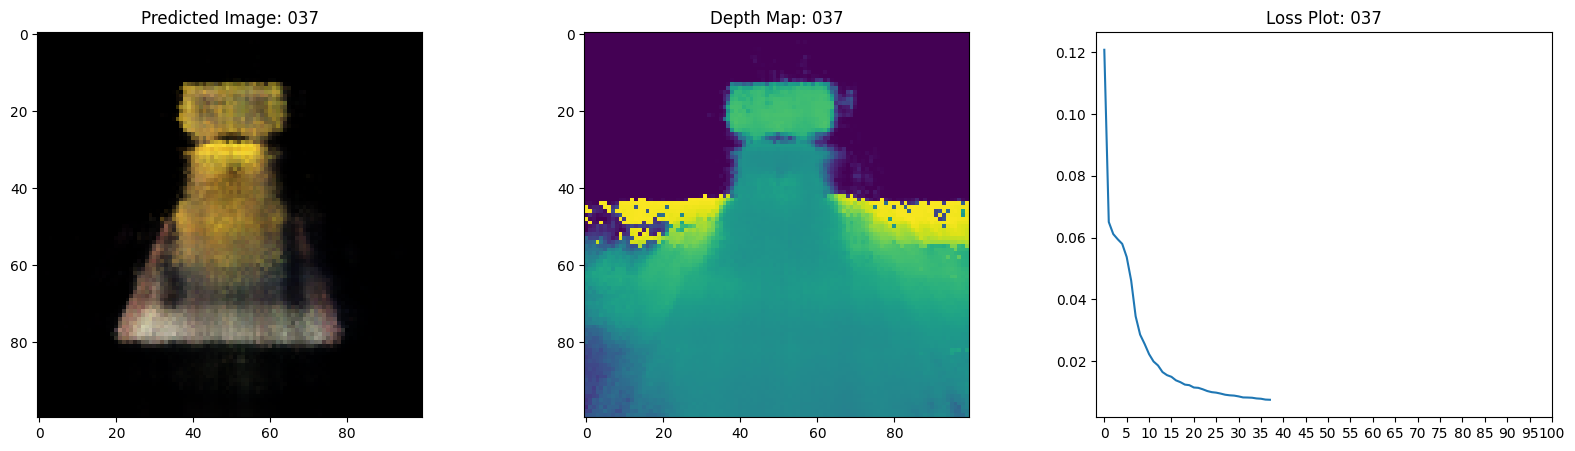

16/16 [==============================] - 23s 1s/step - loss: 0.0075 - psnr: 21.4105 - val_loss: 0.0077 - val_psnr: 21.2352
Epoch 39/100
1/1 [==============================] - 1s 739ms/steposs: 0.0073 - psnr: 21.49


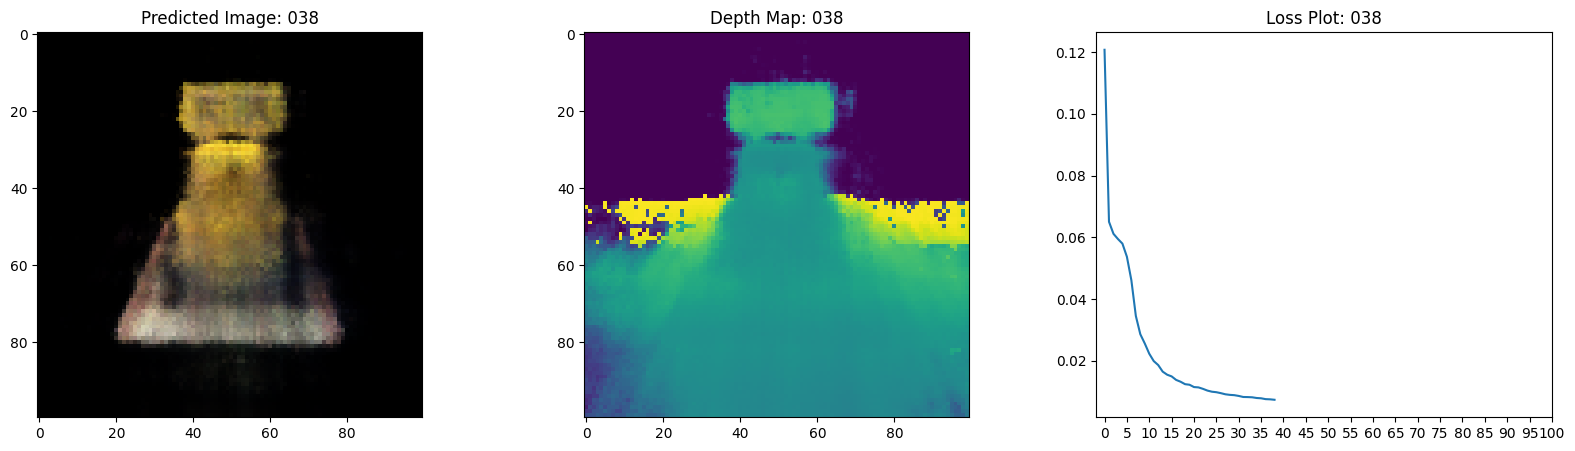

16/16 [==============================] - 23s 1s/step - loss: 0.0073 - psnr: 21.4916 - val_loss: 0.0075 - val_psnr: 21.3773
Epoch 40/100
1/1 [==============================] - 1s 742ms/steposs: 0.0074 - psnr: 21.44


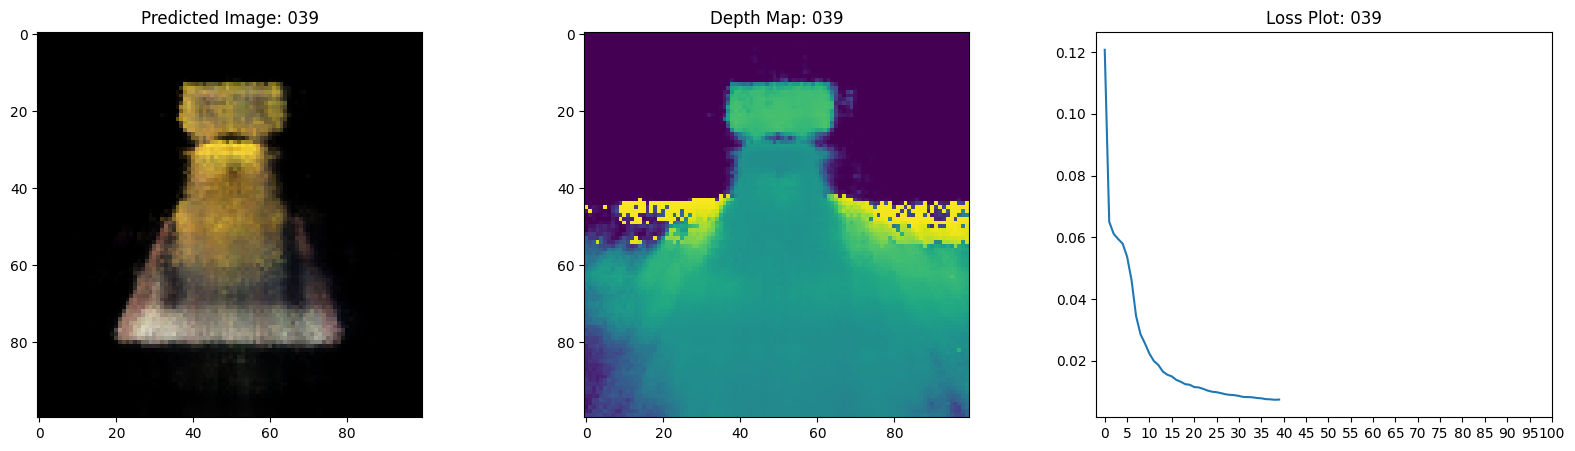

16/16 [==============================] - 23s 1s/step - loss: 0.0074 - psnr: 21.4419 - val_loss: 0.0077 - val_psnr: 21.1773
Epoch 41/100
1/1 [==============================] - 1s 737ms/steposs: 0.0072 - psnr: 21.55


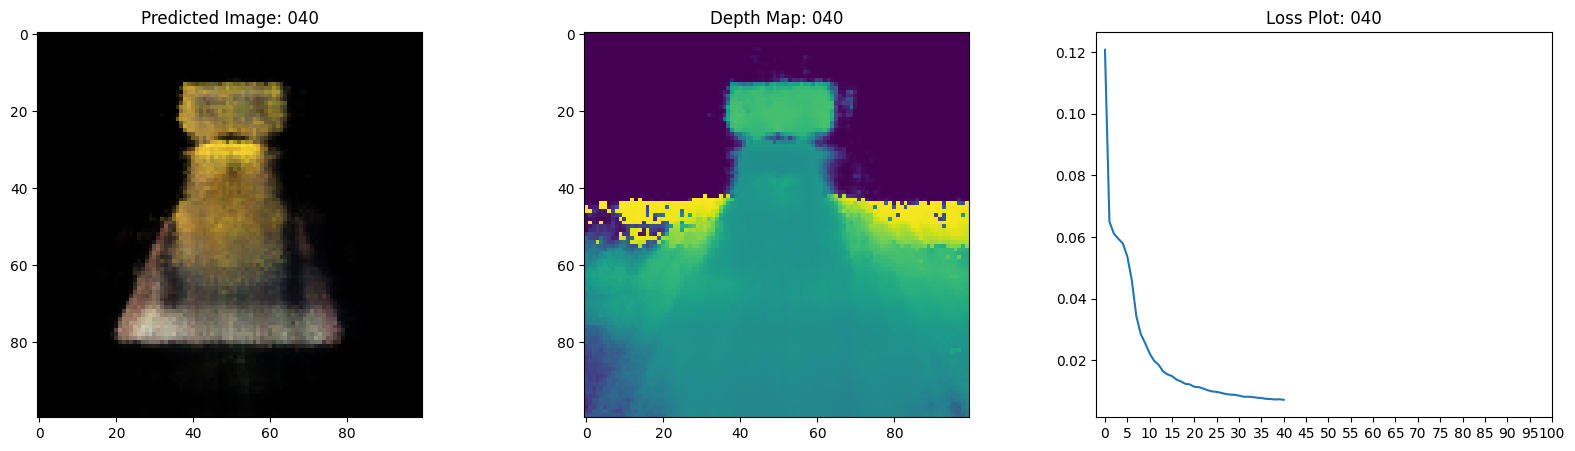

16/16 [==============================] - 23s 1s/step - loss: 0.0072 - psnr: 21.5539 - val_loss: 0.0075 - val_psnr: 21.2873
Epoch 42/100
1/1 [==============================] - 1s 739ms/steposs: 0.0070 - psnr: 21.67


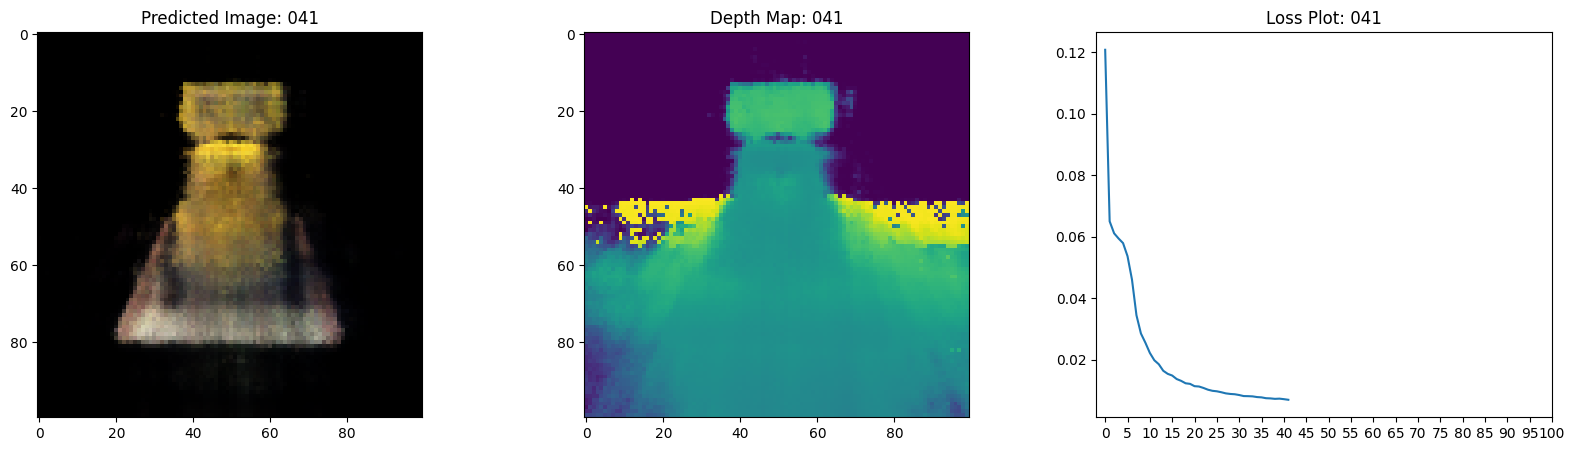

16/16 [==============================] - 23s 1s/step - loss: 0.0070 - psnr: 21.6710 - val_loss: 0.0074 - val_psnr: 21.4387
Epoch 43/100
1/1 [==============================] - 1s 749ms/steposs: 0.0070 - psnr: 21.68


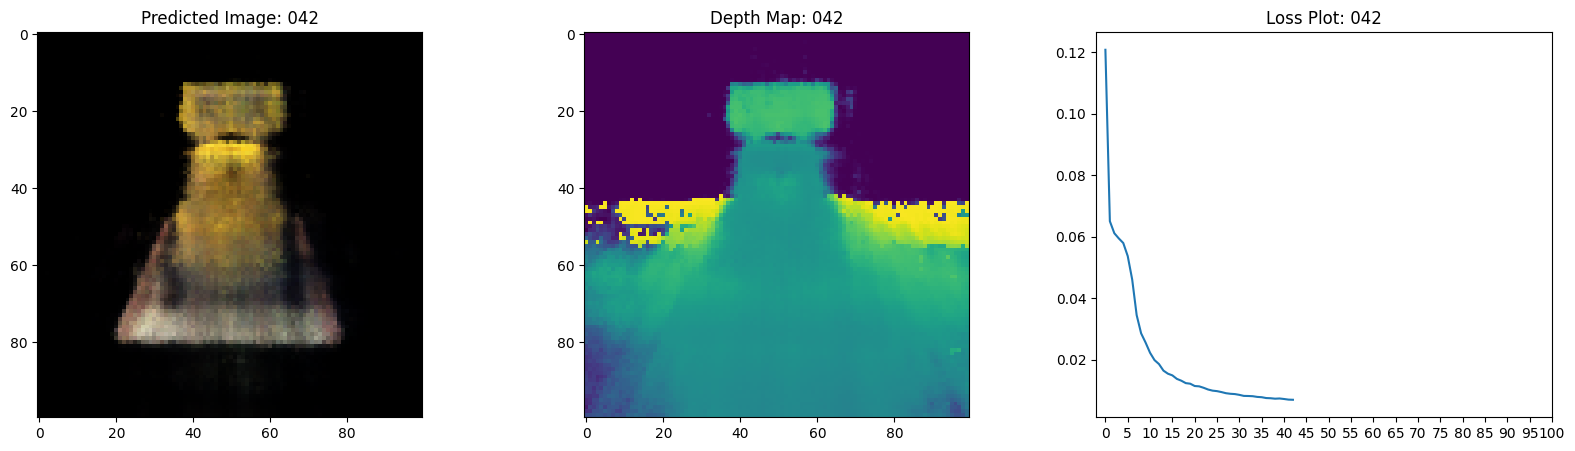

16/16 [==============================] - 23s 1s/step - loss: 0.0070 - psnr: 21.6867 - val_loss: 0.0071 - val_psnr: 21.5789
Epoch 44/100
1/1 [==============================] - 1s 739ms/steposs: 0.0068 - psnr: 21.80


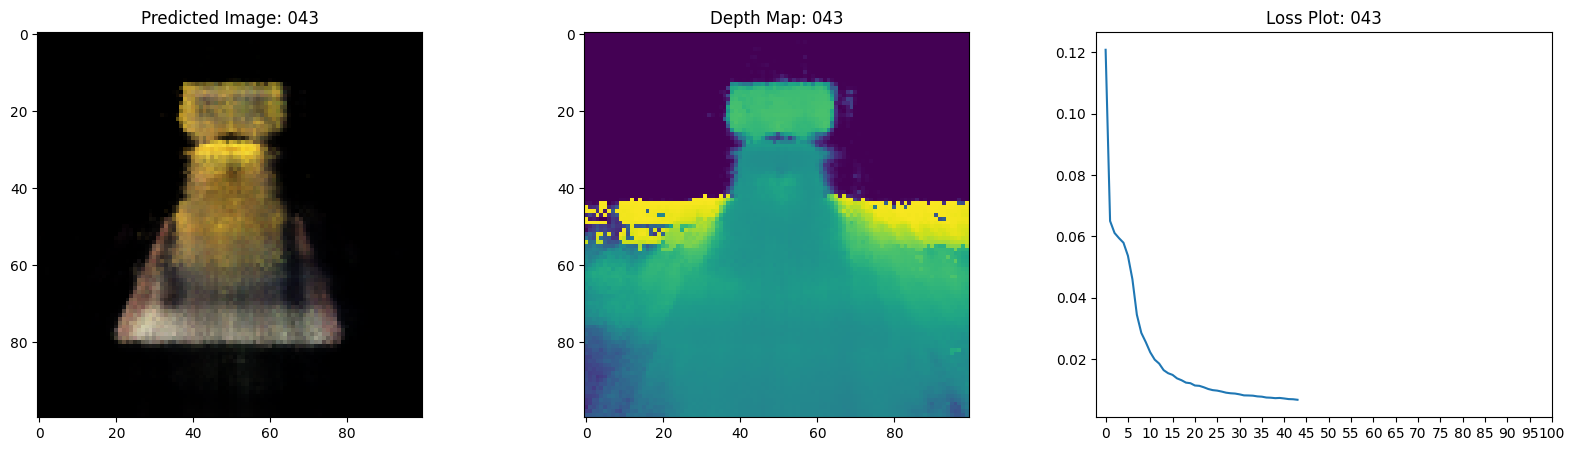

16/16 [==============================] - 23s 1s/step - loss: 0.0068 - psnr: 21.8046 - val_loss: 0.0071 - val_psnr: 21.6117
Epoch 45/100
1/1 [==============================] - 1s 743ms/steposs: 0.0068 - psnr: 21.81


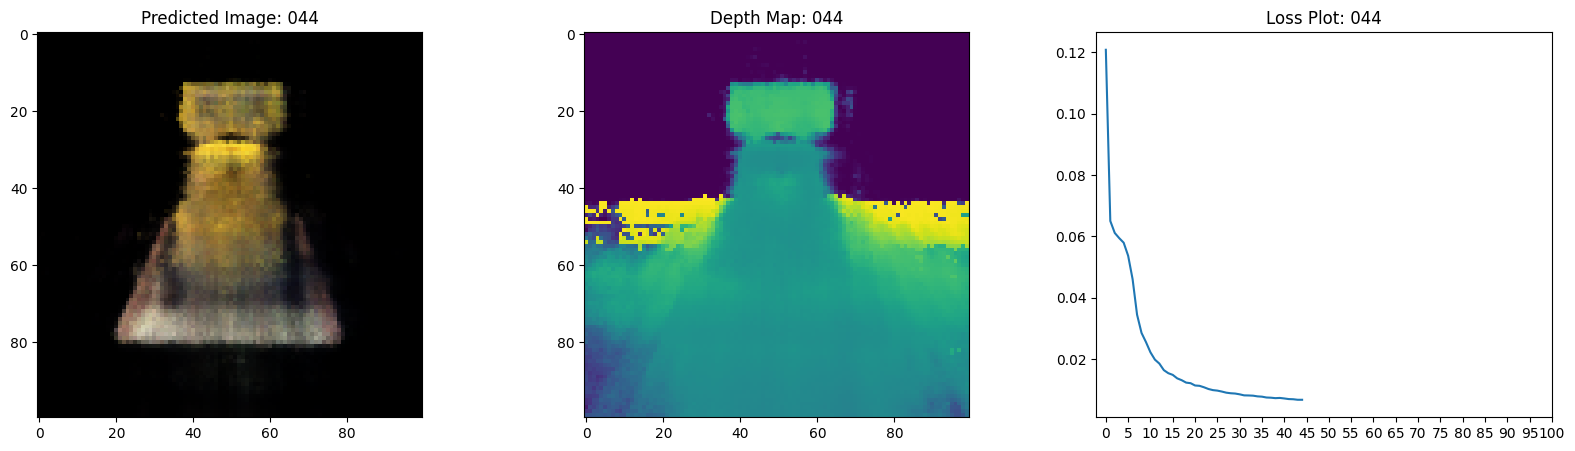

16/16 [==============================] - 23s 1s/step - loss: 0.0068 - psnr: 21.8116 - val_loss: 0.0071 - val_psnr: 21.5906
Epoch 46/100
1/1 [==============================] - 1s 744ms/steposs: 0.0069 - psnr: 21.76


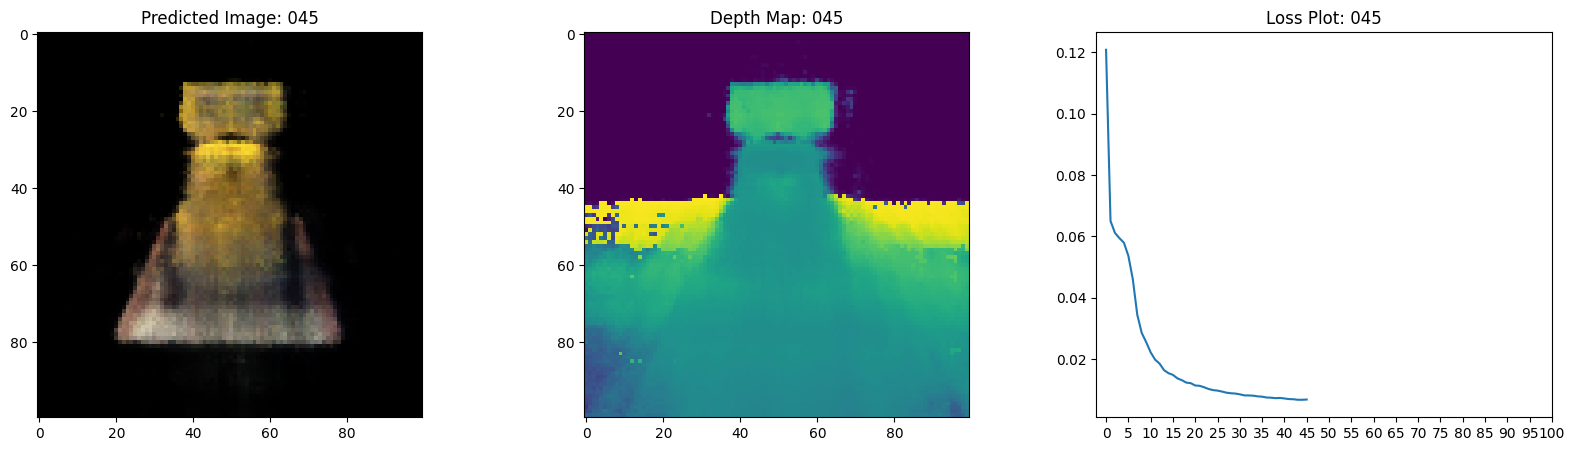

16/16 [==============================] - 23s 1s/step - loss: 0.0069 - psnr: 21.7612 - val_loss: 0.0069 - val_psnr: 21.7036
Epoch 47/100
1/1 [==============================] - 1s 729ms/steposs: 0.0066 - psnr: 21.98


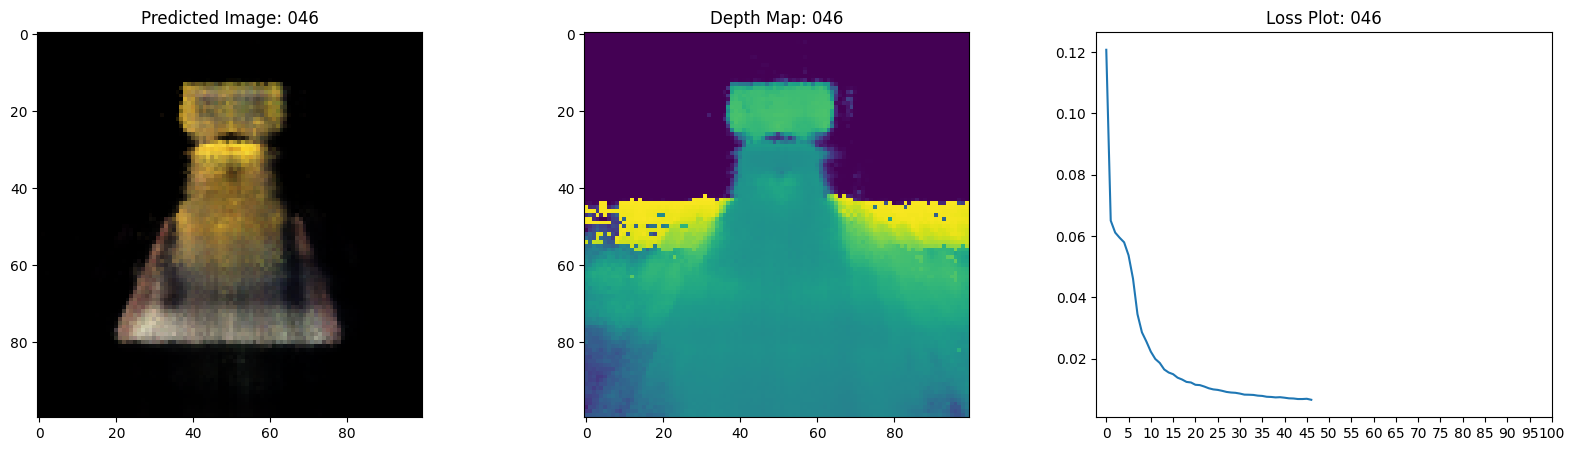

16/16 [==============================] - 23s 1s/step - loss: 0.0066 - psnr: 21.9811 - val_loss: 0.0065 - val_psnr: 21.9722
Epoch 48/100
1/1 [==============================] - 1s 1s/step- loss: 0.0065 - psnr: 22.05


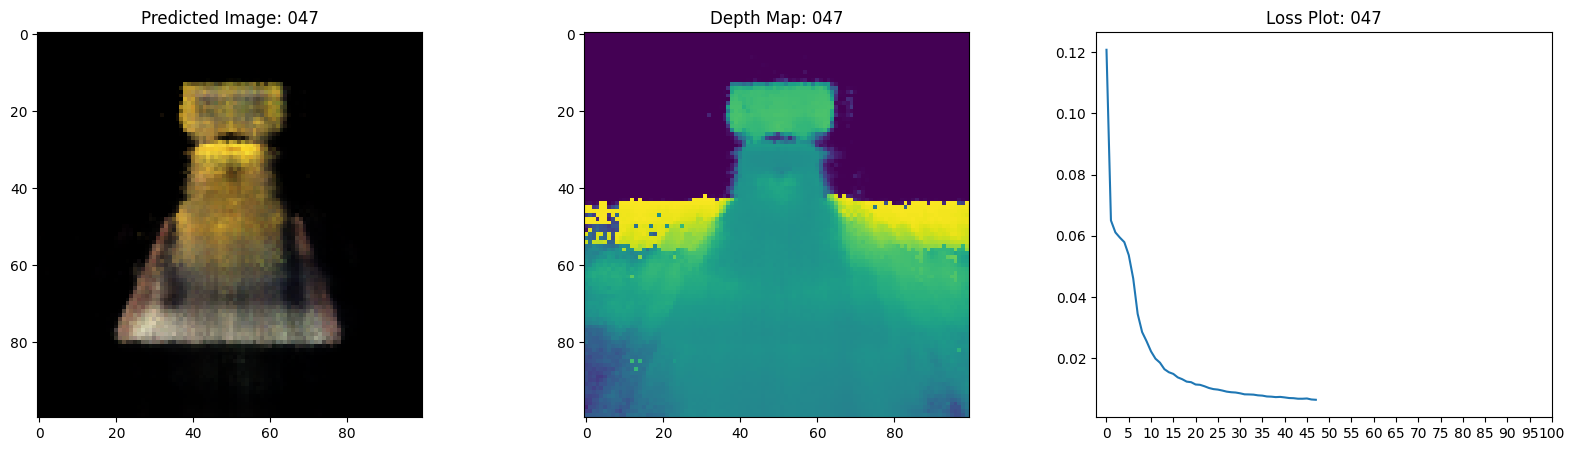

16/16 [==============================] - 24s 1s/step - loss: 0.0065 - psnr: 22.0545 - val_loss: 0.0066 - val_psnr: 21.9319
Epoch 49/100
1/1 [==============================] - 1s 739ms/steposs: 0.0064 - psnr: 22.06


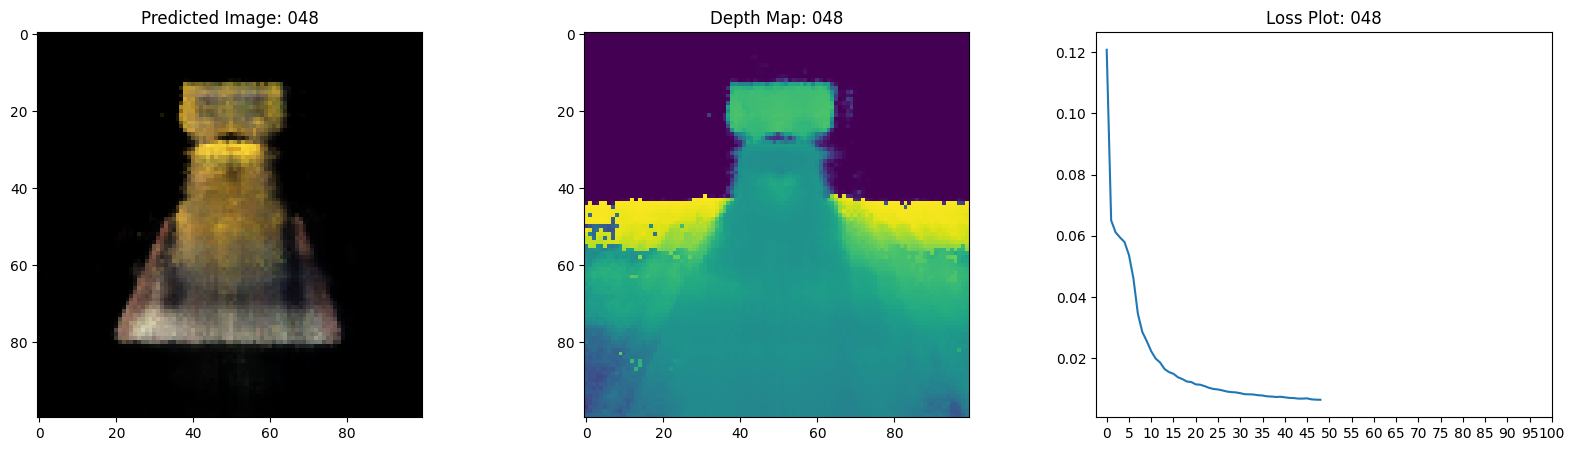

16/16 [==============================] - 25s 1s/step - loss: 0.0064 - psnr: 22.0683 - val_loss: 0.0066 - val_psnr: 21.9044
Epoch 50/100
1/1 [==============================] - 1s 1s/step- loss: 0.0063 - psnr: 22.15


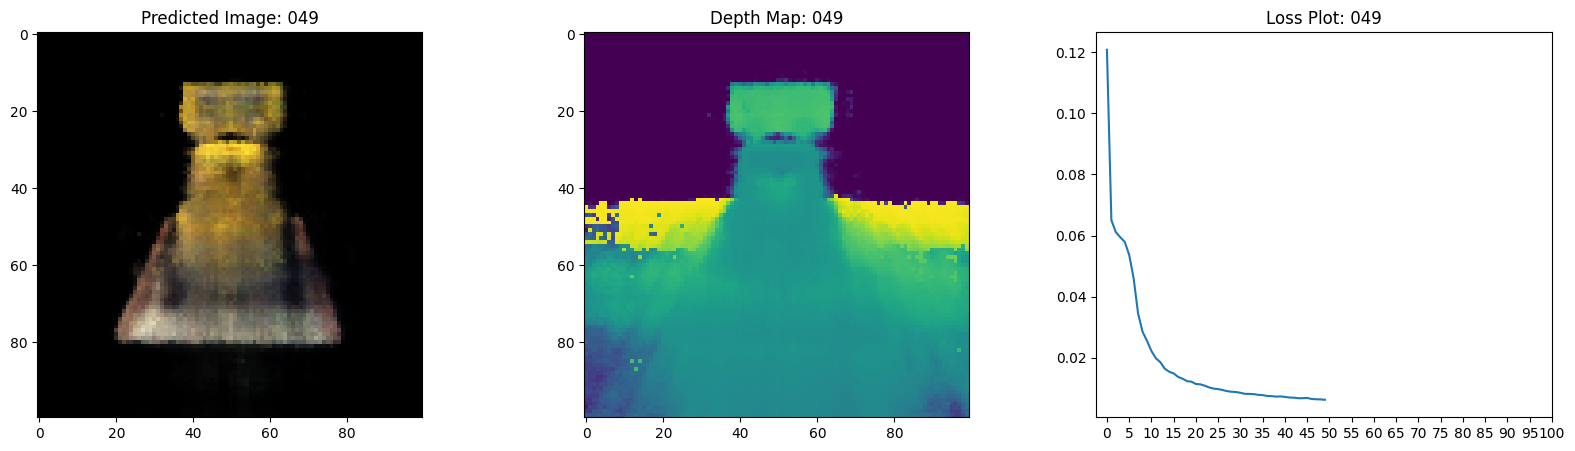

16/16 [==============================] - 24s 1s/step - loss: 0.0063 - psnr: 22.1574 - val_loss: 0.0066 - val_psnr: 21.8575
Epoch 51/100
1/1 [==============================] - 1s 745ms/steposs: 0.0062 - psnr: 22.18


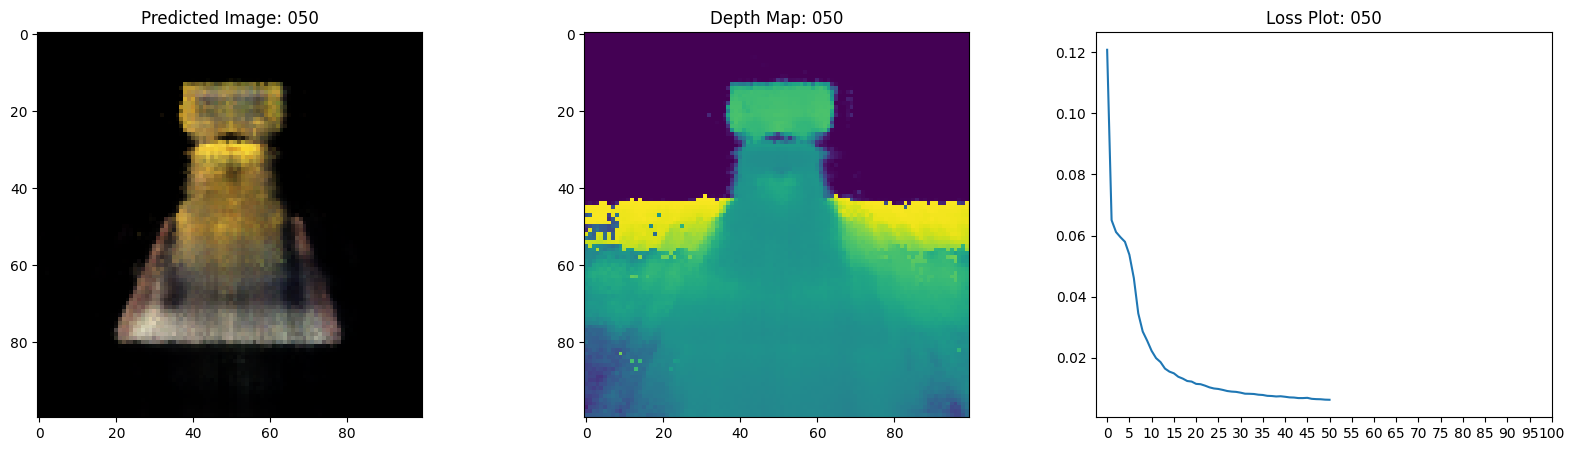

16/16 [==============================] - 25s 1s/step - loss: 0.0062 - psnr: 22.1824 - val_loss: 0.0065 - val_psnr: 21.9948
Epoch 52/100
1/1 [==============================] - 1s 750ms/steposs: 0.0061 - psnr: 22.26


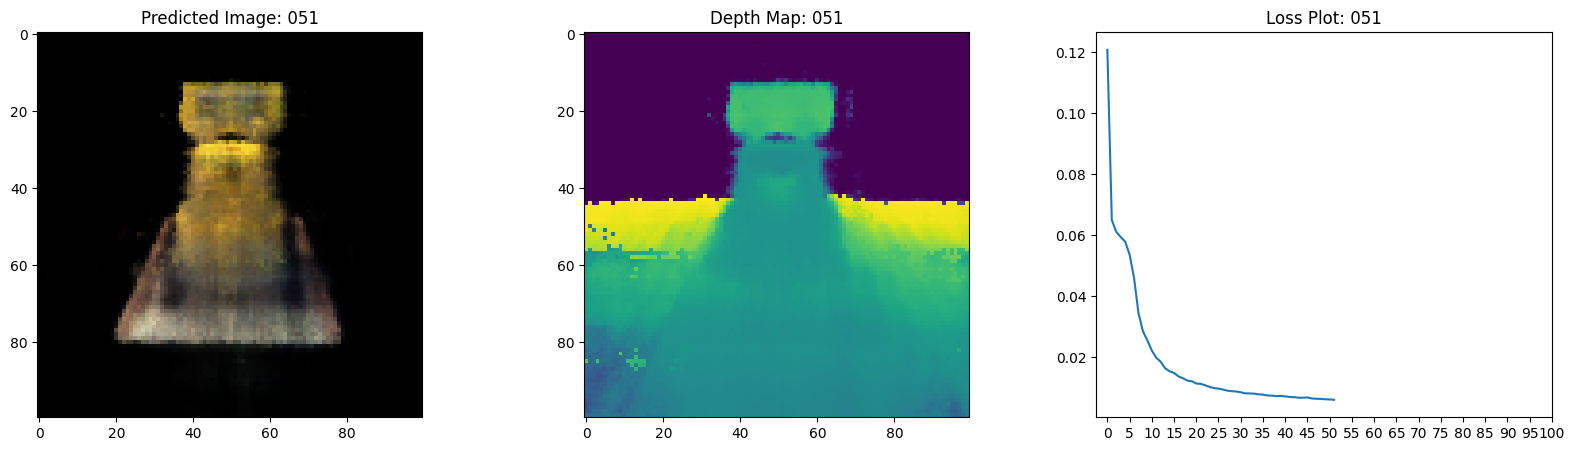

16/16 [==============================] - 23s 1s/step - loss: 0.0061 - psnr: 22.2685 - val_loss: 0.0064 - val_psnr: 22.0379
Epoch 53/100
1/1 [==============================] - 1s 745ms/steposs: 0.0061 - psnr: 22.29


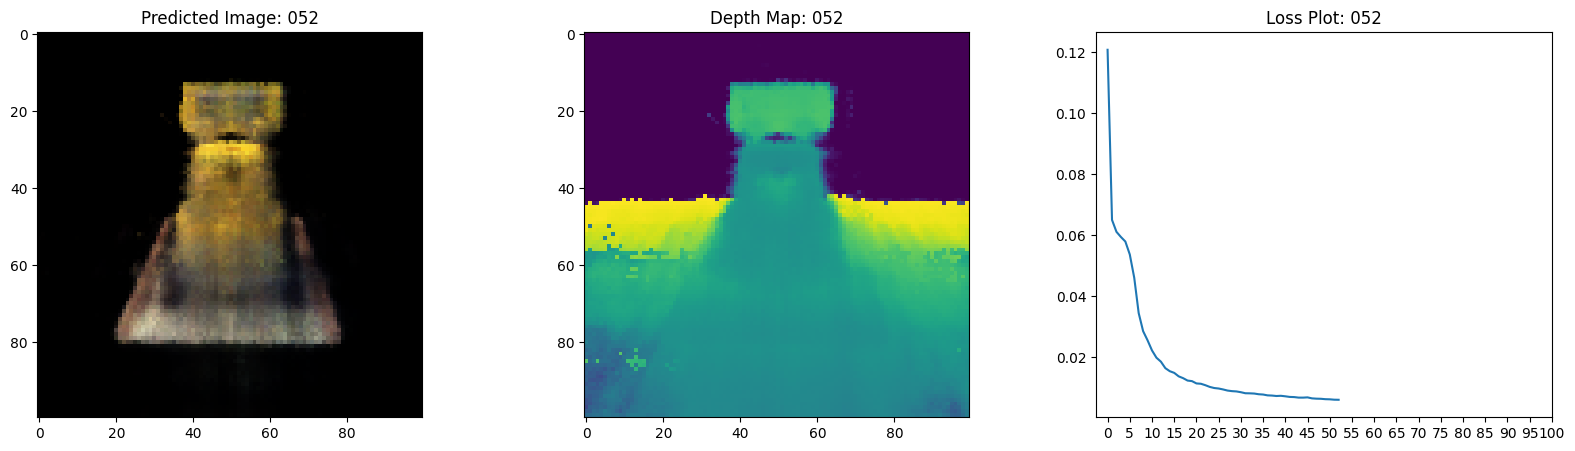

16/16 [==============================] - 24s 1s/step - loss: 0.0061 - psnr: 22.2932 - val_loss: 0.0062 - val_psnr: 22.1776
Epoch 54/100
1/1 [==============================] - 1s 747ms/steposs: 0.0060 - psnr: 22.33


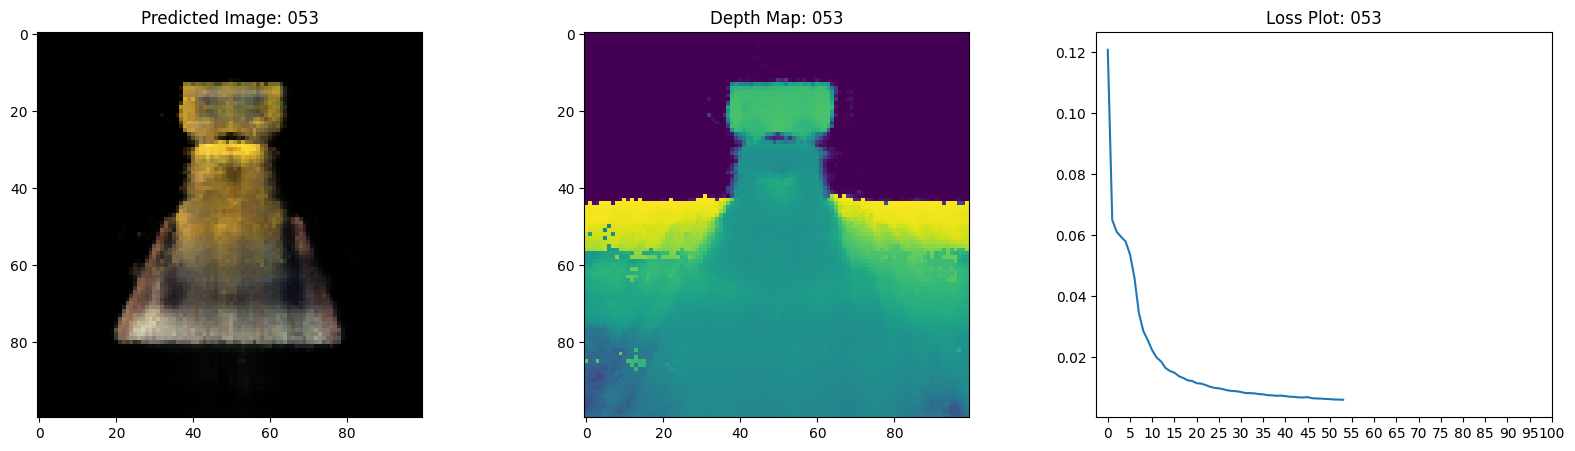

16/16 [==============================] - 24s 1s/step - loss: 0.0060 - psnr: 22.3301 - val_loss: 0.0063 - val_psnr: 22.1115
Epoch 55/100
1/1 [==============================] - 1s 740ms/steposs: 0.0060 - psnr: 22.33


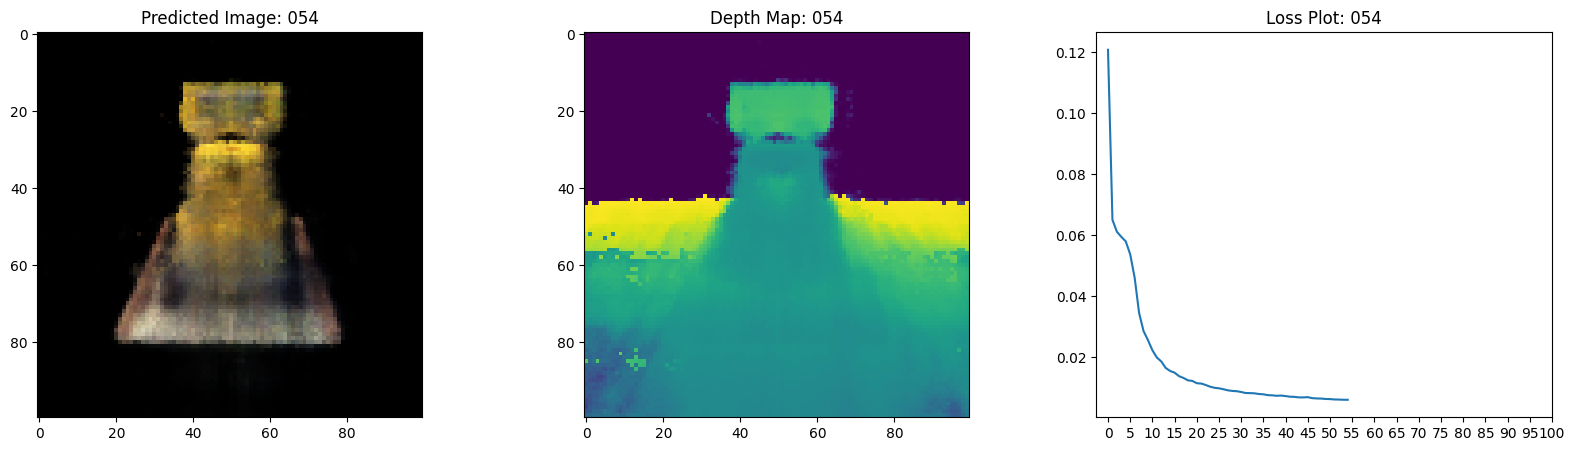

16/16 [==============================] - 23s 1s/step - loss: 0.0060 - psnr: 22.3317 - val_loss: 0.0063 - val_psnr: 22.0916
Epoch 56/100
1/1 [==============================] - 1s 747ms/steposs: 0.0059 - psnr: 22.41


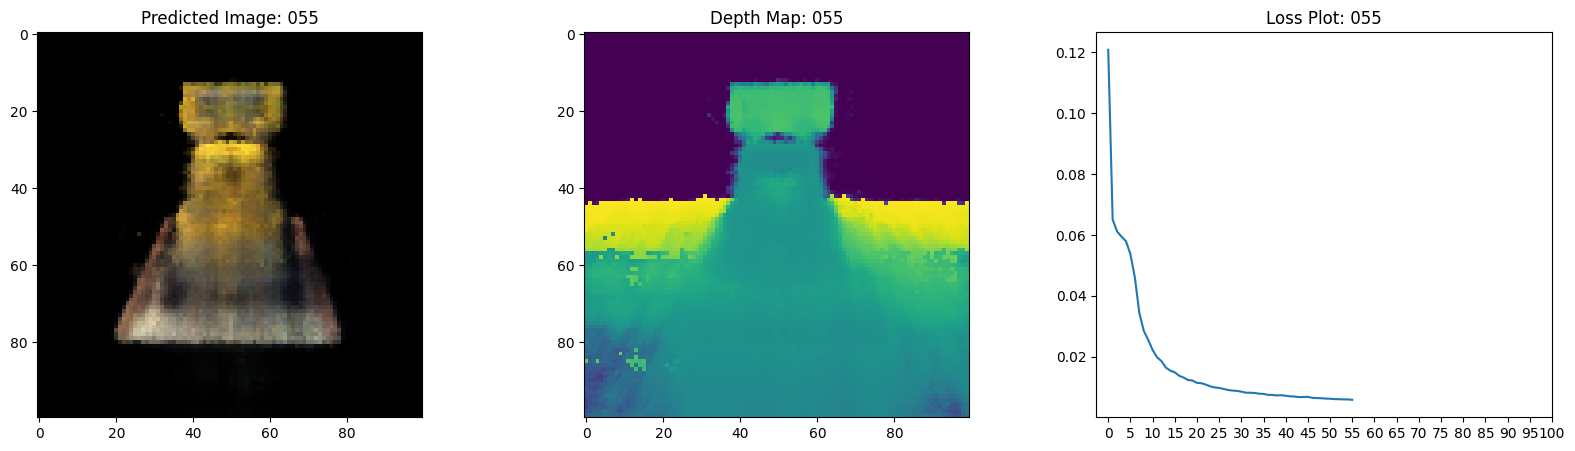

16/16 [==============================] - 24s 1s/step - loss: 0.0059 - psnr: 22.4159 - val_loss: 0.0060 - val_psnr: 22.2746
Epoch 57/100
1/1 [==============================] - 1s 735ms/steposs: 0.0058 - psnr: 22.50


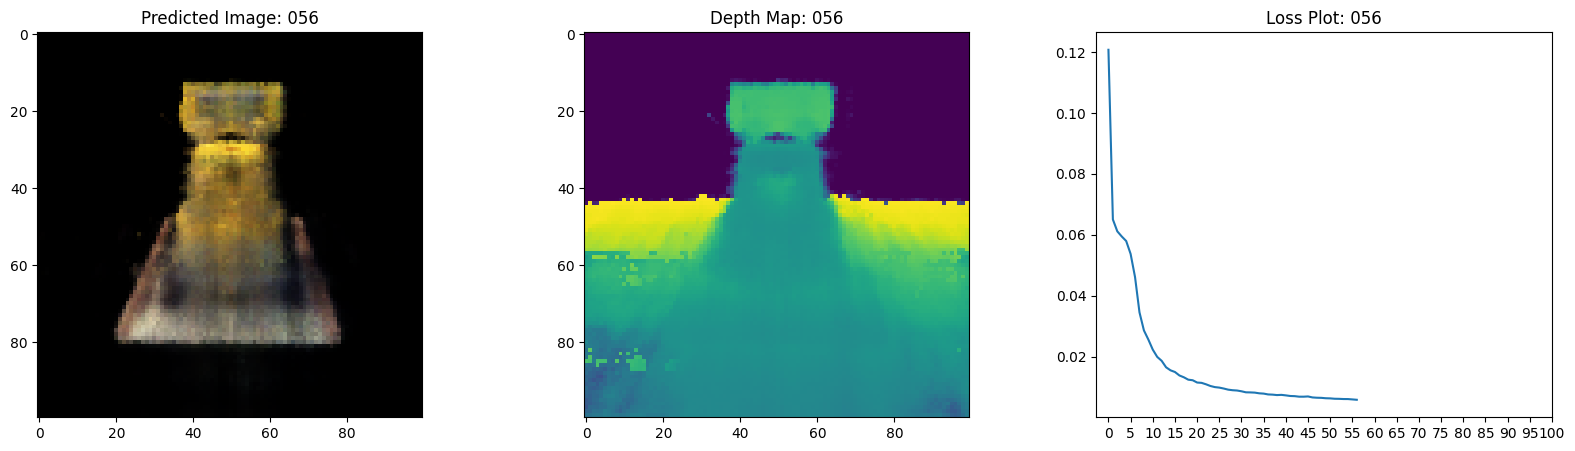

16/16 [==============================] - 24s 1s/step - loss: 0.0058 - psnr: 22.5089 - val_loss: 0.0060 - val_psnr: 22.3049
Epoch 58/100
1/1 [==============================] - 1s 751ms/steposs: 0.0058 - psnr: 22.46


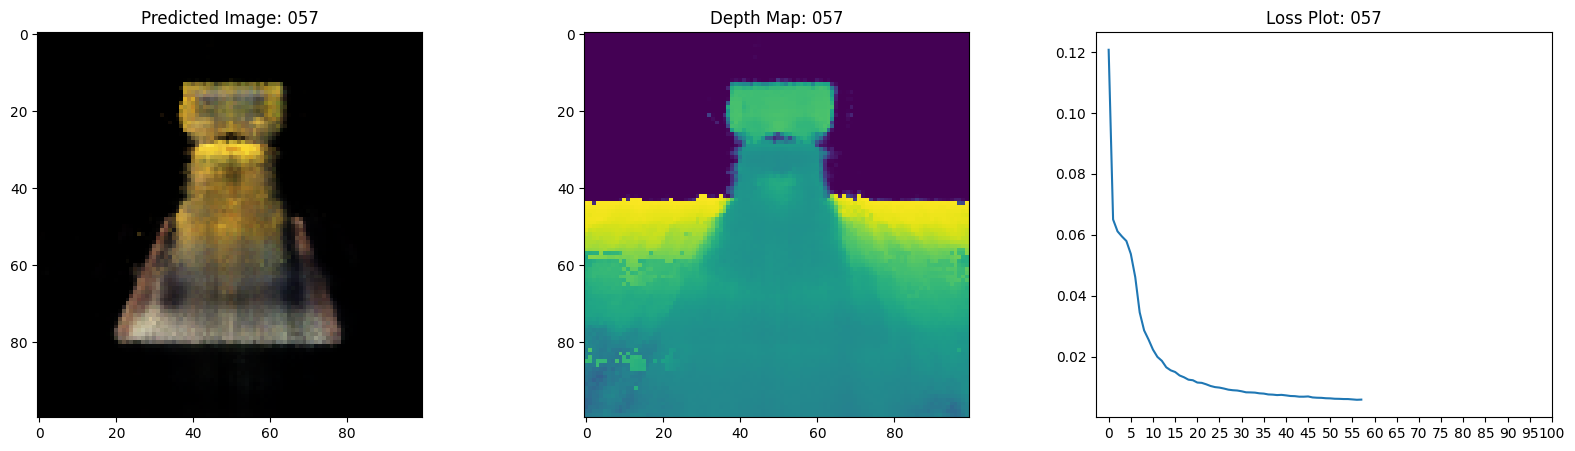

16/16 [==============================] - 24s 1s/step - loss: 0.0058 - psnr: 22.4671 - val_loss: 0.0061 - val_psnr: 22.1942
Epoch 59/100
1/1 [==============================] - 1s 764ms/steposs: 0.0058 - psnr: 22.53


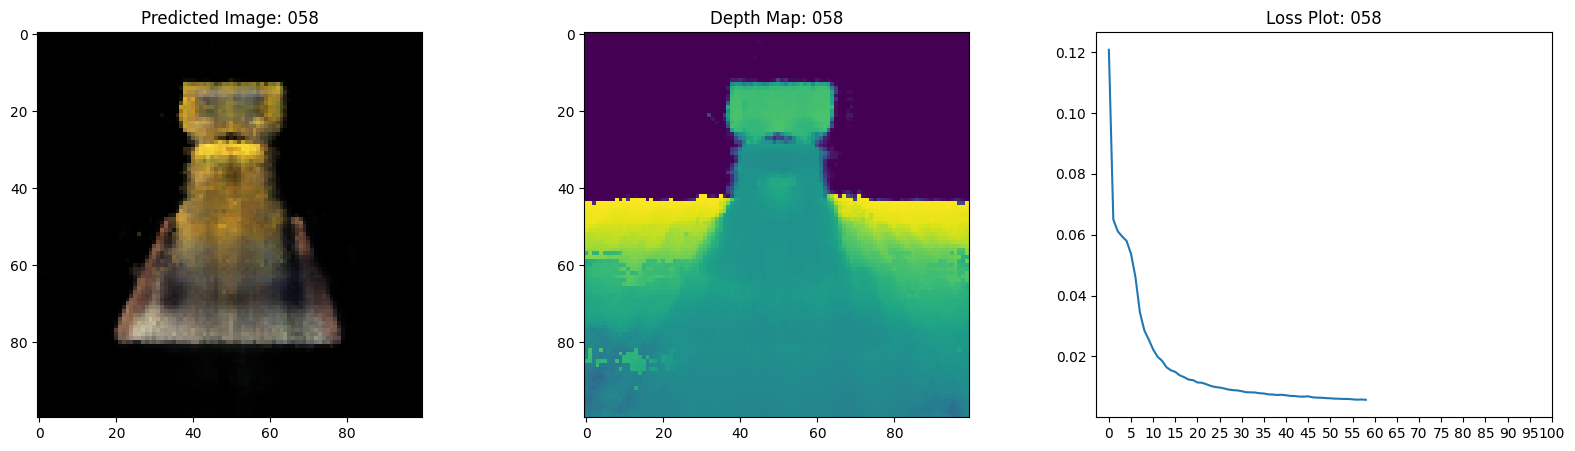

16/16 [==============================] - 24s 1s/step - loss: 0.0058 - psnr: 22.5376 - val_loss: 0.0061 - val_psnr: 22.2474
Epoch 60/100
1/1 [==============================] - 1s 735ms/steposs: 0.0057 - psnr: 22.54


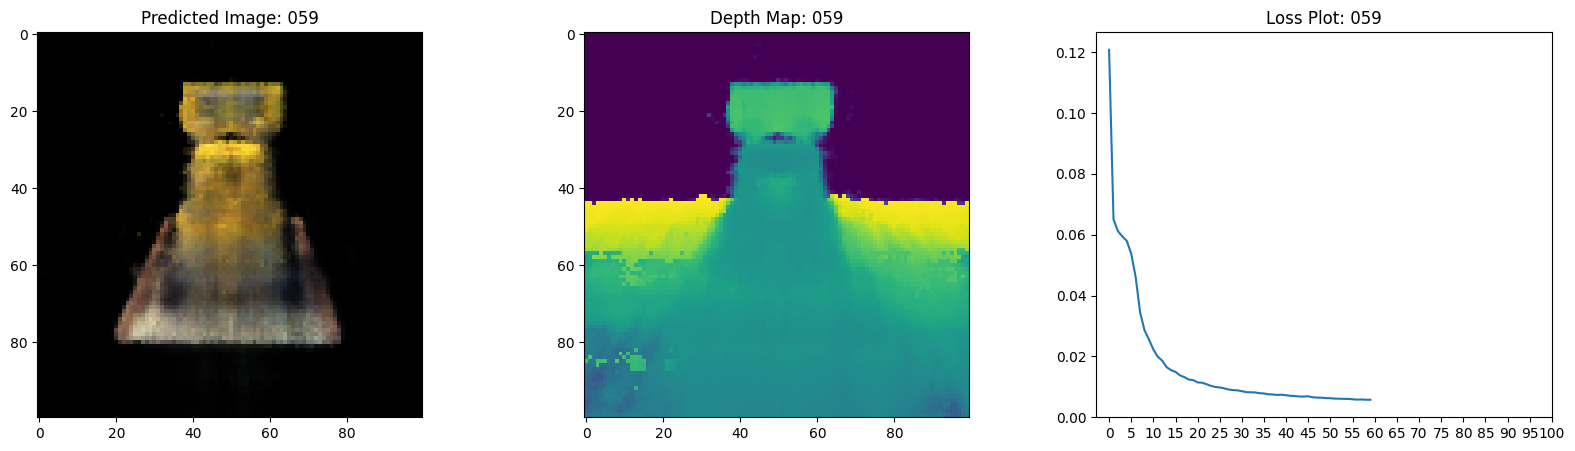

16/16 [==============================] - 23s 1s/step - loss: 0.0057 - psnr: 22.5445 - val_loss: 0.0059 - val_psnr: 22.3418
Epoch 61/100
1/1 [==============================] - 1s 752ms/steposs: 0.0057 - psnr: 22.60


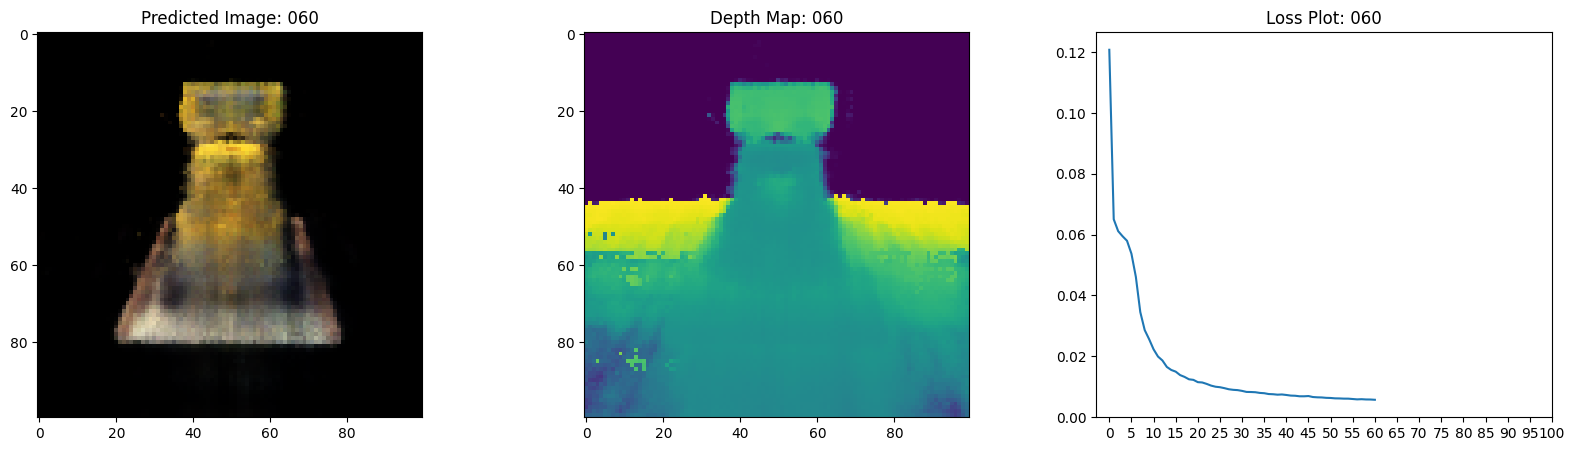

16/16 [==============================] - 24s 1s/step - loss: 0.0057 - psnr: 22.6035 - val_loss: 0.0061 - val_psnr: 22.1735
Epoch 62/100
1/1 [==============================] - 1s 746ms/steposs: 0.0057 - psnr: 22.55


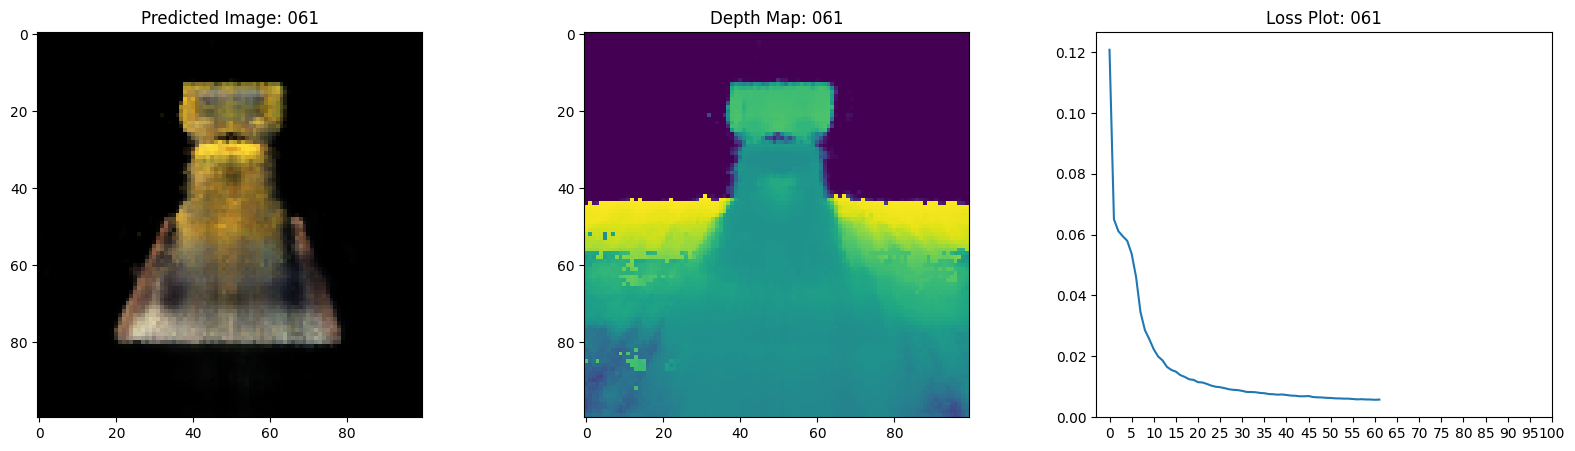

16/16 [==============================] - 24s 1s/step - loss: 0.0057 - psnr: 22.5566 - val_loss: 0.0059 - val_psnr: 22.3606
Epoch 63/100
1/1 [==============================] - 1s 751ms/steposs: 0.0056 - psnr: 22.67


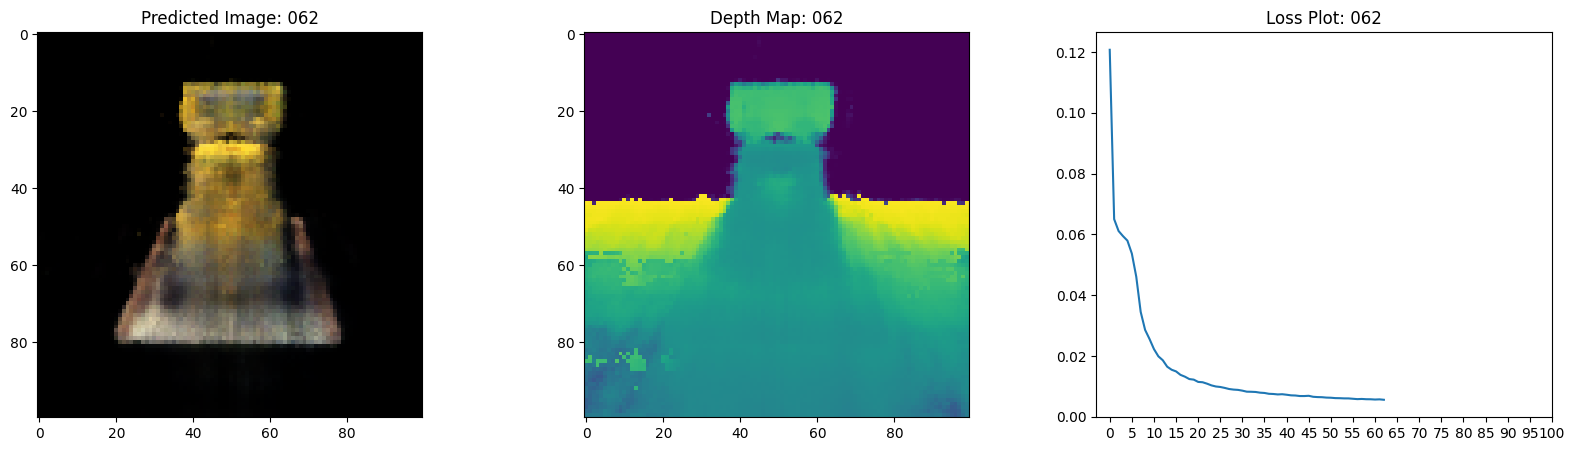

16/16 [==============================] - 23s 1s/step - loss: 0.0056 - psnr: 22.6770 - val_loss: 0.0057 - val_psnr: 22.5639
Epoch 64/100
1/1 [==============================] - 1s 743ms/steposs: 0.0055 - psnr: 22.75


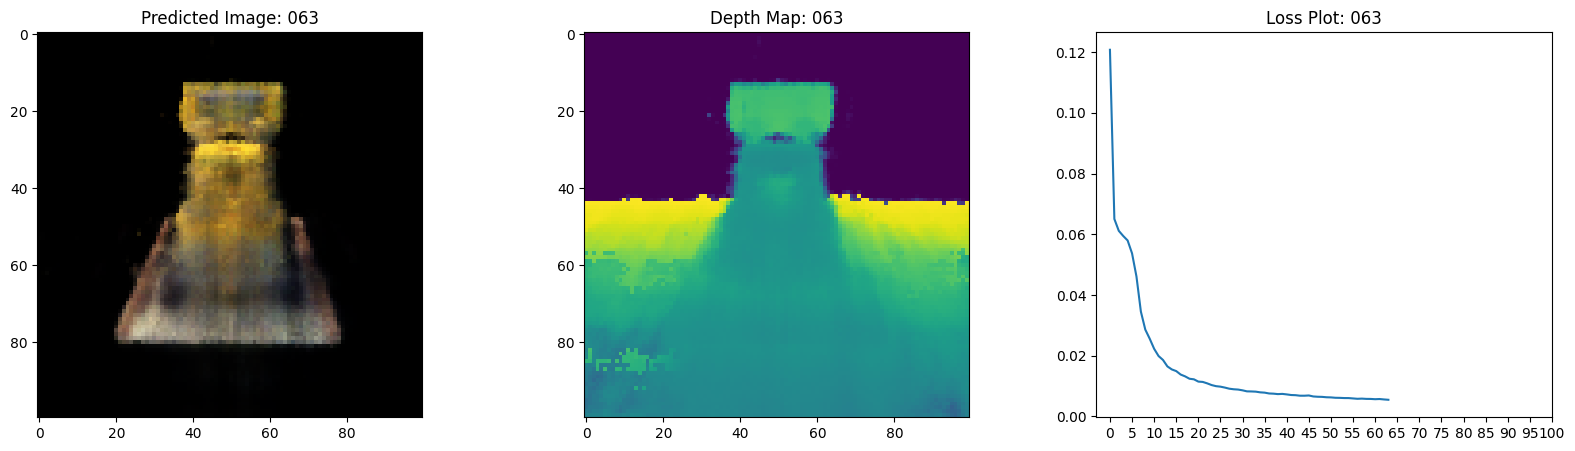

16/16 [==============================] - 23s 1s/step - loss: 0.0055 - psnr: 22.7599 - val_loss: 0.0057 - val_psnr: 22.5223
Epoch 65/100
1/1 [==============================] - 1s 753ms/steposs: 0.0054 - psnr: 22.83


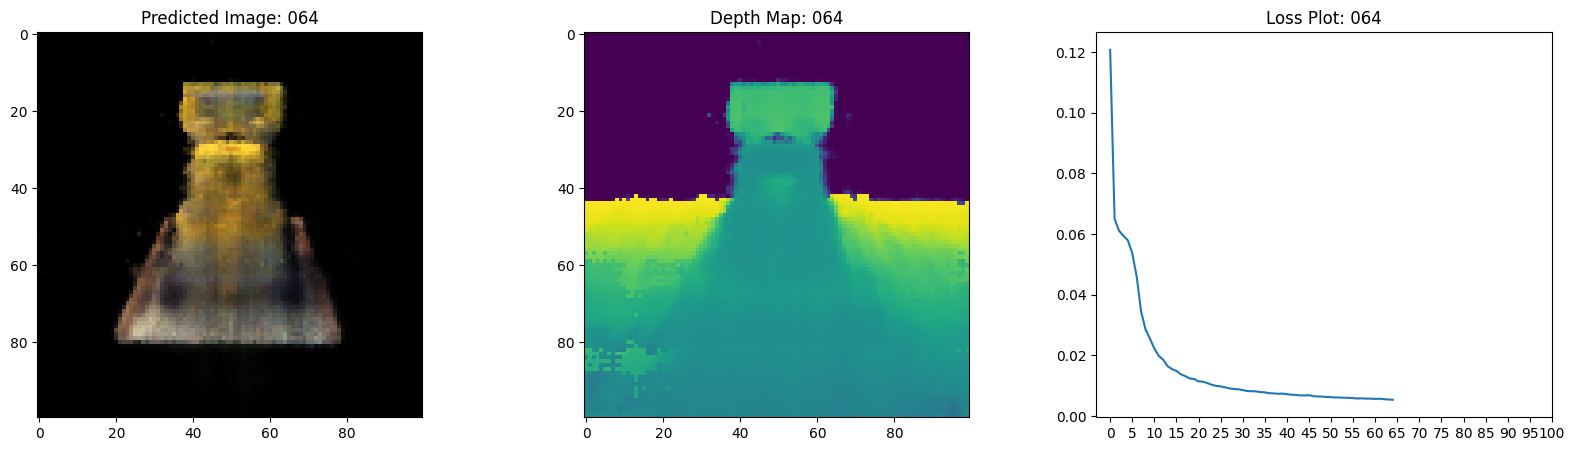

16/16 [==============================] - 24s 1s/step - loss: 0.0054 - psnr: 22.8367 - val_loss: 0.0058 - val_psnr: 22.4769
Epoch 66/100
1/1 [==============================] - 1s 749ms/steposs: 0.0053 - psnr: 22.87


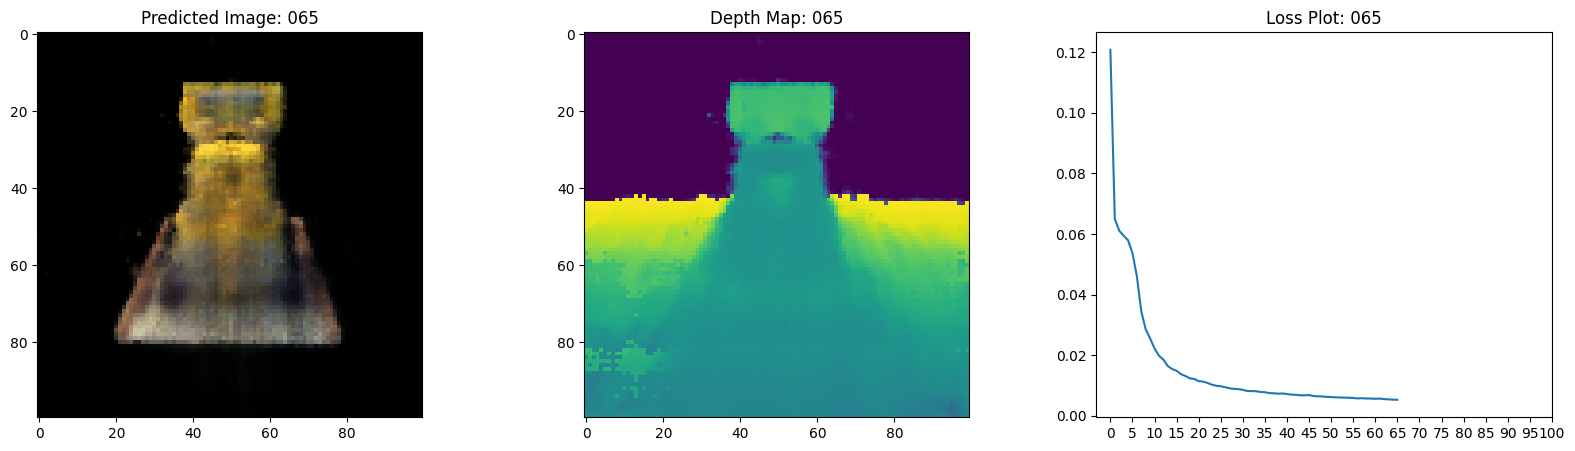

16/16 [==============================] - 23s 1s/step - loss: 0.0053 - psnr: 22.8740 - val_loss: 0.0057 - val_psnr: 22.5345
Epoch 67/100
1/1 [==============================] - 1s 744ms/steposs: 0.0054 - psnr: 22.84


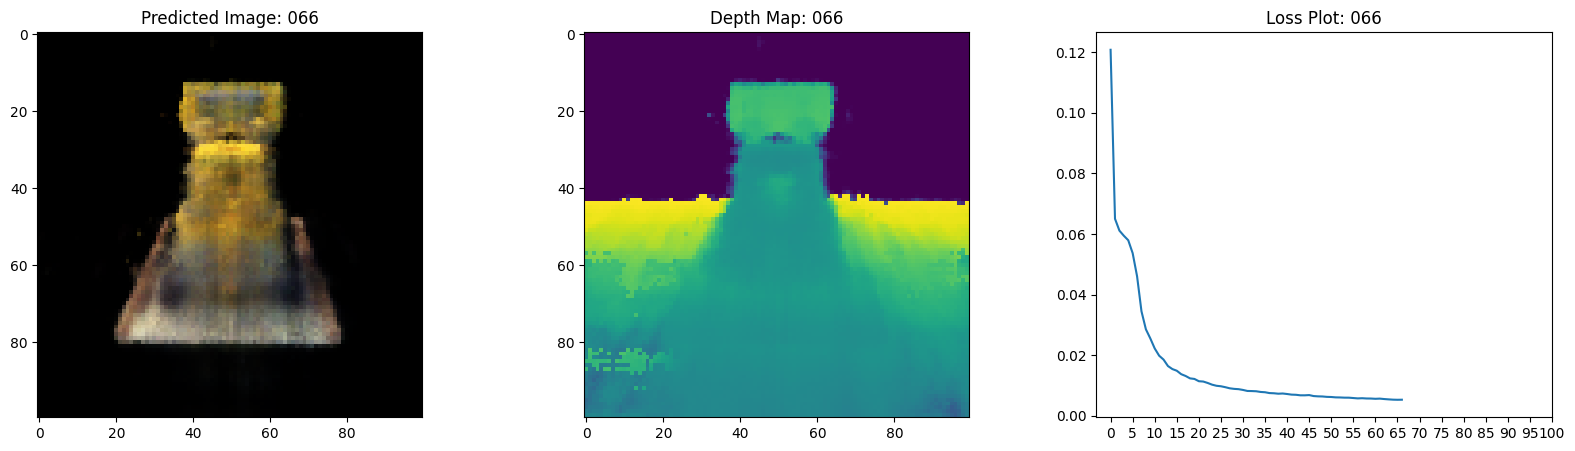

16/16 [==============================] - 23s 1s/step - loss: 0.0054 - psnr: 22.8415 - val_loss: 0.0058 - val_psnr: 22.4340
Epoch 68/100
1/1 [==============================] - 1s 742ms/steposs: 0.0055 - psnr: 22.73


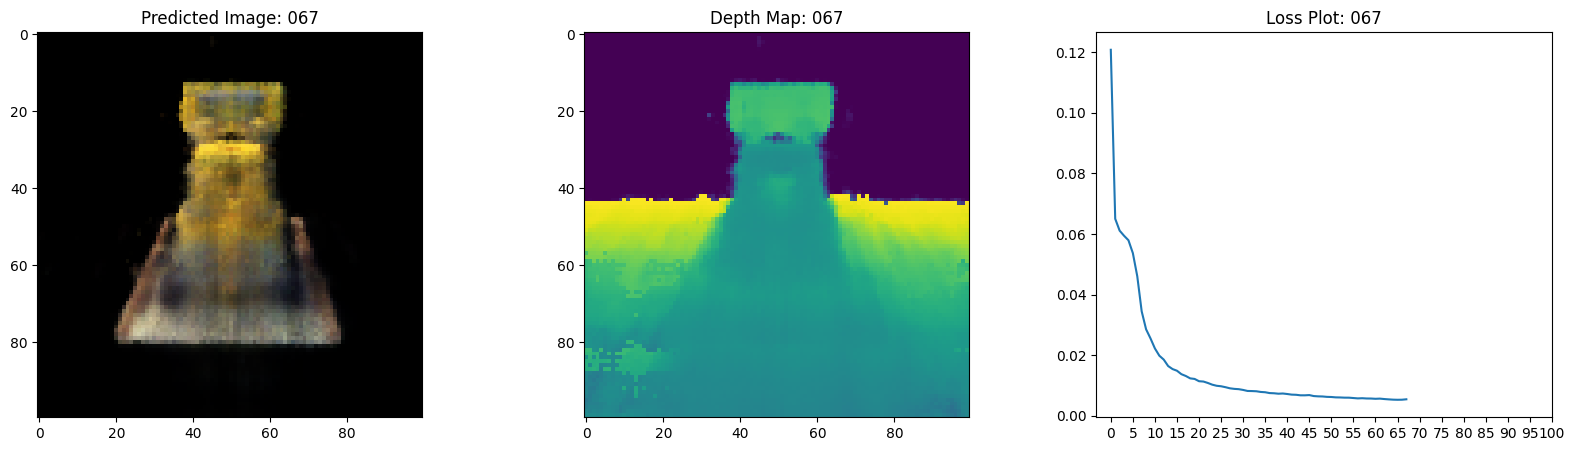

16/16 [==============================] - 24s 1s/step - loss: 0.0055 - psnr: 22.7315 - val_loss: 0.0056 - val_psnr: 22.6060
Epoch 69/100
1/1 [==============================] - 1s 744ms/steposs: 0.0053 - psnr: 22.86


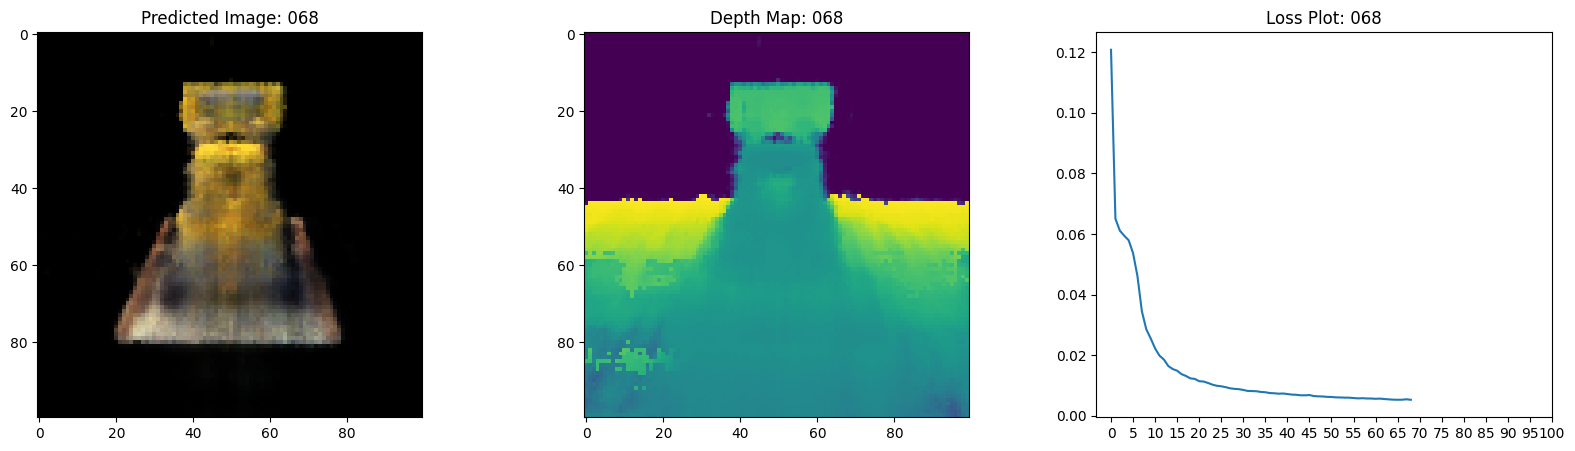

16/16 [==============================] - 24s 1s/step - loss: 0.0053 - psnr: 22.8646 - val_loss: 0.0055 - val_psnr: 22.6666
Epoch 70/100
1/1 [==============================] - 1s 745ms/steposs: 0.0052 - psnr: 22.97


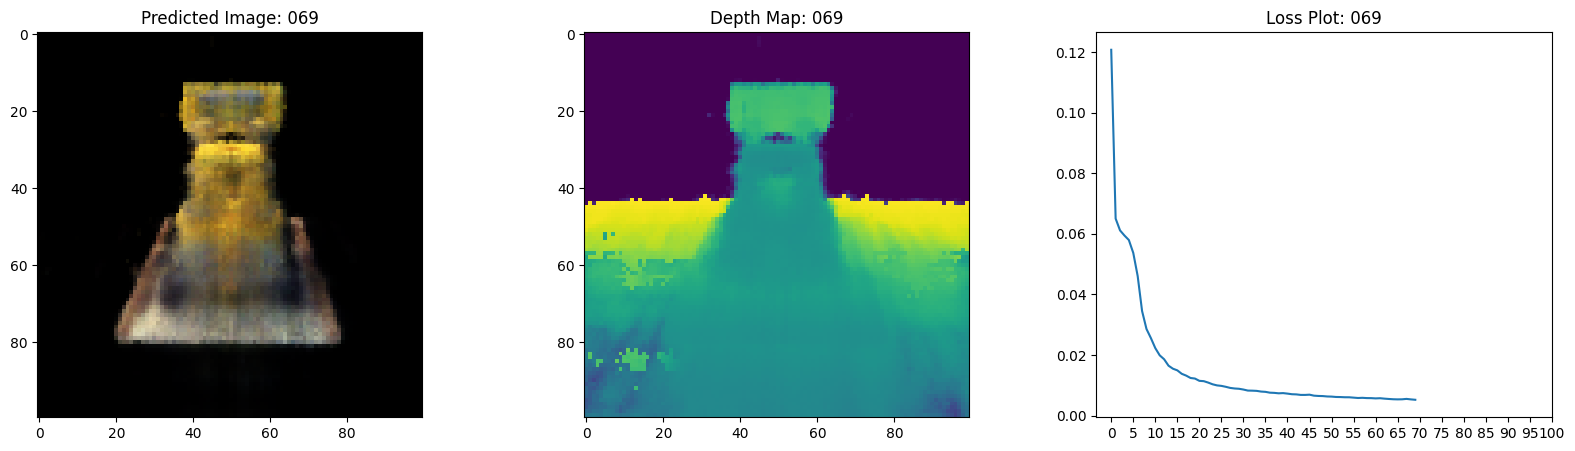

16/16 [==============================] - 24s 1s/step - loss: 0.0052 - psnr: 22.9754 - val_loss: 0.0056 - val_psnr: 22.6439
Epoch 71/100
1/1 [==============================] - 1s 738ms/steposs: 0.0052 - psnr: 23.01


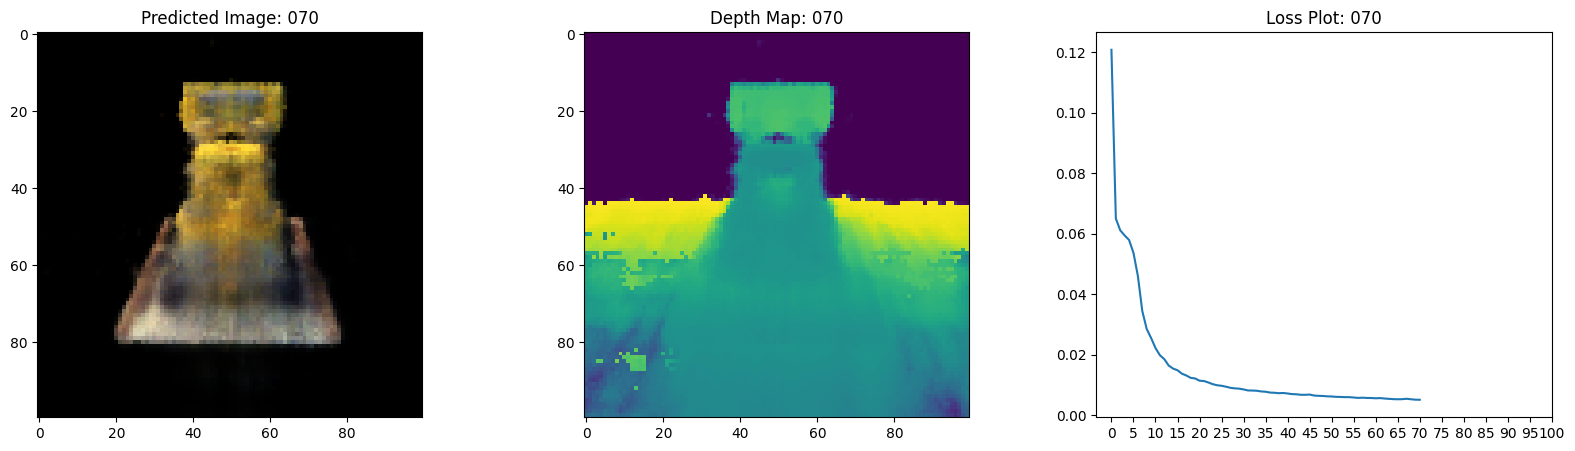

16/16 [==============================] - 23s 1s/step - loss: 0.0052 - psnr: 23.0114 - val_loss: 0.0054 - val_psnr: 22.7253
Epoch 72/100
1/1 [==============================] - 1s 734ms/steposs: 0.0051 - psnr: 23.08


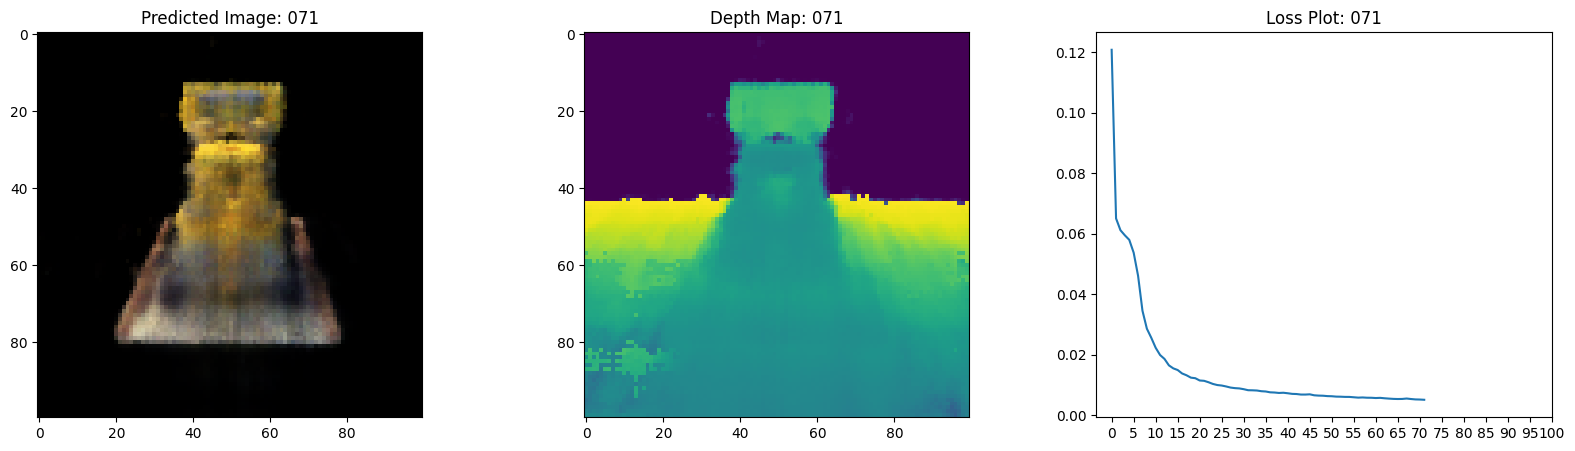

16/16 [==============================] - 24s 1s/step - loss: 0.0051 - psnr: 23.0806 - val_loss: 0.0054 - val_psnr: 22.8284
Epoch 73/100
1/1 [==============================] - 1s 733ms/steposs: 0.0050 - psnr: 23.18


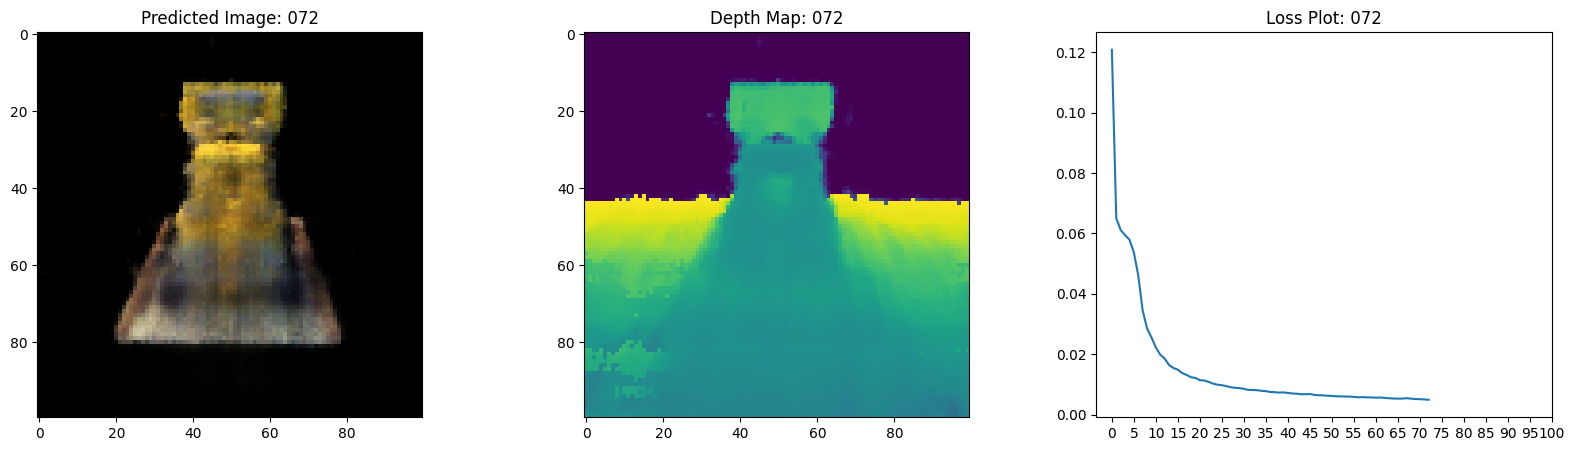

16/16 [==============================] - 24s 1s/step - loss: 0.0050 - psnr: 23.1891 - val_loss: 0.0053 - val_psnr: 22.8443
Epoch 74/100
1/1 [==============================] - 1s 733ms/steposs: 0.0050 - psnr: 23.17


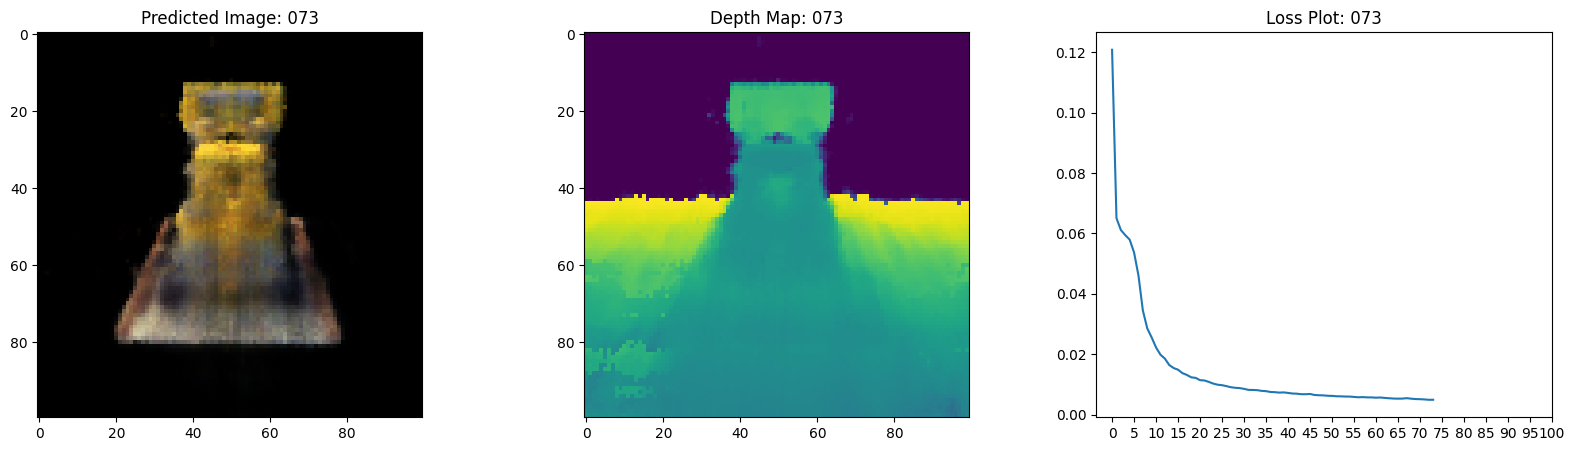

16/16 [==============================] - 24s 1s/step - loss: 0.0050 - psnr: 23.1769 - val_loss: 0.0051 - val_psnr: 22.9986
Epoch 75/100
1/1 [==============================] - 1s 753ms/steposs: 0.0049 - psnr: 23.20


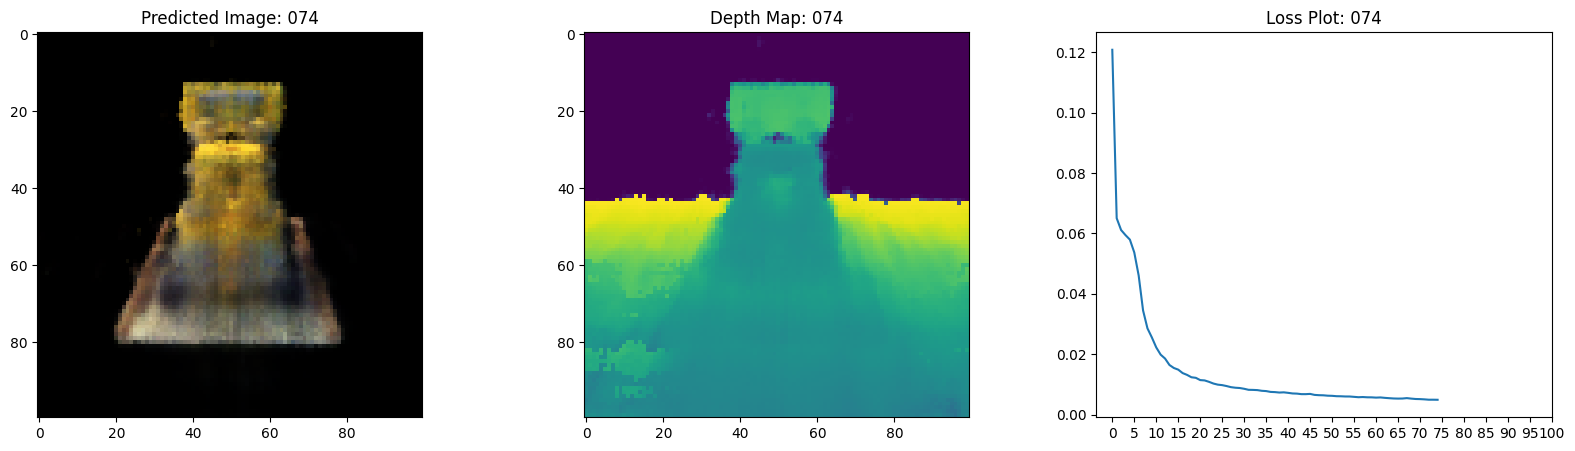

16/16 [==============================] - 23s 1s/step - loss: 0.0049 - psnr: 23.2004 - val_loss: 0.0052 - val_psnr: 23.0036
Epoch 76/100
1/1 [==============================] - 1s 755ms/steposs: 0.0048 - psnr: 23.29


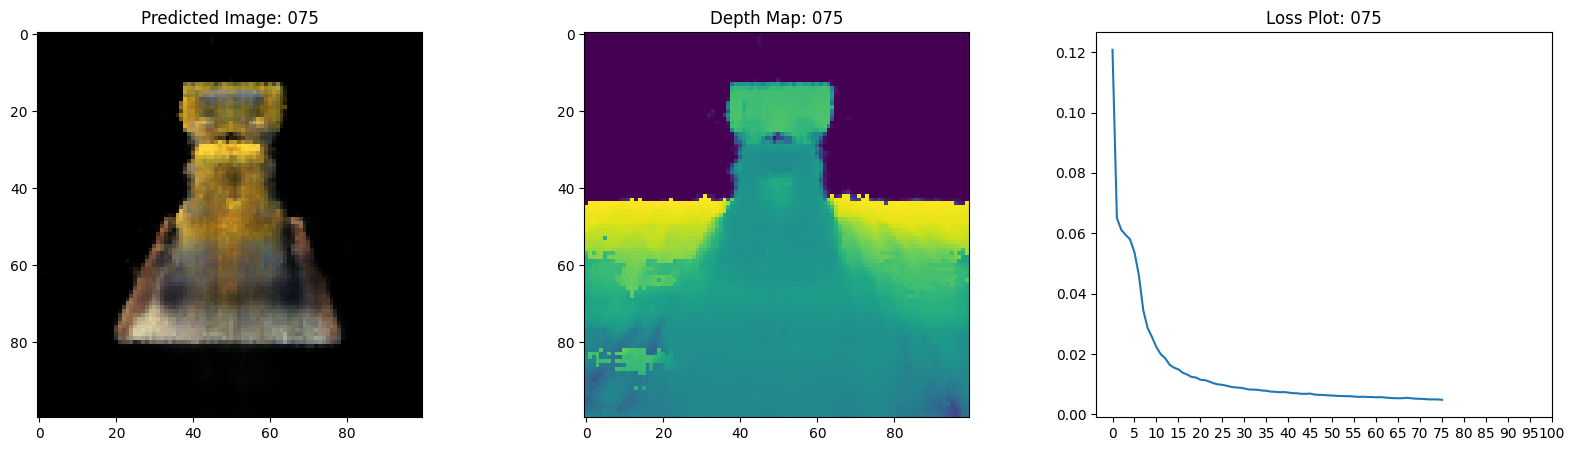

16/16 [==============================] - 23s 1s/step - loss: 0.0048 - psnr: 23.2948 - val_loss: 0.0051 - val_psnr: 23.0263
Epoch 77/100
1/1 [==============================] - 1s 736ms/steposs: 0.0048 - psnr: 23.28


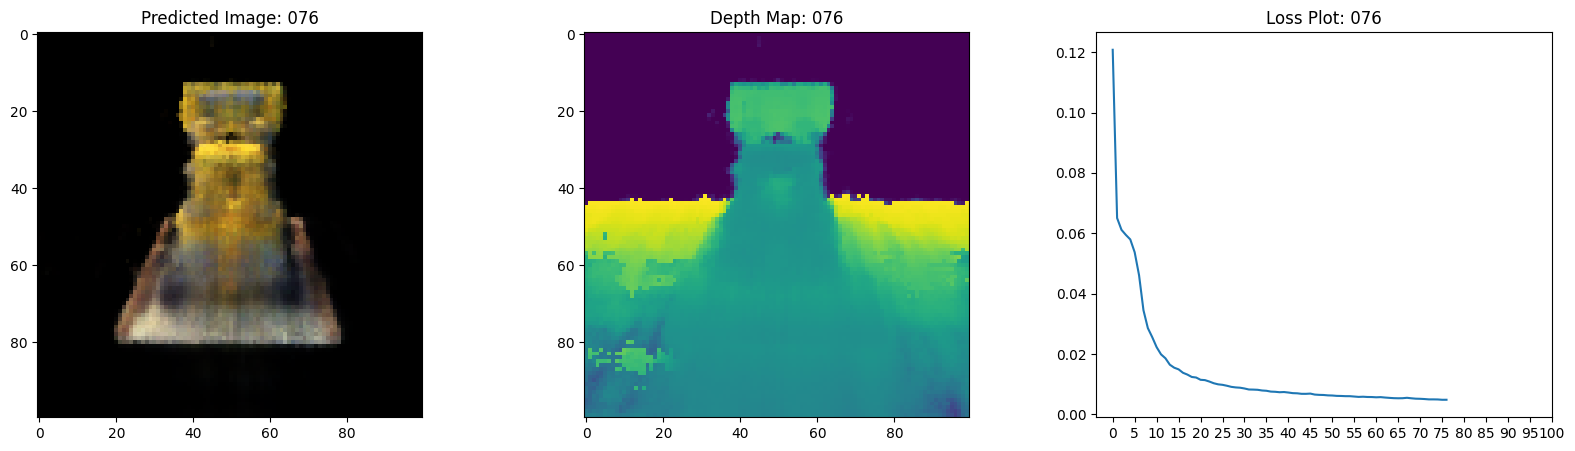

16/16 [==============================] - 24s 1s/step - loss: 0.0048 - psnr: 23.2882 - val_loss: 0.0053 - val_psnr: 22.8538
Epoch 78/100
1/1 [==============================] - 1s 759ms/steposs: 0.0049 - psnr: 23.28


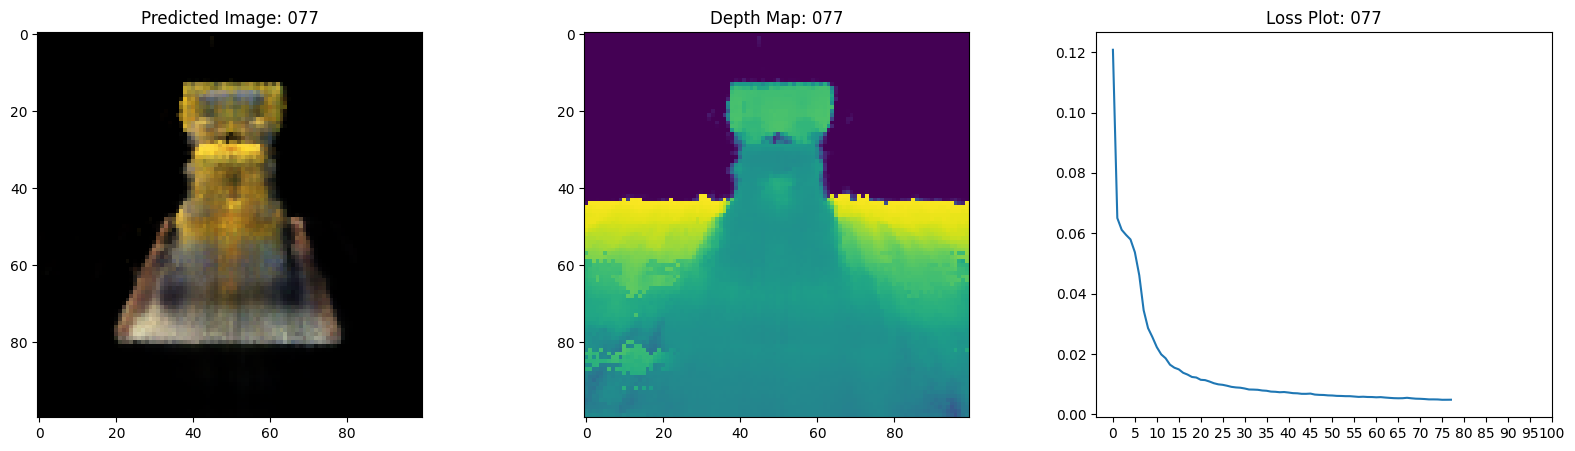

16/16 [==============================] - 24s 1s/step - loss: 0.0049 - psnr: 23.2804 - val_loss: 0.0051 - val_psnr: 23.0374
Epoch 79/100
1/1 [==============================] - 1s 755ms/steposs: 0.0048 - psnr: 23.37


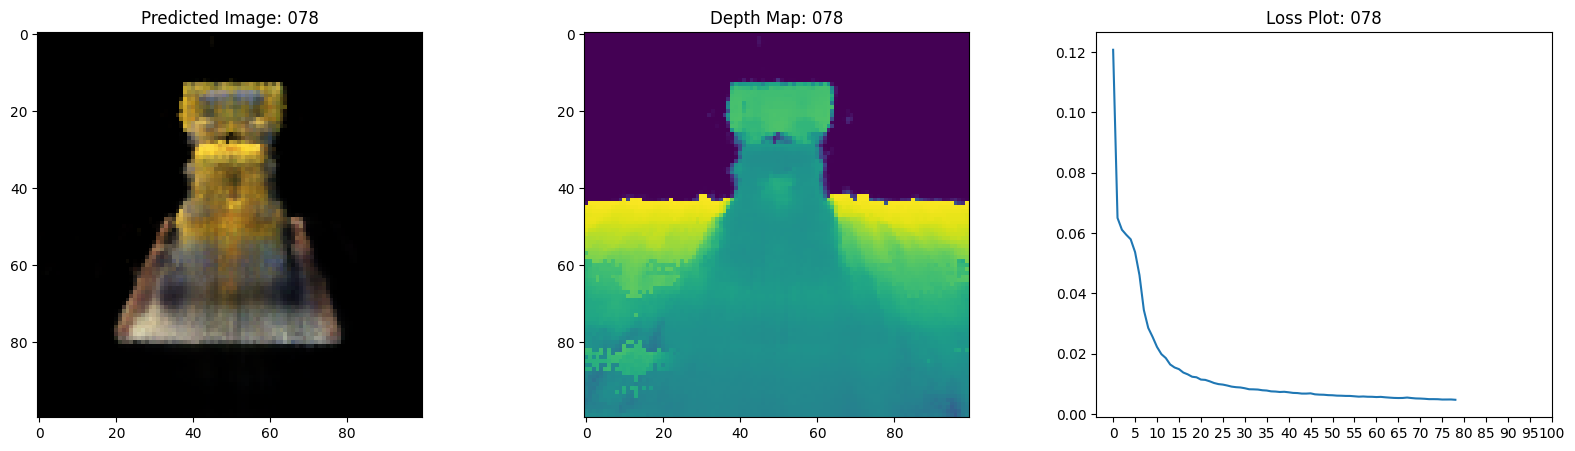

16/16 [==============================] - 23s 1s/step - loss: 0.0048 - psnr: 23.3735 - val_loss: 0.0051 - val_psnr: 23.0685
Epoch 80/100
1/1 [==============================] - 1s 752ms/steposs: 0.0048 - psnr: 23.31


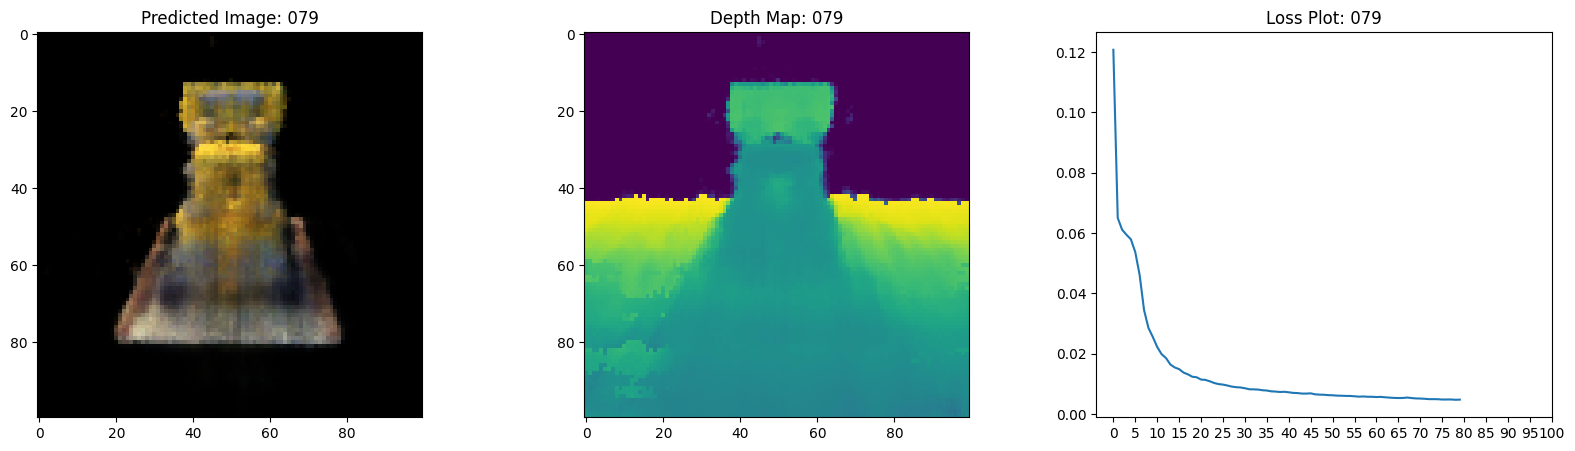

16/16 [==============================] - 23s 1s/step - loss: 0.0048 - psnr: 23.3181 - val_loss: 0.0052 - val_psnr: 22.9615
Epoch 81/100
1/1 [==============================] - 1s 741ms/steposs: 0.0047 - psnr: 23.38


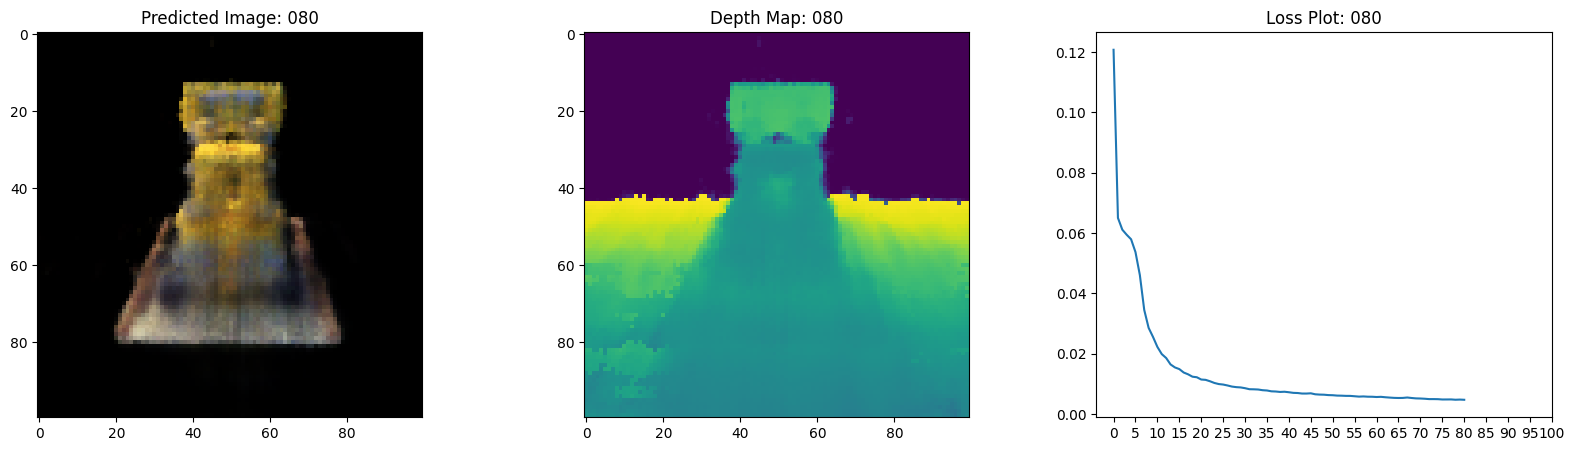

16/16 [==============================] - 23s 1s/step - loss: 0.0047 - psnr: 23.3843 - val_loss: 0.0051 - val_psnr: 22.9621
Epoch 82/100
1/1 [==============================] - 1s 762ms/steposs: 0.0047 - psnr: 23.40


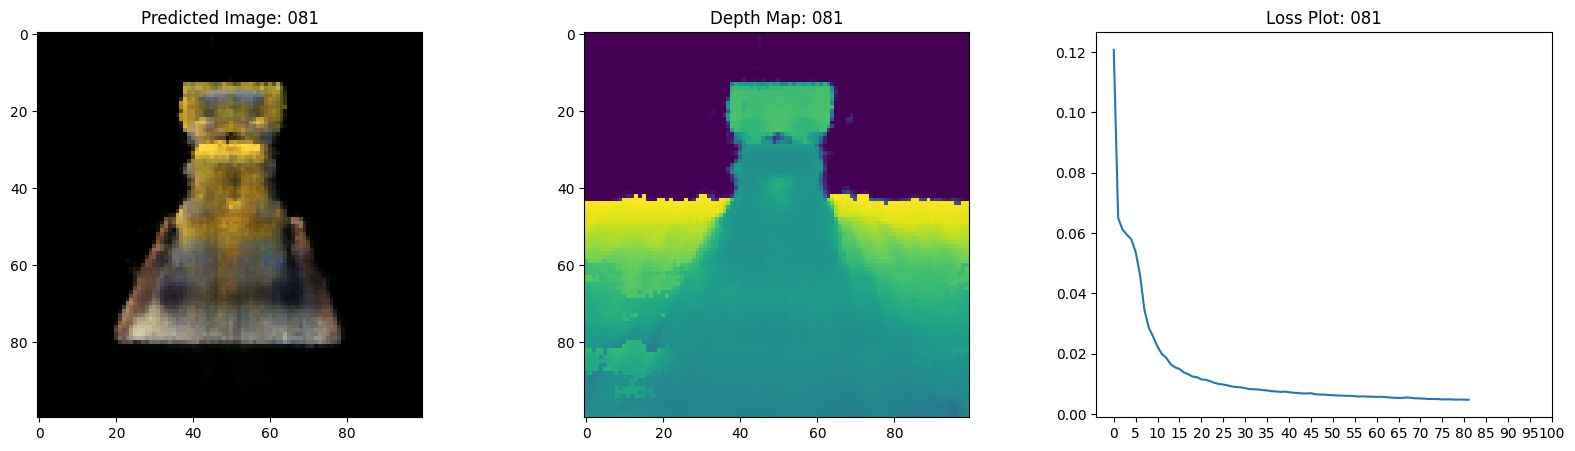

16/16 [==============================] - 24s 1s/step - loss: 0.0047 - psnr: 23.4048 - val_loss: 0.0052 - val_psnr: 22.8848
Epoch 83/100
1/1 [==============================] - 1s 759ms/steposs: 0.0047 - psnr: 23.38


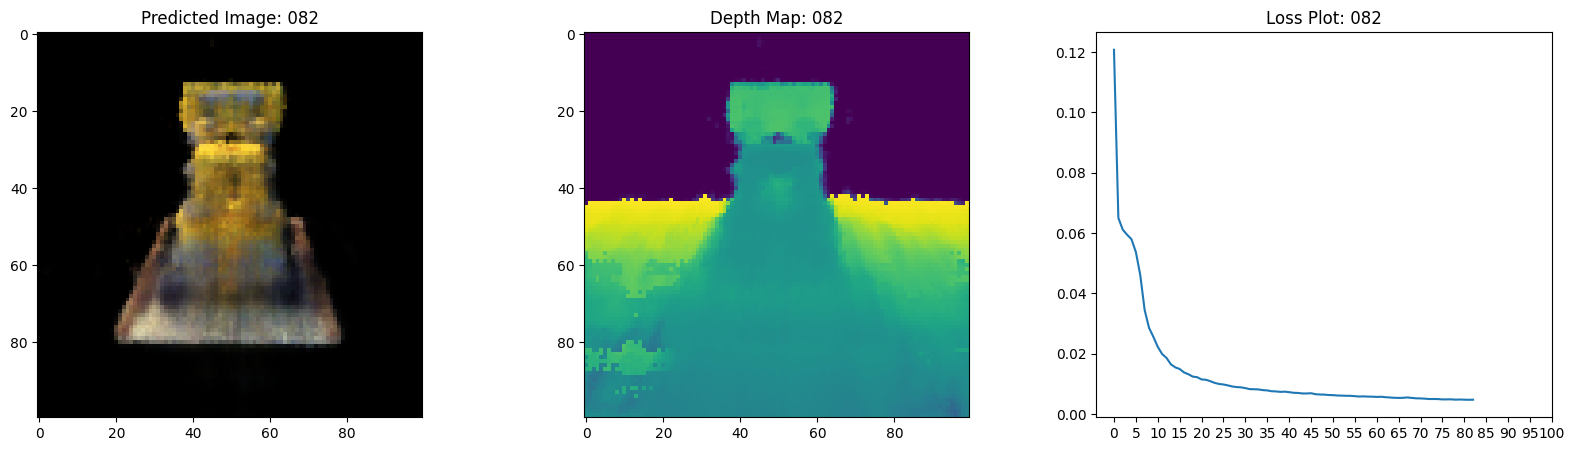

16/16 [==============================] - 24s 1s/step - loss: 0.0047 - psnr: 23.3802 - val_loss: 0.0050 - val_psnr: 23.1396
Epoch 84/100
1/1 [==============================] - 1s 737ms/steposs: 0.0047 - psnr: 23.44


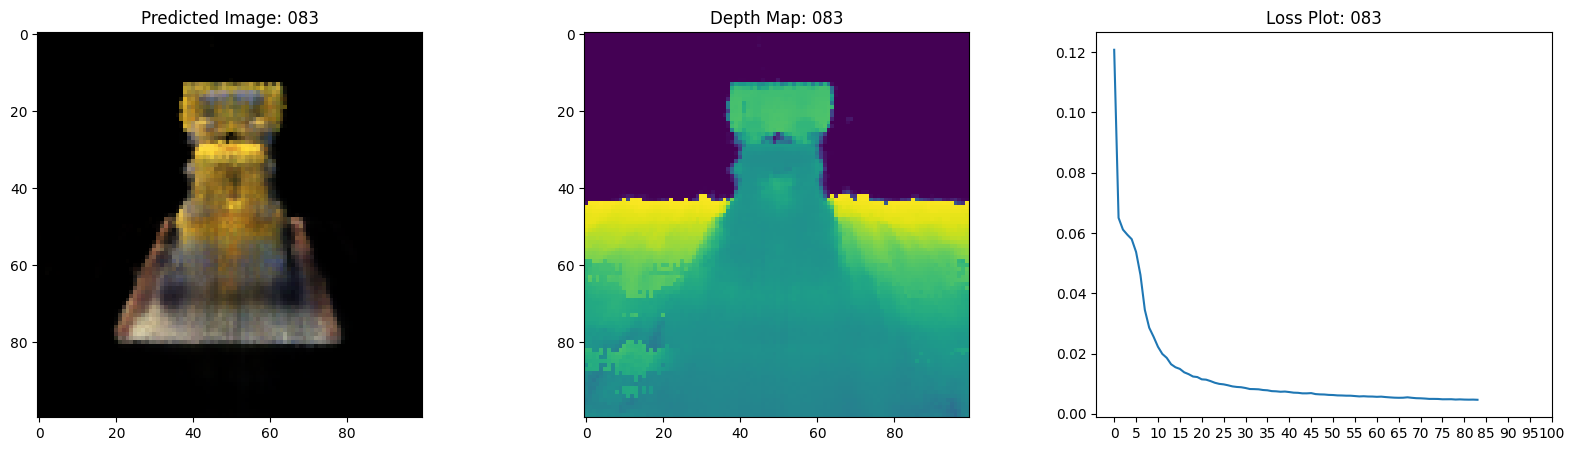

16/16 [==============================] - 24s 1s/step - loss: 0.0047 - psnr: 23.4439 - val_loss: 0.0048 - val_psnr: 23.3513
Epoch 85/100
1/1 [==============================] - 1s 744ms/steposs: 0.0046 - psnr: 23.53


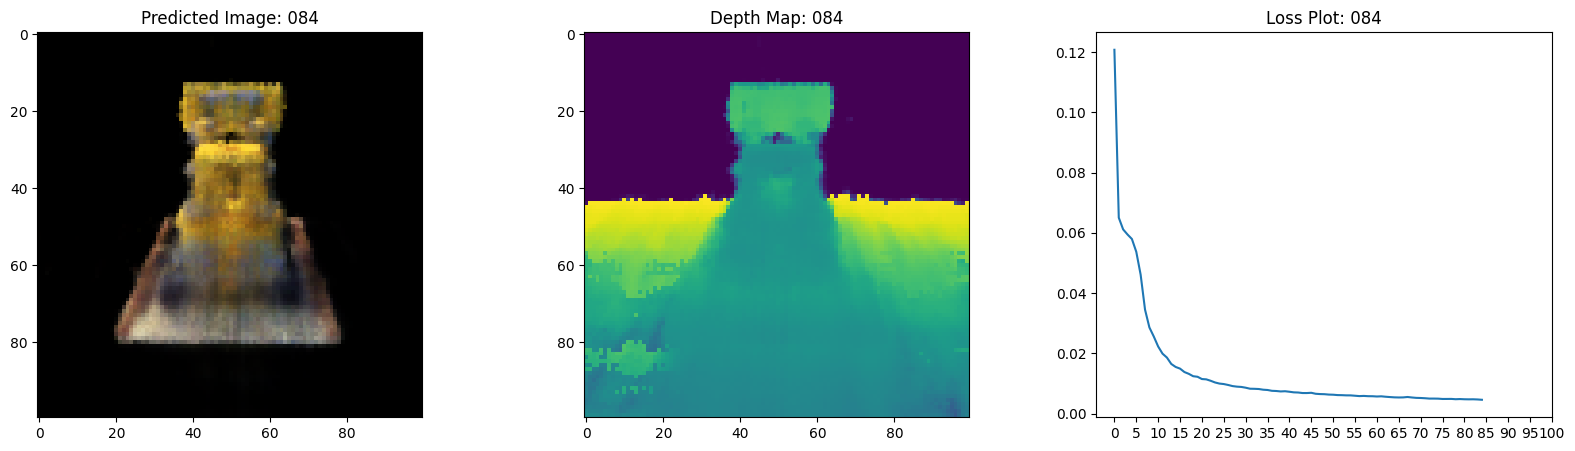

16/16 [==============================] - 24s 1s/step - loss: 0.0046 - psnr: 23.5372 - val_loss: 0.0049 - val_psnr: 23.2208
Epoch 86/100
1/1 [==============================] - 1s 751ms/steposs: 0.0045 - psnr: 23.56


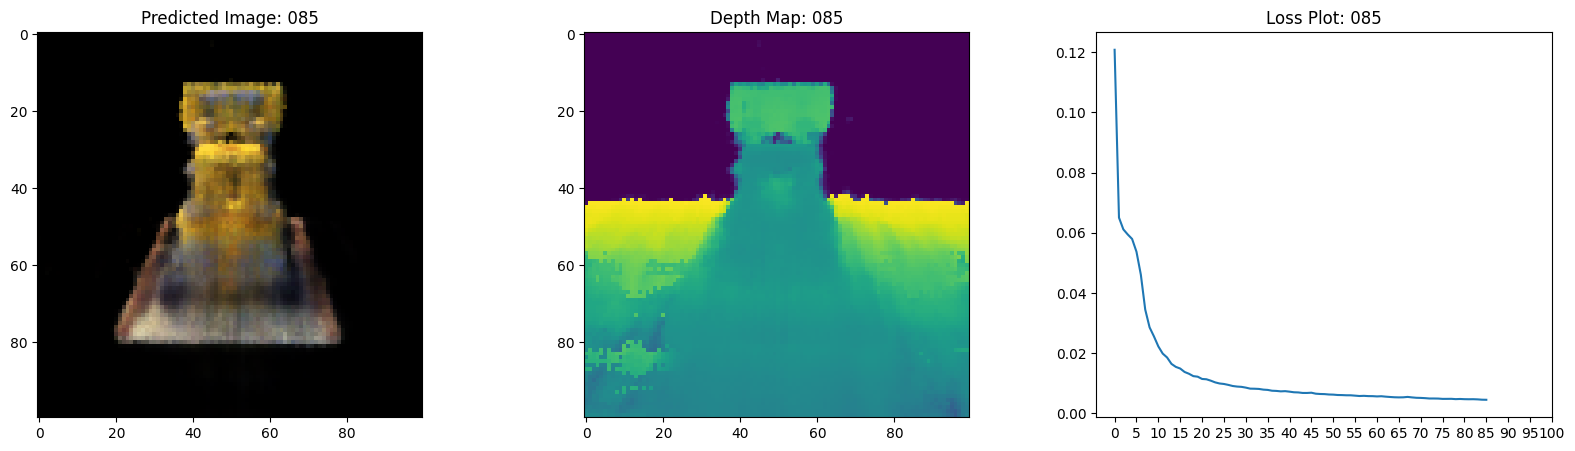

16/16 [==============================] - 24s 1s/step - loss: 0.0045 - psnr: 23.5619 - val_loss: 0.0046 - val_psnr: 23.4788
Epoch 87/100
1/1 [==============================] - 1s 746ms/steposs: 0.0044 - psnr: 23.68


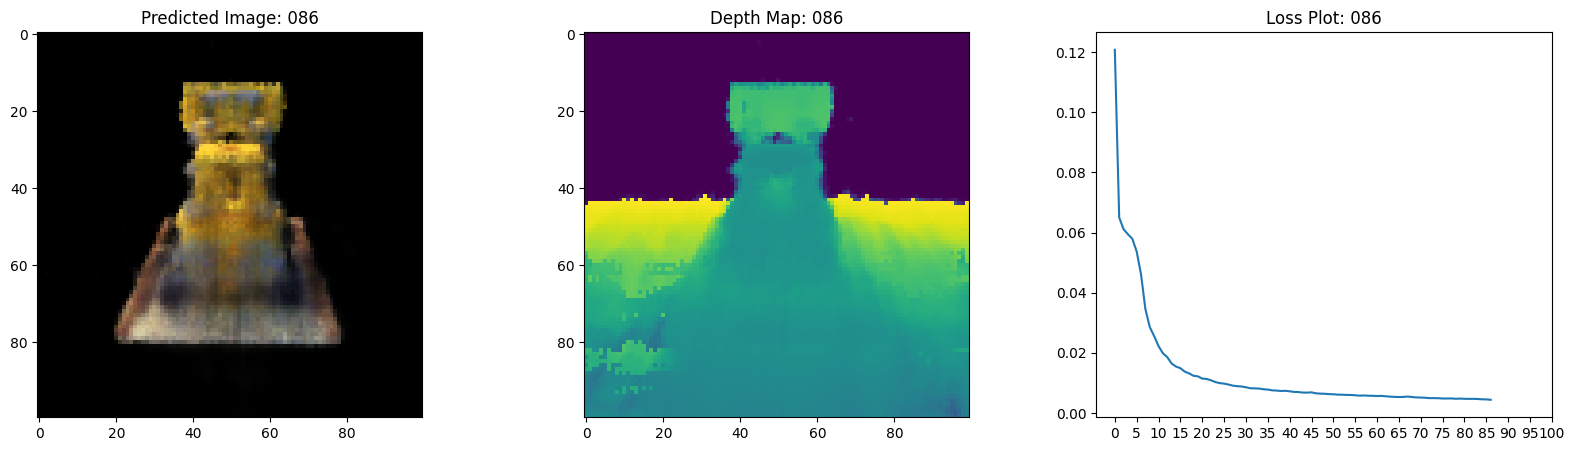

16/16 [==============================] - 24s 1s/step - loss: 0.0044 - psnr: 23.6886 - val_loss: 0.0046 - val_psnr: 23.5171
Epoch 88/100
1/1 [==============================] - 1s 748ms/steposs: 0.0044 - psnr: 23.70


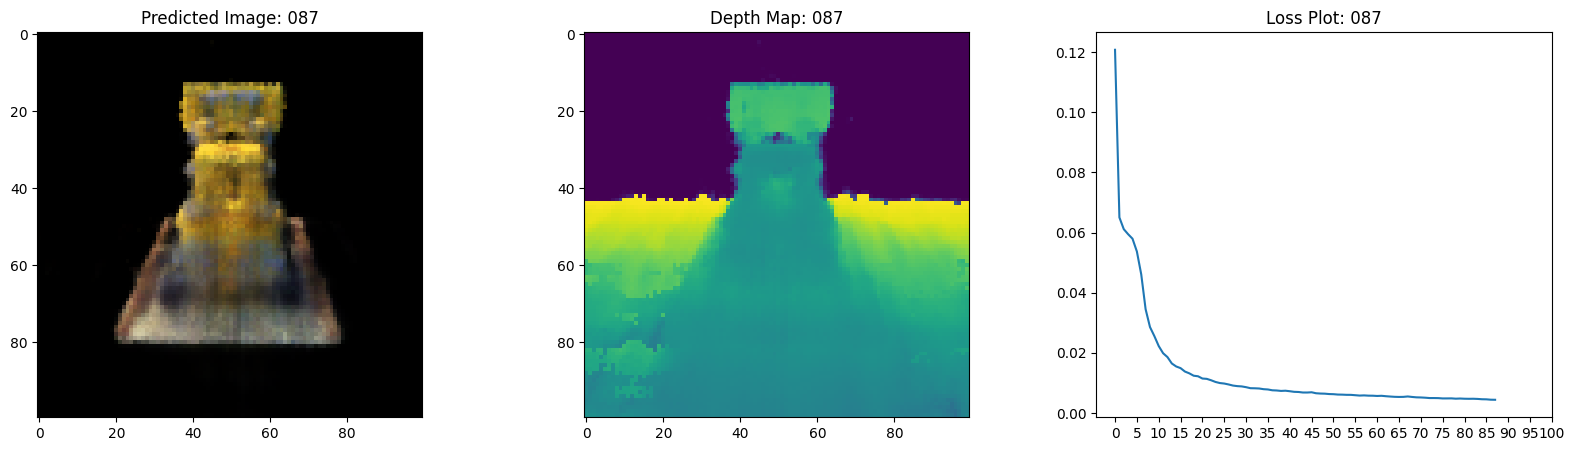

16/16 [==============================] - 23s 1s/step - loss: 0.0044 - psnr: 23.7062 - val_loss: 0.0047 - val_psnr: 23.3481
Epoch 89/100
1/1 [==============================] - 1s 752ms/steposs: 0.0045 - psnr: 23.62


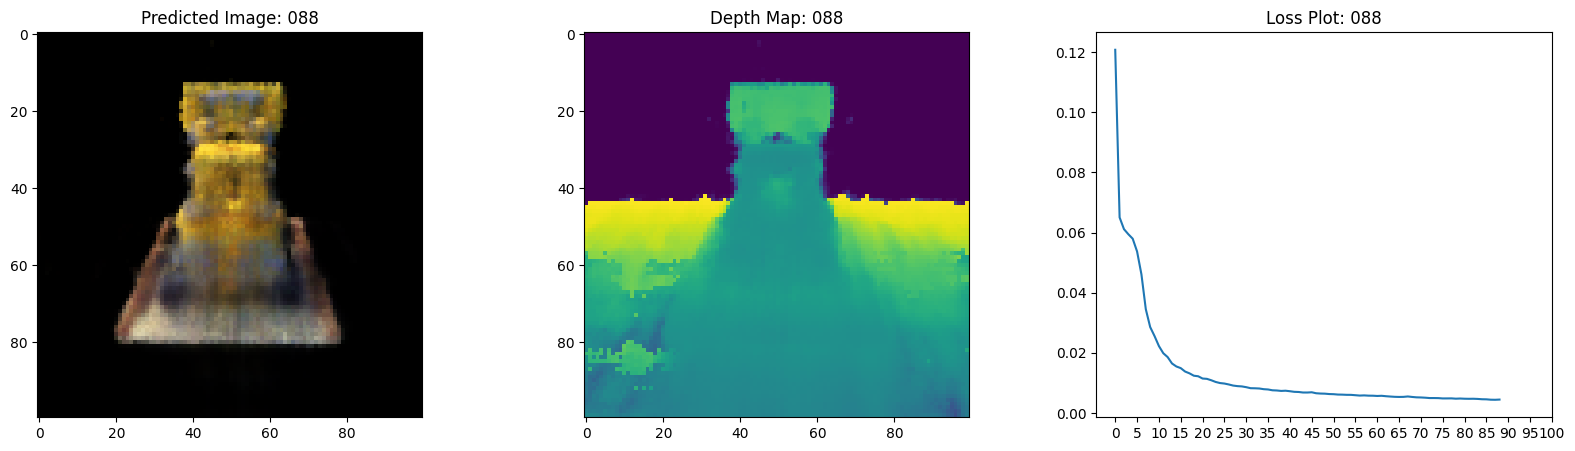

16/16 [==============================] - 23s 1s/step - loss: 0.0045 - psnr: 23.6299 - val_loss: 0.0048 - val_psnr: 23.3192
Epoch 90/100
1/1 [==============================] - 1s 761ms/steposs: 0.0046 - psnr: 23.54


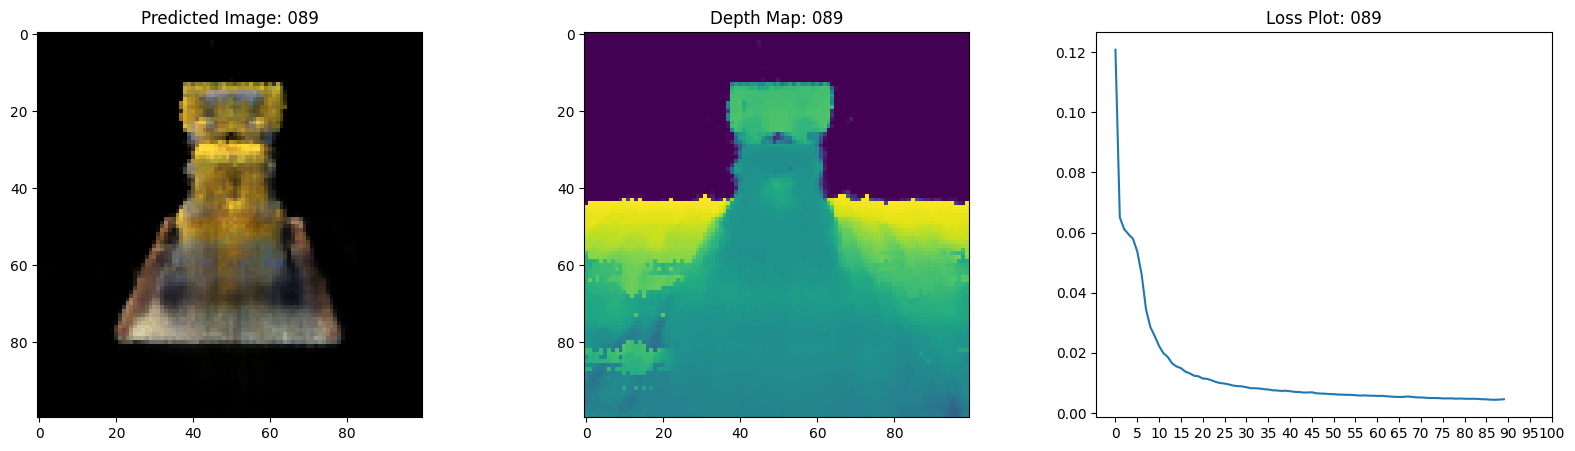

16/16 [==============================] - 24s 1s/step - loss: 0.0046 - psnr: 23.5474 - val_loss: 0.0049 - val_psnr: 23.1691
Epoch 91/100
1/1 [==============================] - 1s 742ms/steposs: 0.0046 - psnr: 23.48


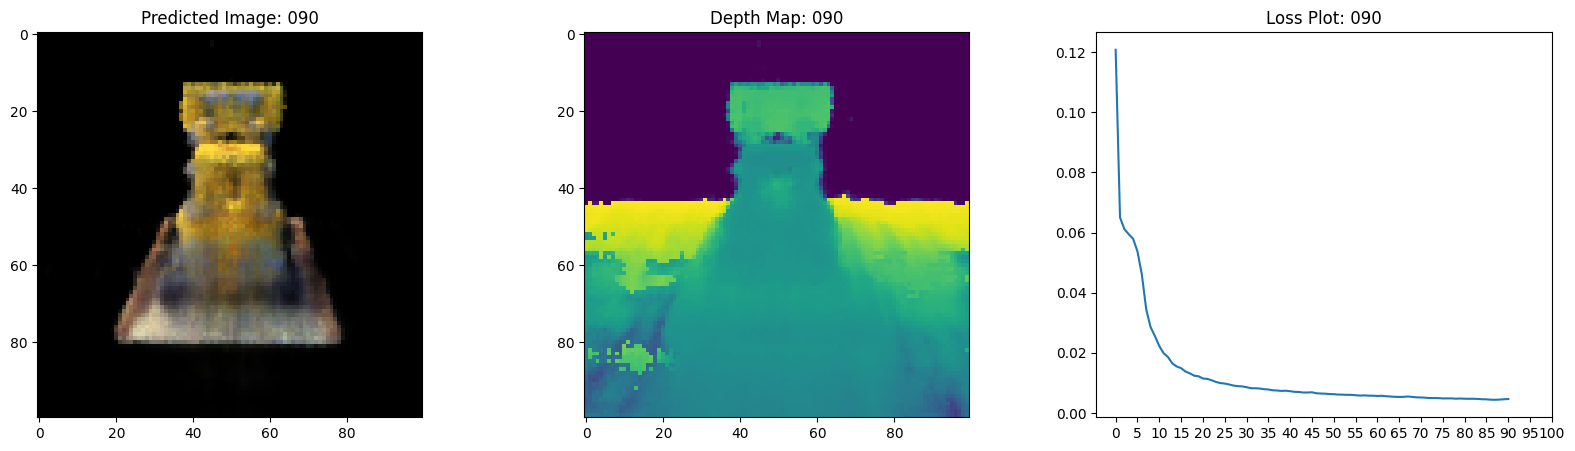

16/16 [==============================] - 24s 1s/step - loss: 0.0046 - psnr: 23.4860 - val_loss: 0.0050 - val_psnr: 23.0584
Epoch 92/100
1/1 [==============================] - 1s 741ms/steposs: 0.0045 - psnr: 23.64


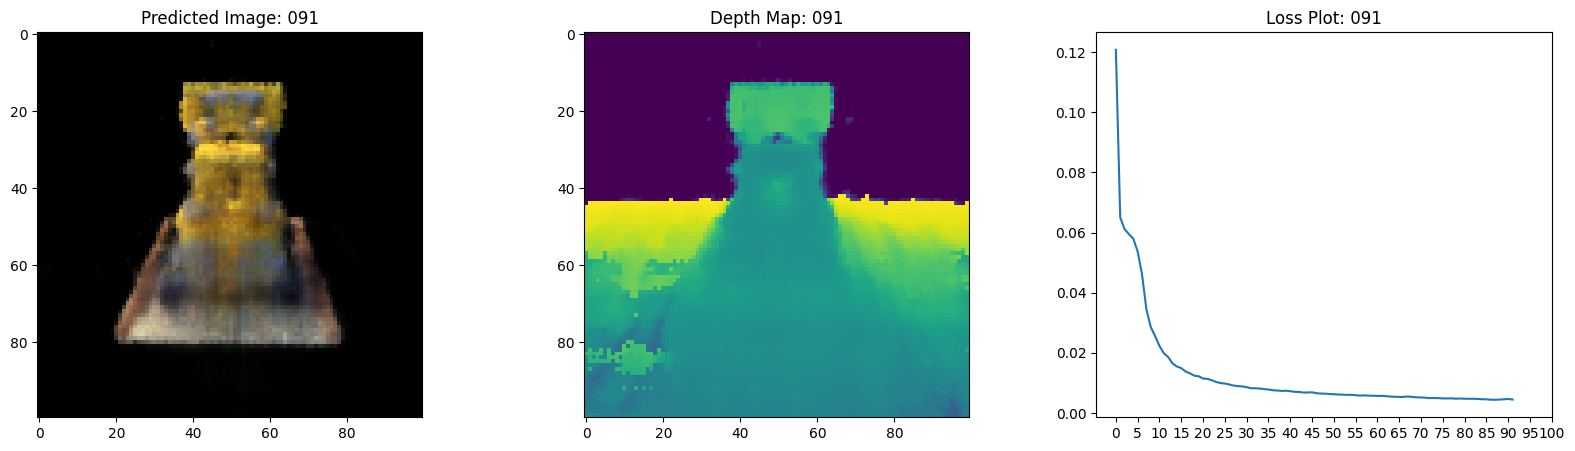

16/16 [==============================] - 24s 1s/step - loss: 0.0045 - psnr: 23.6405 - val_loss: 0.0050 - val_psnr: 23.0949
Epoch 93/100
1/1 [==============================] - 1s 739ms/steposs: 0.0044 - psnr: 23.67


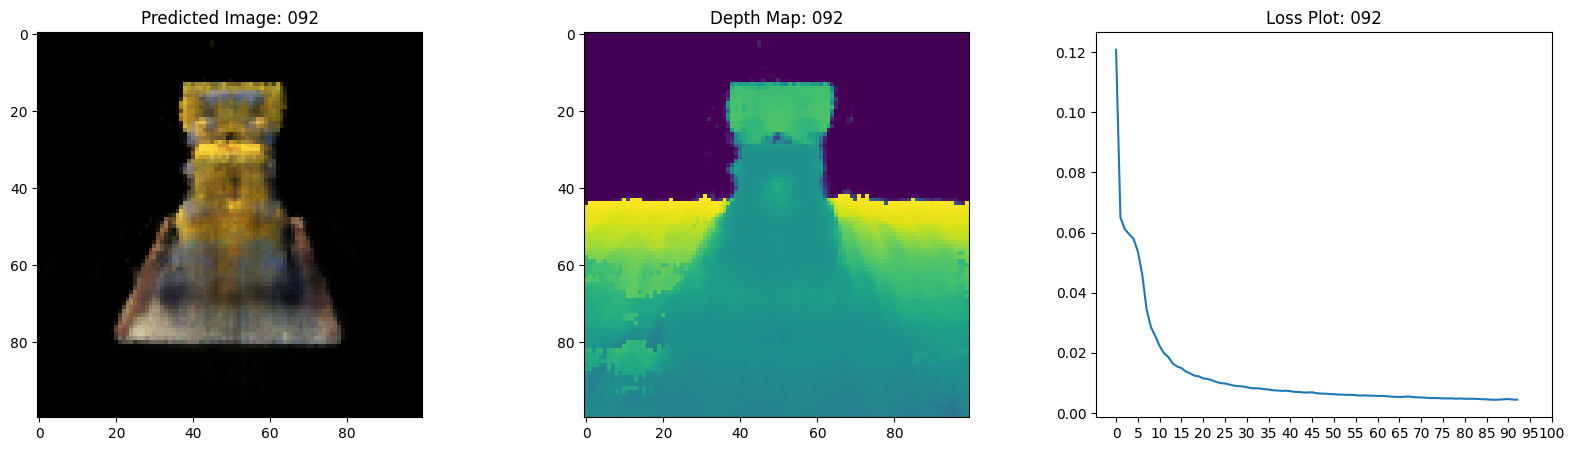

16/16 [==============================] - 24s 1s/step - loss: 0.0044 - psnr: 23.6738 - val_loss: 0.0049 - val_psnr: 23.1785
Epoch 94/100
1/1 [==============================] - 1s 750ms/steposs: 0.0043 - psnr: 23.78


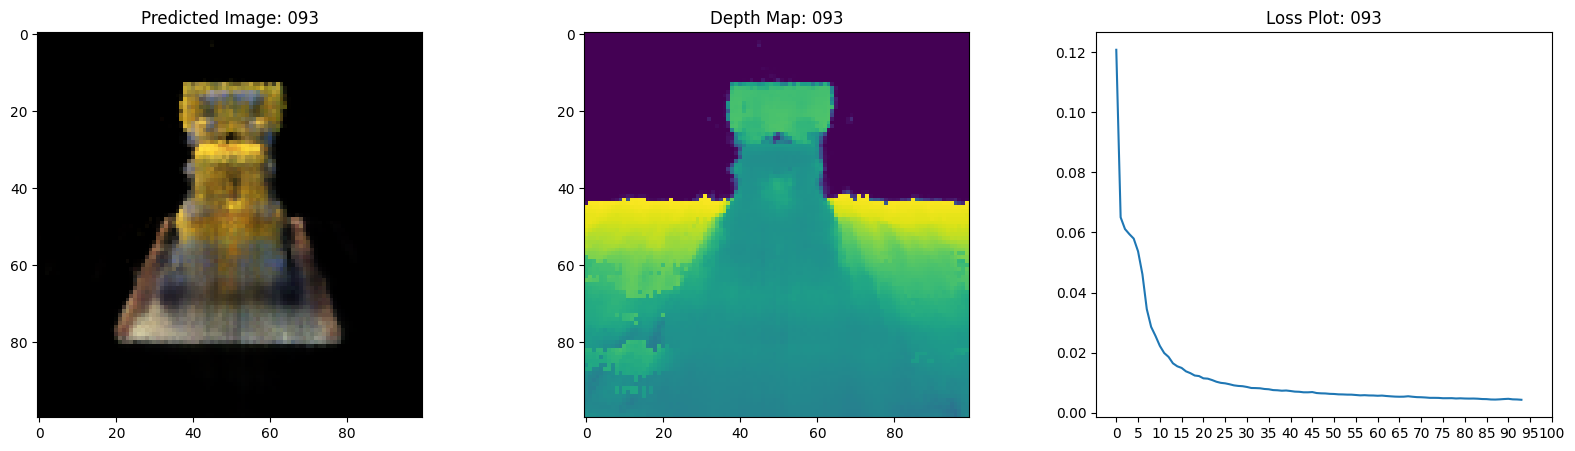

16/16 [==============================] - 24s 1s/step - loss: 0.0043 - psnr: 23.7808 - val_loss: 0.0046 - val_psnr: 23.4934
Epoch 95/100
1/1 [==============================] - 1s 763ms/steposs: 0.0043 - psnr: 23.85


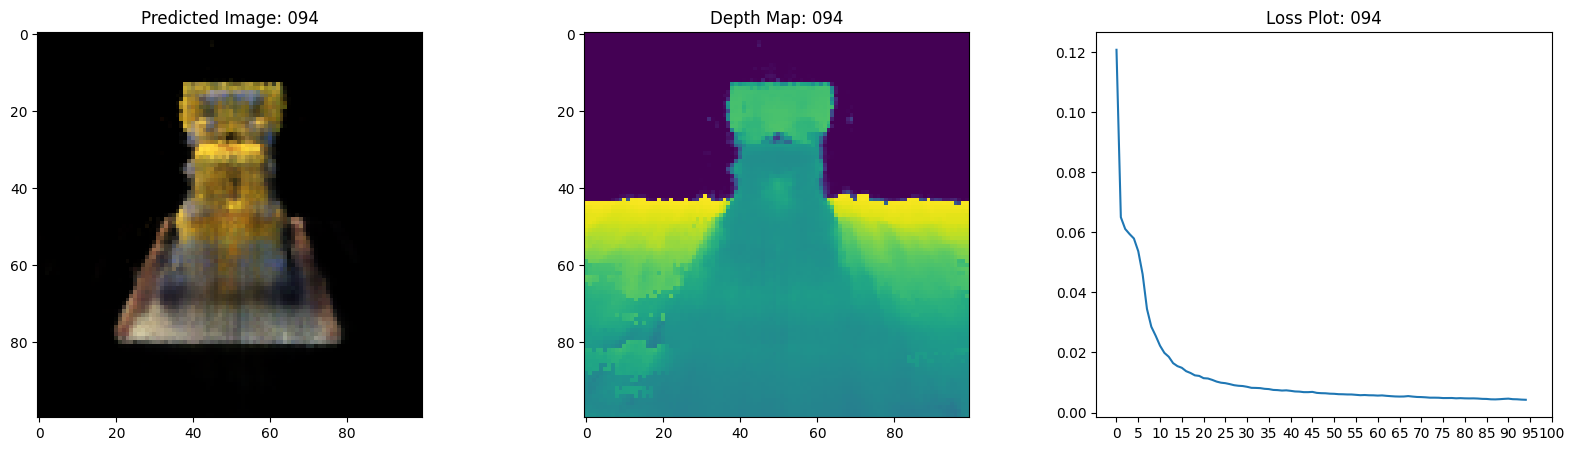

16/16 [==============================] - 24s 1s/step - loss: 0.0043 - psnr: 23.8541 - val_loss: 0.0049 - val_psnr: 23.1997
Epoch 96/100
1/1 [==============================] - 1s 756ms/steposs: 0.0043 - psnr: 23.77


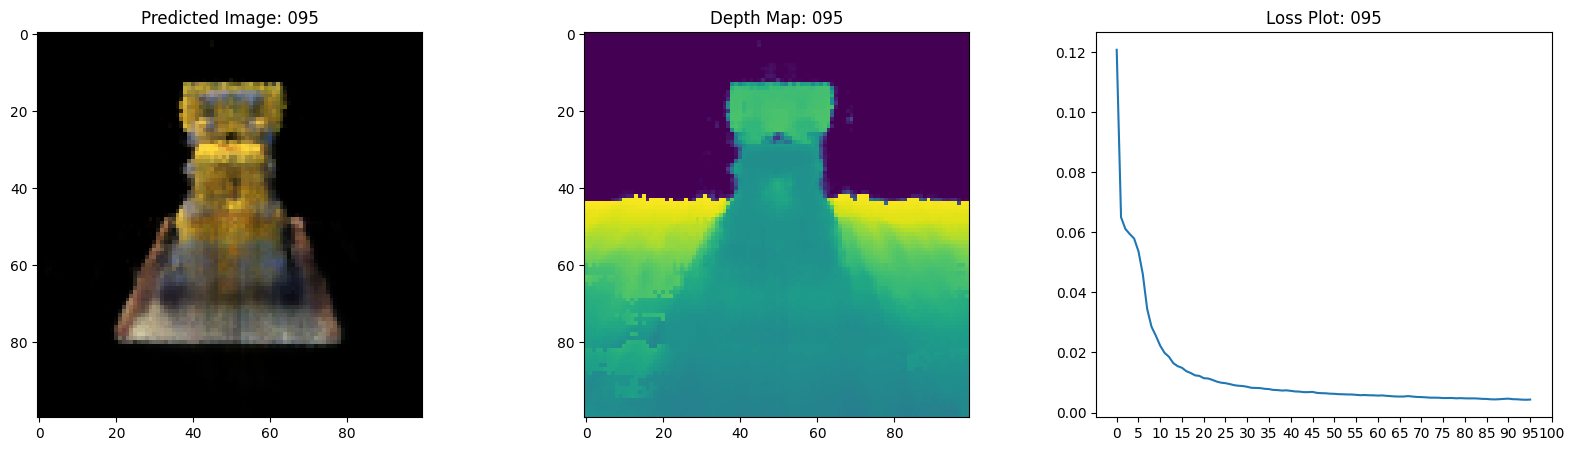

16/16 [==============================] - 24s 1s/step - loss: 0.0043 - psnr: 23.7776 - val_loss: 0.0049 - val_psnr: 23.1914
Epoch 97/100
1/1 [==============================] - 1s 764ms/steposs: 0.0043 - psnr: 23.74


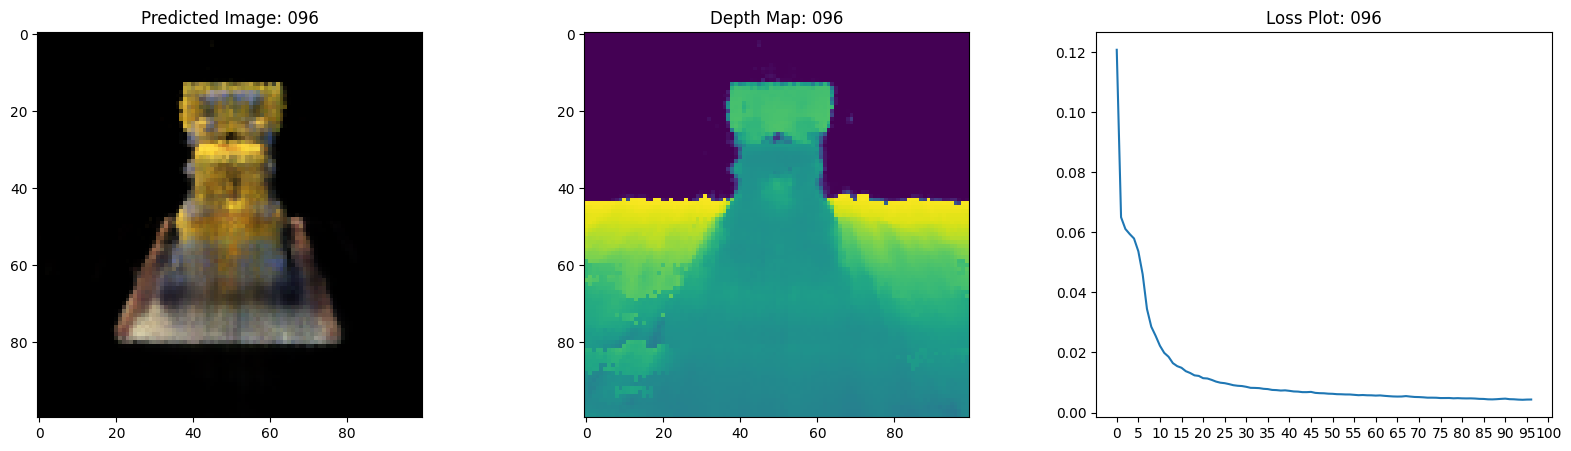

16/16 [==============================] - 24s 1s/step - loss: 0.0043 - psnr: 23.7417 - val_loss: 0.0047 - val_psnr: 23.3691
Epoch 98/100
1/1 [==============================] - 1s 738ms/steposs: 0.0042 - psnr: 23.85


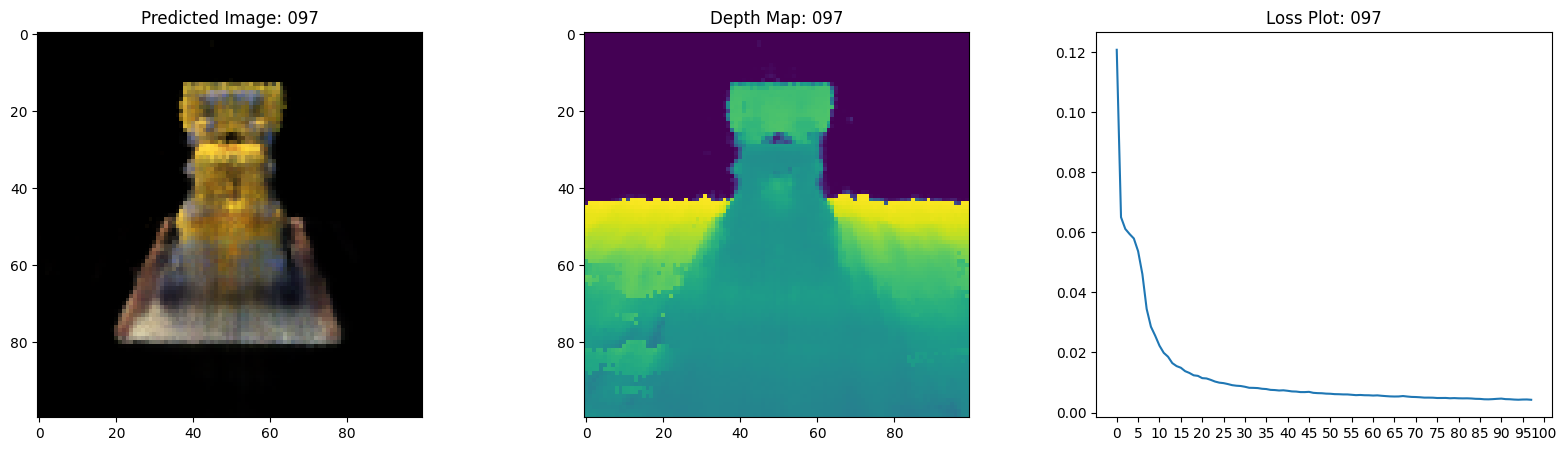

16/16 [==============================] - 24s 1s/step - loss: 0.0042 - psnr: 23.8527 - val_loss: 0.0044 - val_psnr: 23.6393
Epoch 99/100
1/1 [==============================] - 1s 759ms/steposs: 0.0042 - psnr: 23.93


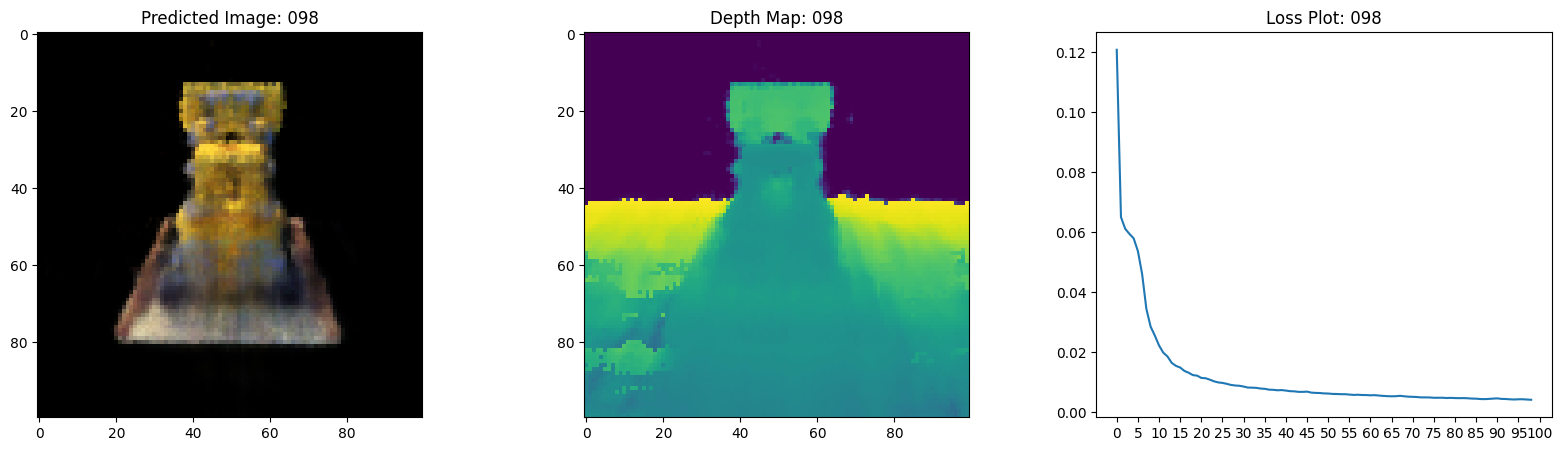

16/16 [==============================] - 24s 1s/step - loss: 0.0042 - psnr: 23.9362 - val_loss: 0.0044 - val_psnr: 23.6472
Epoch 100/100
1/1 [==============================] - 1s 743ms/steposs: 0.0042 - psnr: 23.87


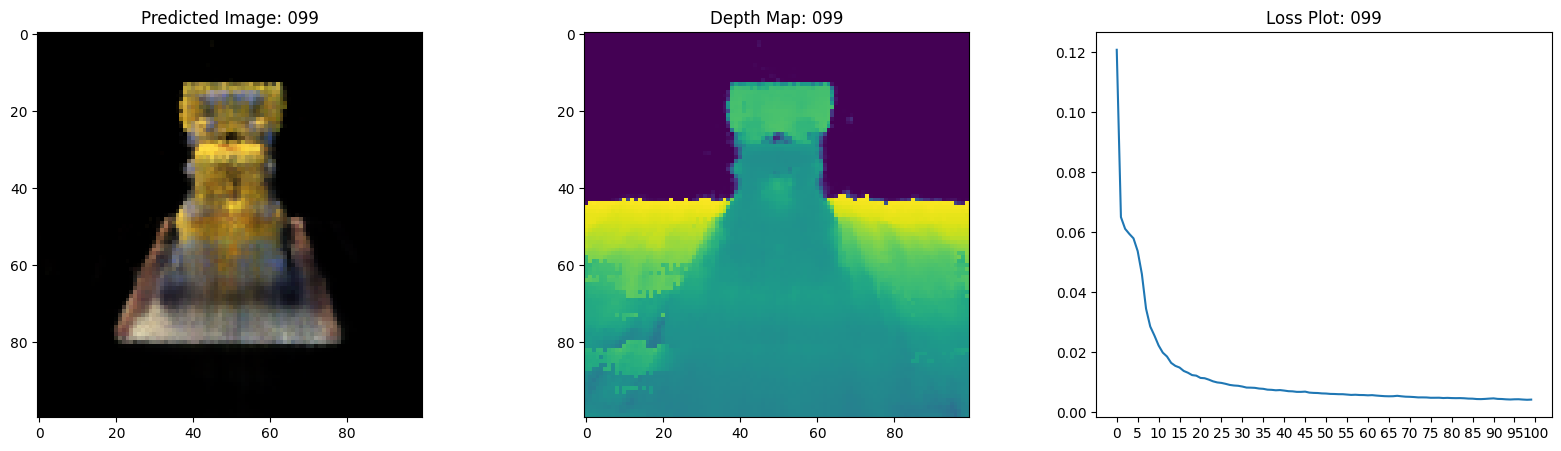

16/16 [==============================] - 24s 1s/step - loss: 0.0042 - psnr: 23.8769 - val_loss: 0.0046 - val_psnr: 23.4464


100%|██████████| 100/100 [00:01<00:00, 95.82it/s]


In [5]:

class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(tf.keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(tf.keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()


num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss_fn=tf.keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
)


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")

1/1 [==============================] - 1s 773ms/step


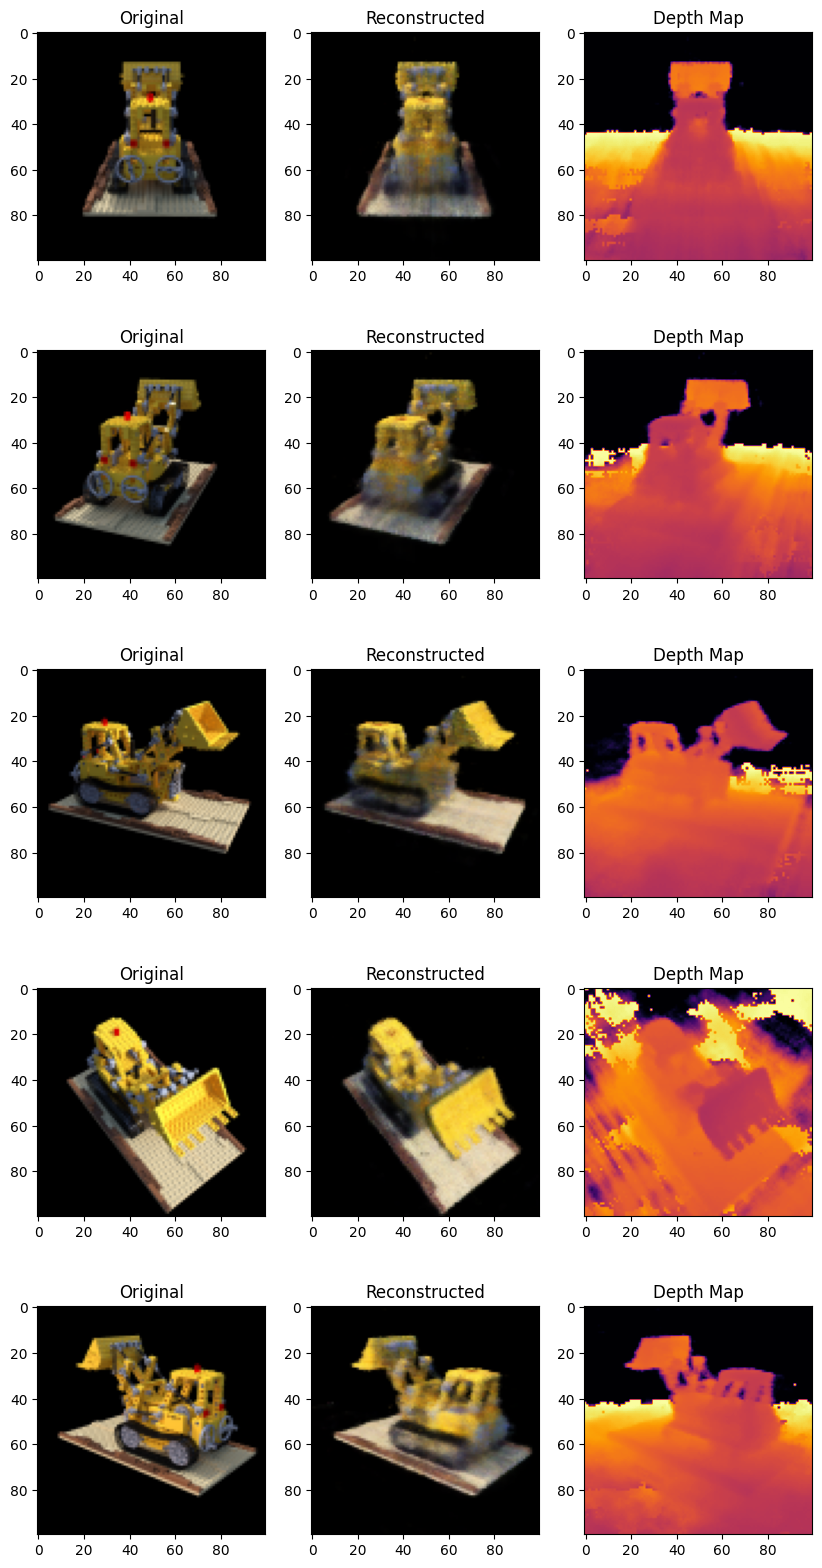

In [6]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(tf.keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(tf.keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(tf.keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

In [7]:

def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)
 

def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

4it [00:00, 35.89it/s]

1/1 [==============================] - 1s 732ms/step


8it [00:01,  5.41it/s]

1/1 [==============================] - 1s 715ms/step


11it [00:02,  3.76it/s]

1/1 [==============================] - 1s 731ms/step


16it [00:03,  3.91it/s]

1/1 [==============================] - 1s 759ms/step


21it [00:04,  4.00it/s]

1/1 [==============================] - 1s 735ms/step


26it [00:06,  4.06it/s]

1/1 [==============================] - 1s 700ms/step


31it [00:07,  4.16it/s]

1/1 [==============================] - 1s 751ms/step


36it [00:08,  4.18it/s]

1/1 [==============================] - 1s 730ms/step


41it [00:09,  4.16it/s]

1/1 [==============================] - 1s 679ms/step


46it [00:10,  4.17it/s]

1/1 [==============================] - 1s 717ms/step


51it [00:12,  4.16it/s]

1/1 [==============================] - 1s 725ms/step


56it [00:13,  4.09it/s]

1/1 [==============================] - 1s 680ms/step


61it [00:14,  4.20it/s]

1/1 [==============================] - 1s 715ms/step


66it [00:15,  4.24it/s]

1/1 [==============================] - 1s 727ms/step


71it [00:16,  4.23it/s]

1/1 [==============================] - 1s 766ms/step


76it [00:17,  4.20it/s]

1/1 [==============================] - 1s 755ms/step


81it [00:19,  4.20it/s]

1/1 [==============================] - 1s 738ms/step


86it [00:20,  4.19it/s]

1/1 [==============================] - 1s 700ms/step


91it [00:21,  4.22it/s]

1/1 [==============================] - 1s 753ms/step


96it [00:22,  4.16it/s]

1/1 [==============================] - 1s 725ms/step


101it [00:23,  4.18it/s]

1/1 [==============================] - 1s 684ms/step


106it [00:25,  4.24it/s]

1/1 [==============================] - 1s 743ms/step


111it [00:26,  4.22it/s]

1/1 [==============================] - 1s 780ms/step


120it [00:27,  4.35it/s]
[swscaler @ 0x217a2800] Warning: data is not aligned! This can lead to a speed loss
